In [1]:
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from numpy.random import default_rng
import warnings
from sklearn.metrics import mean_squared_error

from hopfield import HopfieldNetwork

rand_gen = default_rng()

# plt.rcParams.update({'lines.markeredgewidth': 1})
sns.set(palette='Dark2')
sns.set_context('paper' , font_scale=1.0)
pylab.rcParams['figure.dpi'] = 300

nn = HopfieldNetwork()

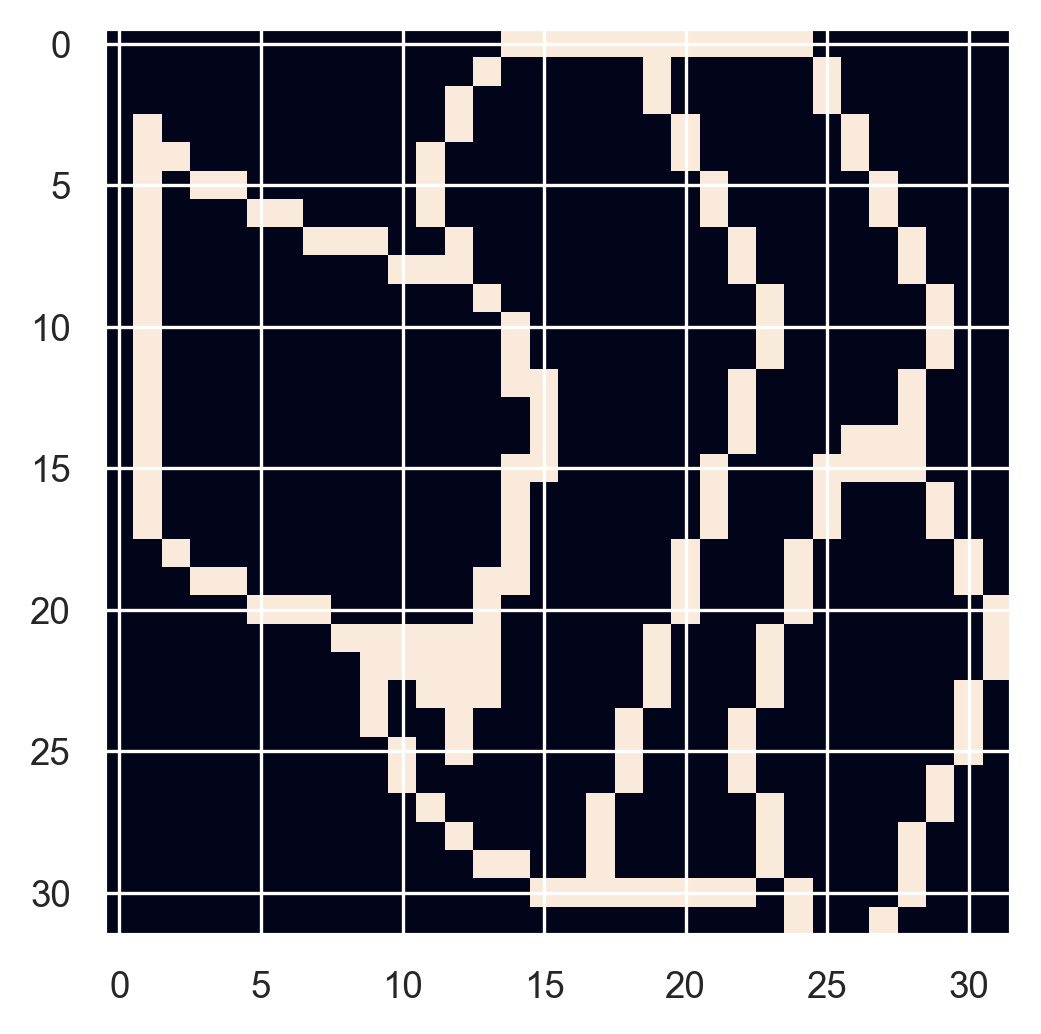

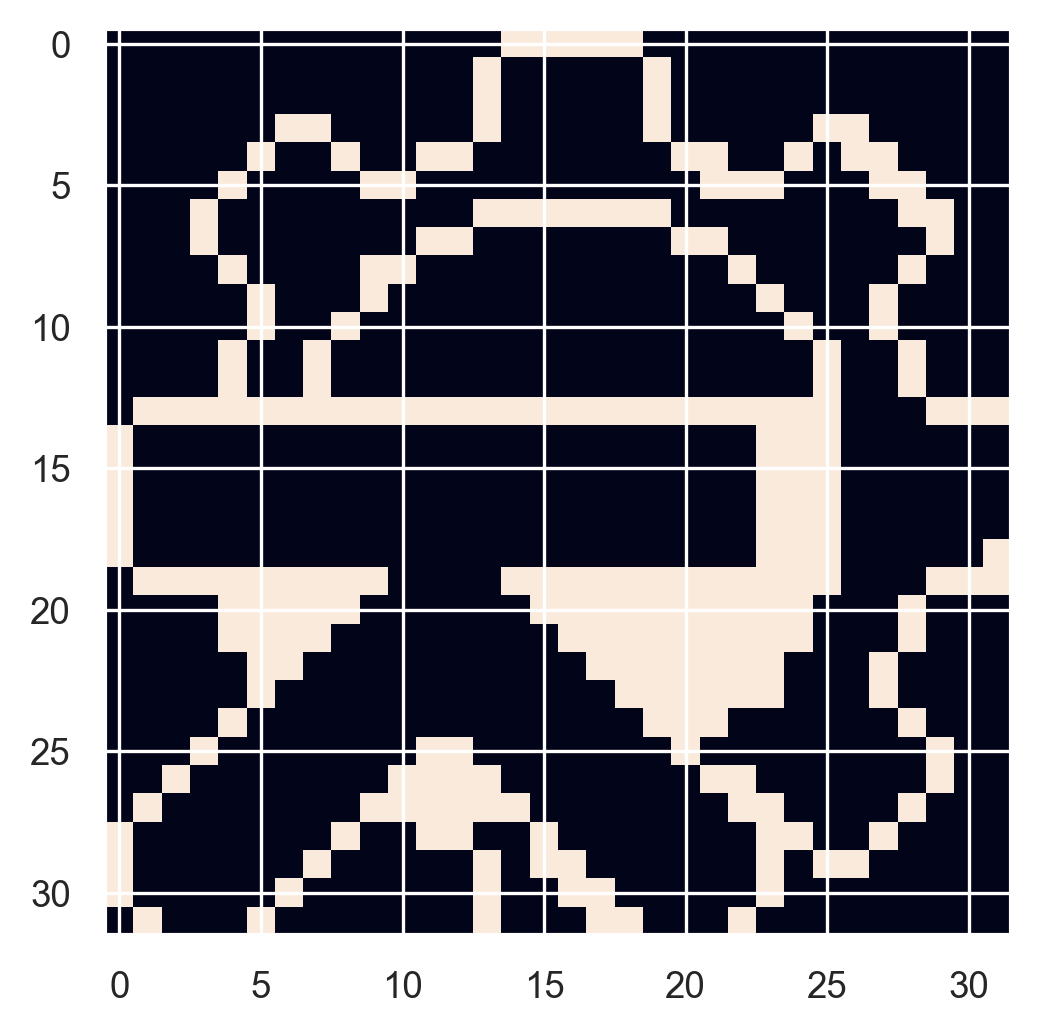

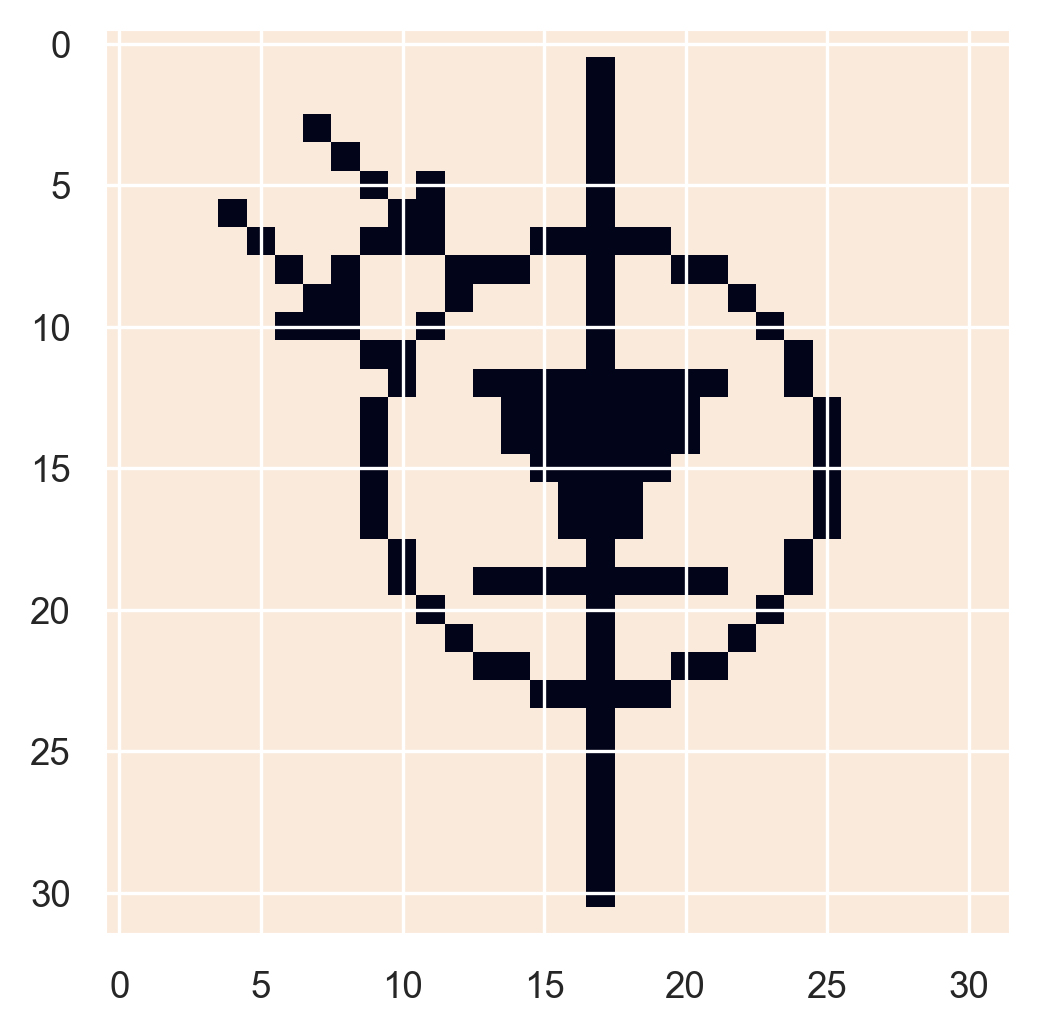

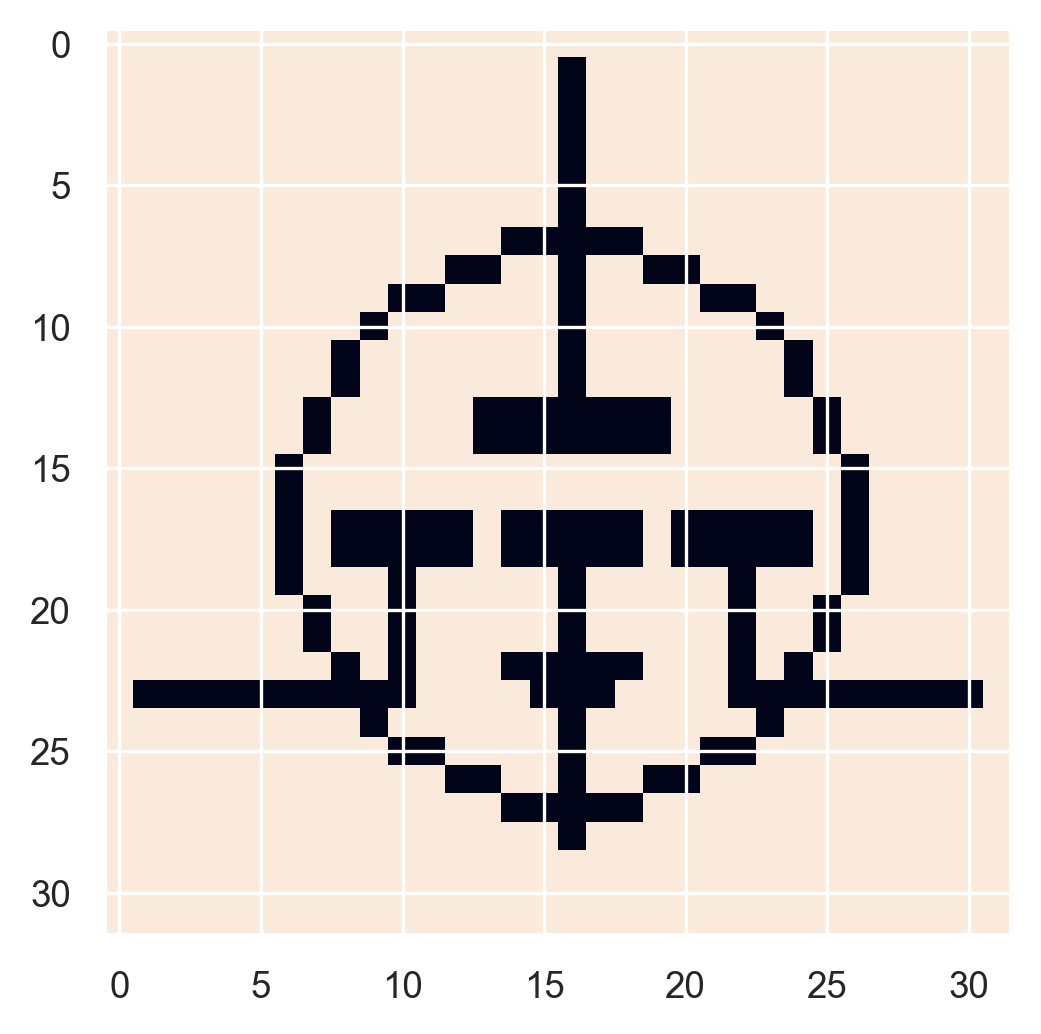

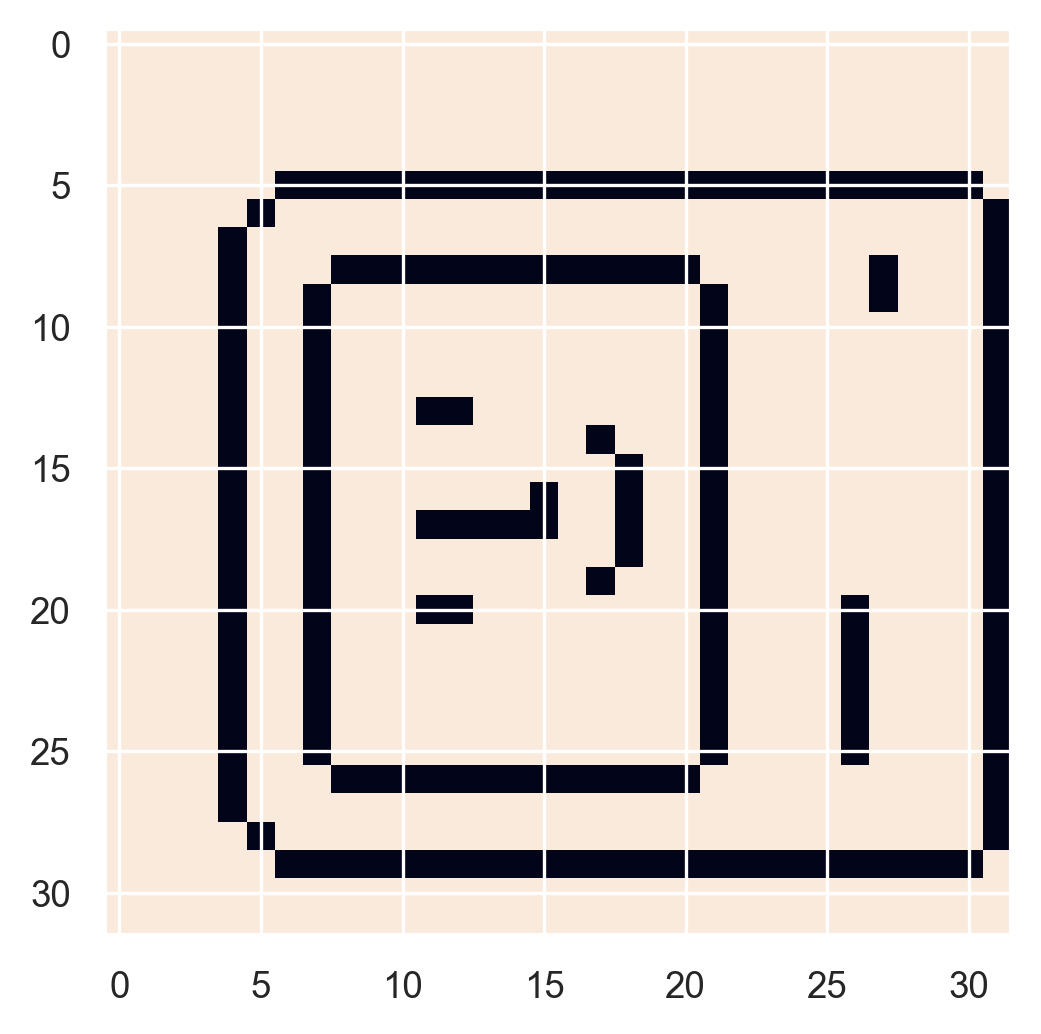

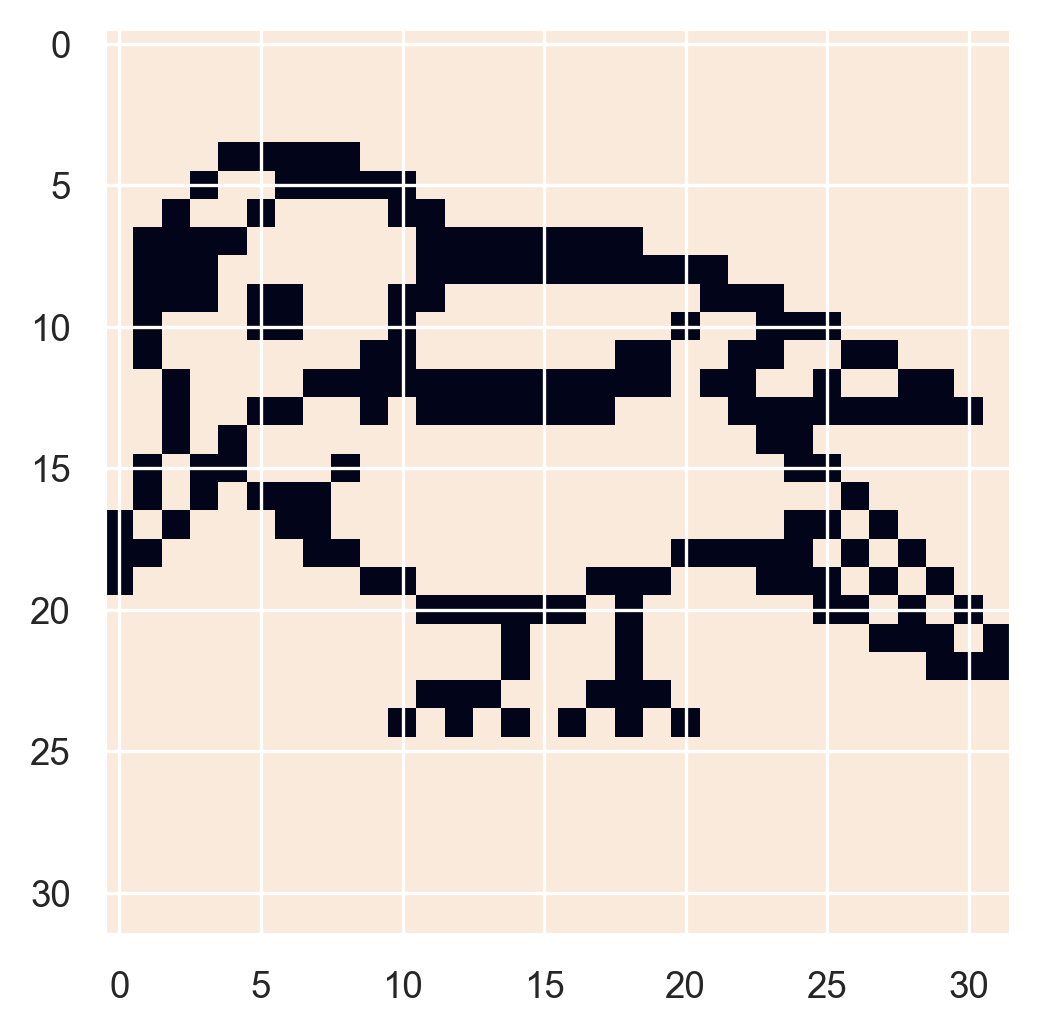

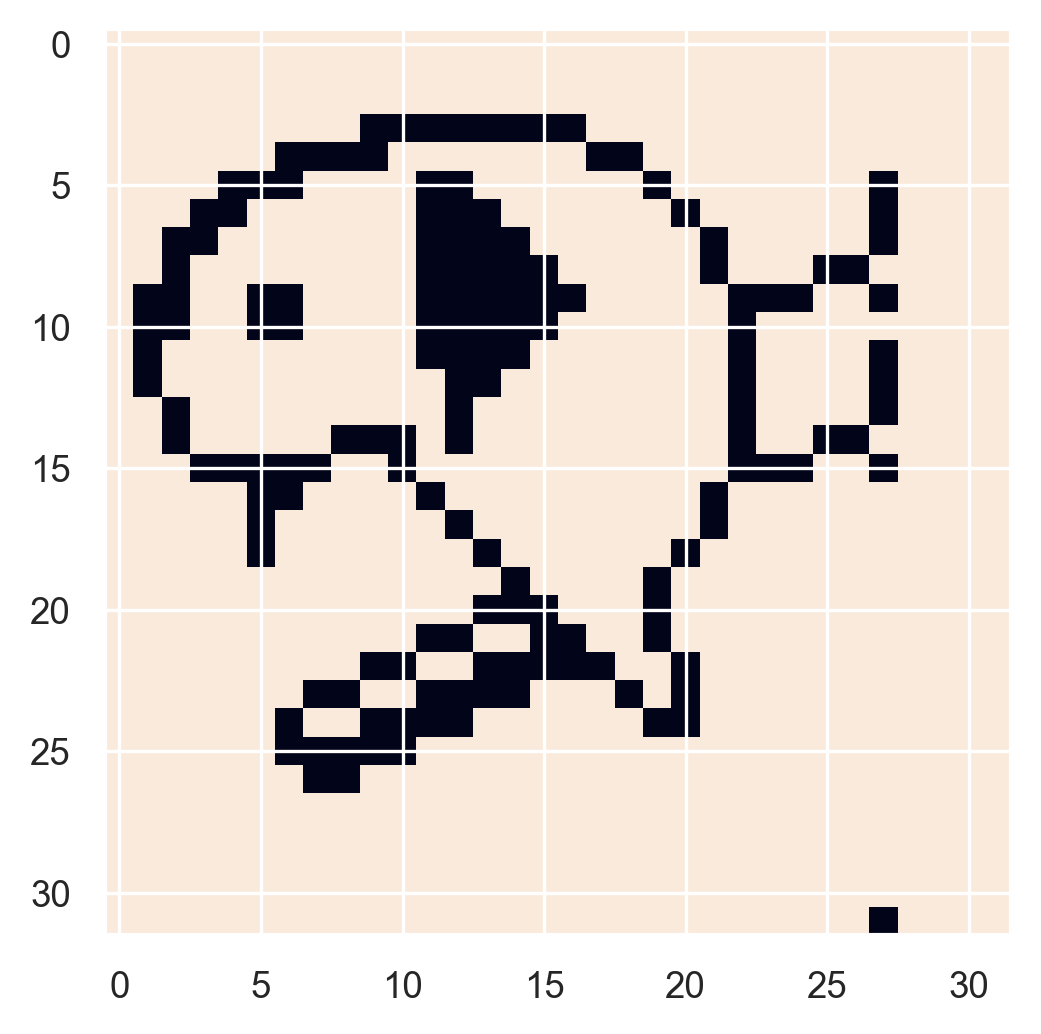

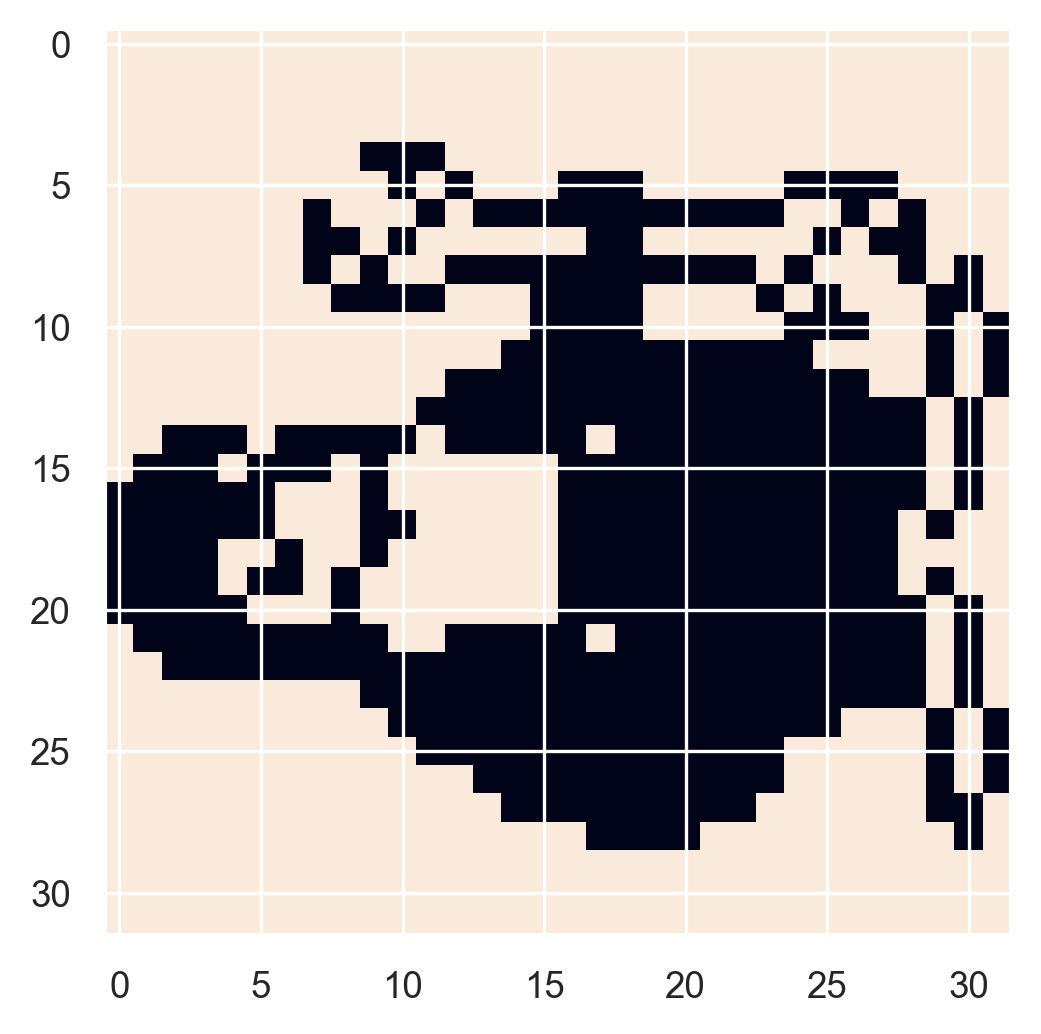

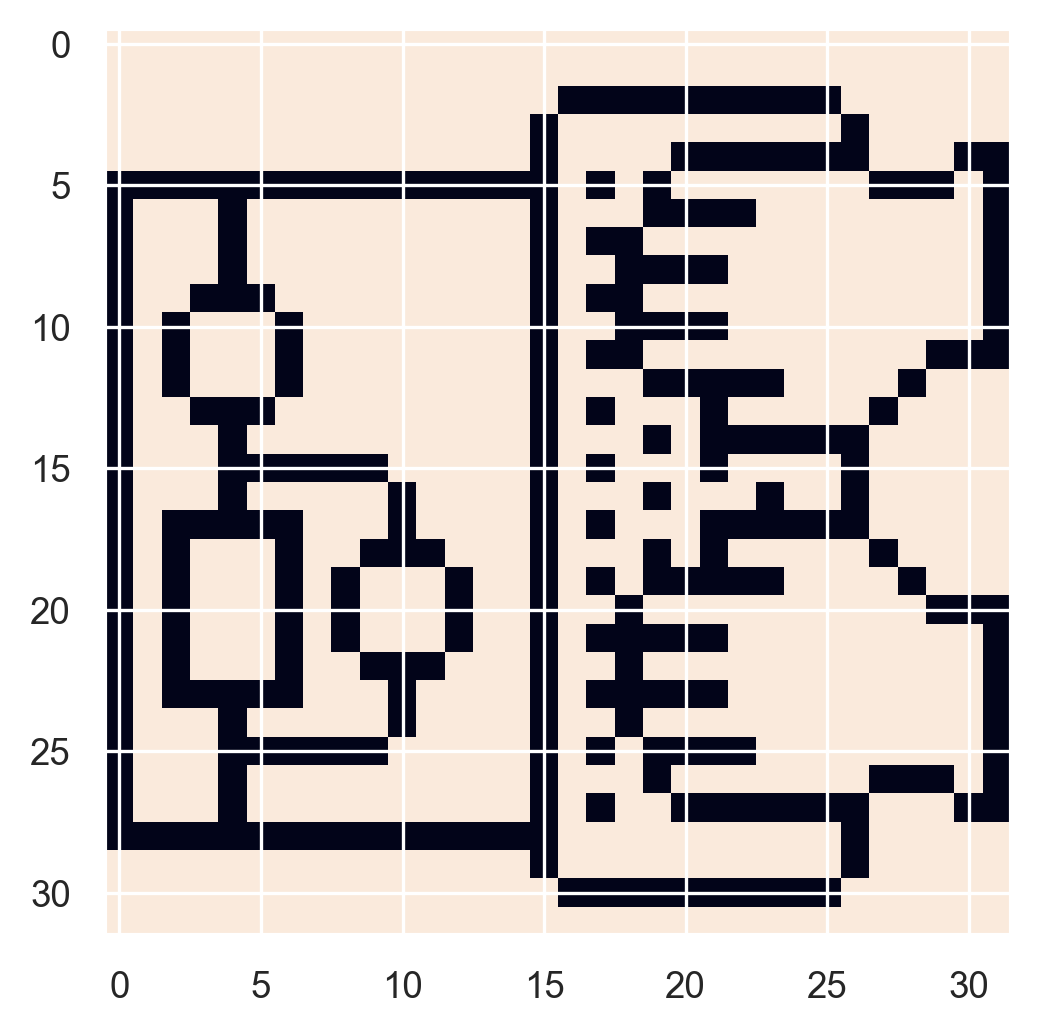

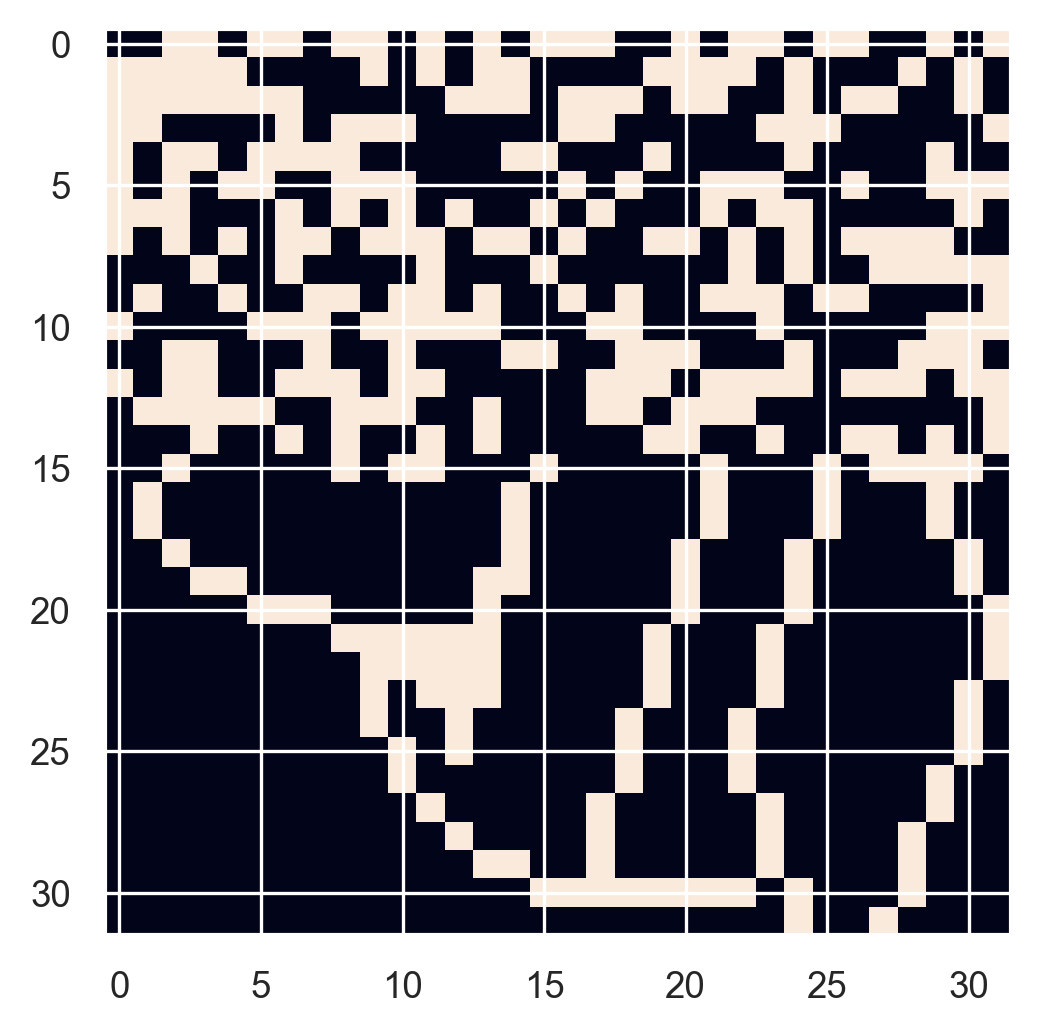

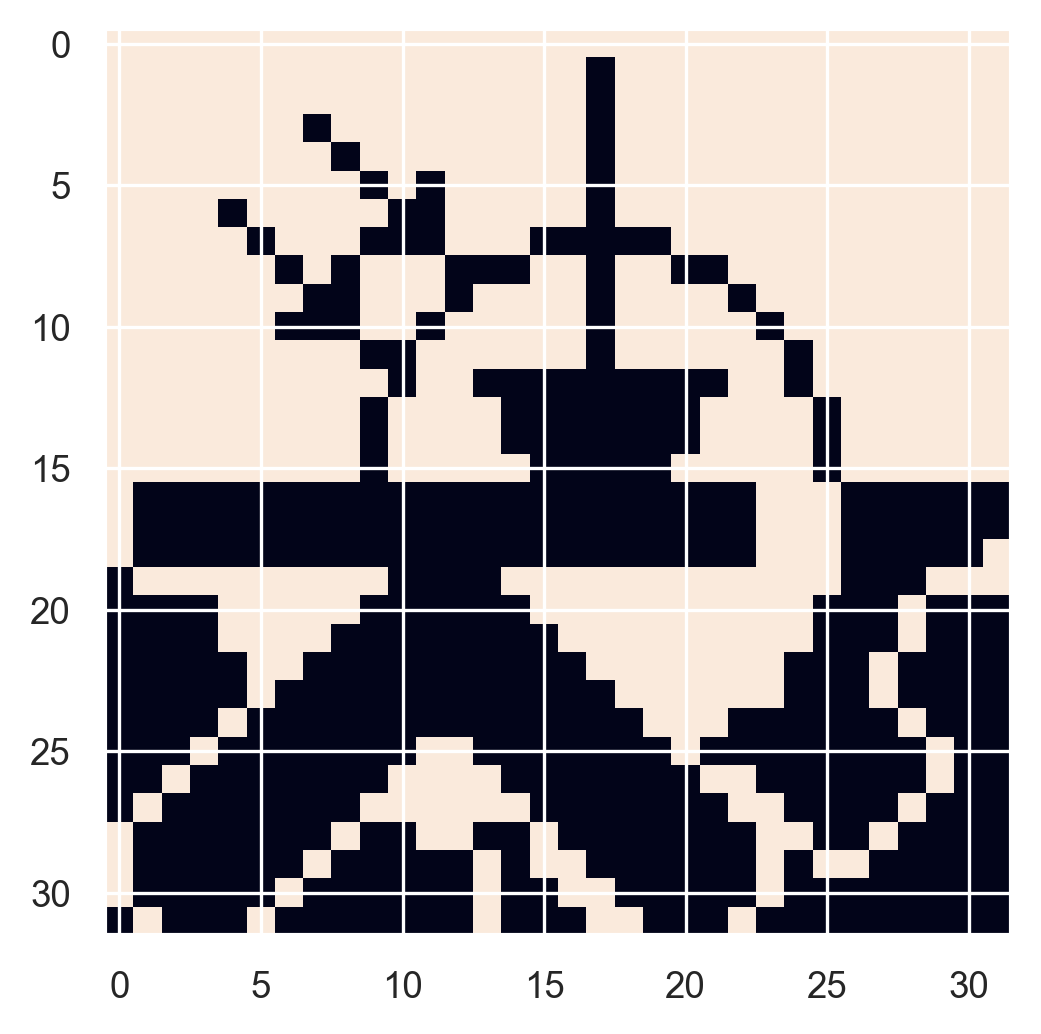

In [2]:
# load data
patterns = np.loadtxt('pict.dat', delimiter=',', dtype='int32').reshape((11, 1024))
for pattern in patterns:
    p = pattern.copy().reshape((32, 32))
    fig, ax = plt.subplots()
    ax.imshow(p)
    plt.show()

In [3]:
nn.train(patterns[:3, :])

# make sure patterns are stable
Xp = nn.recall(patterns[:3, :])
assert np.all(Xp == patterns[:3, :])
print(Xp == patterns[:3, :])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


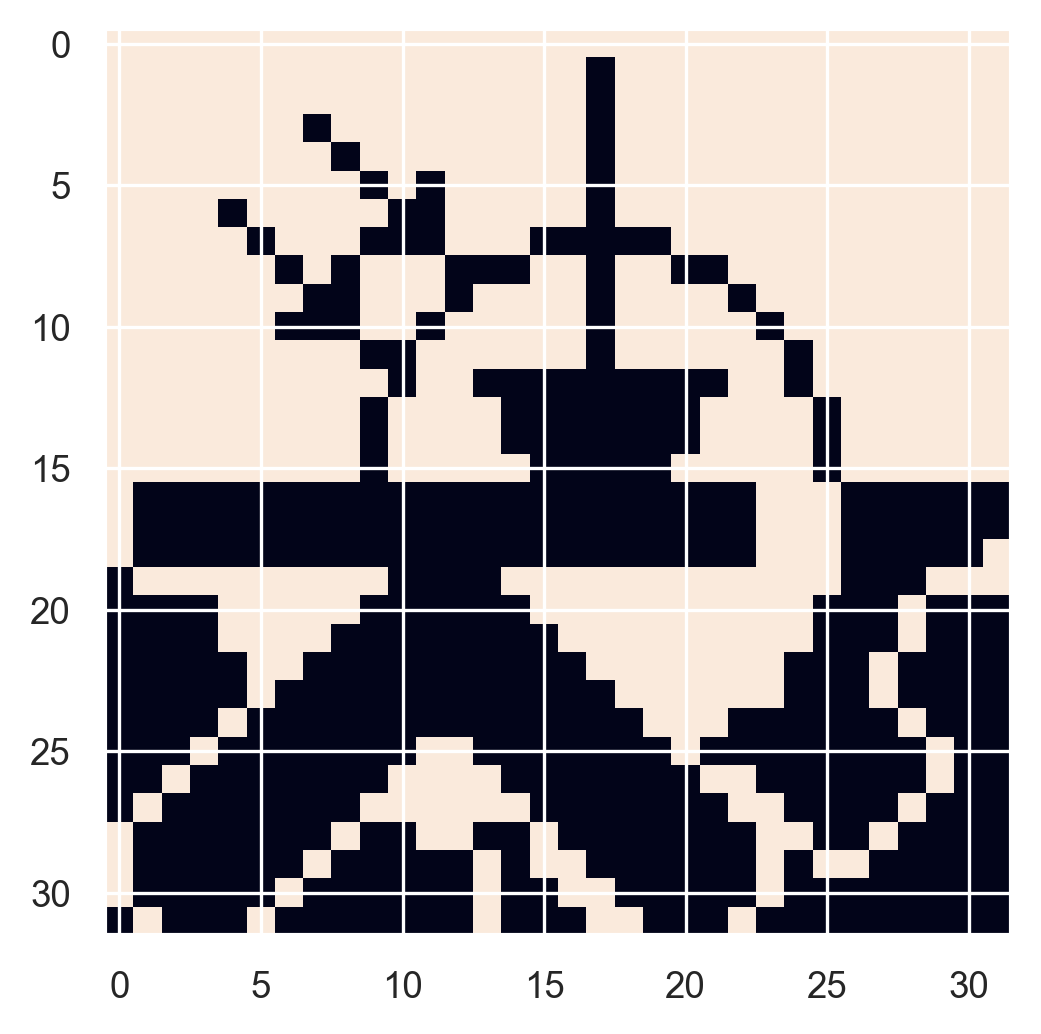

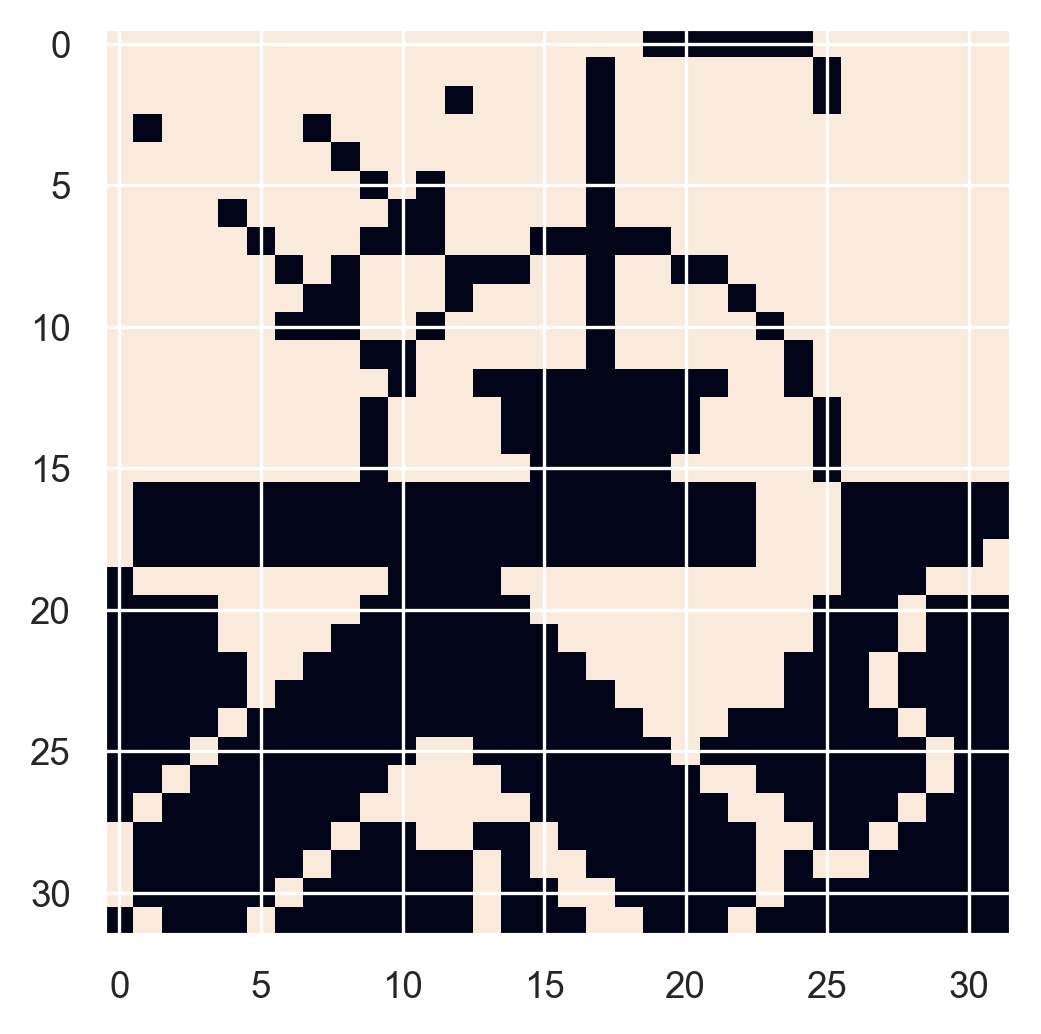

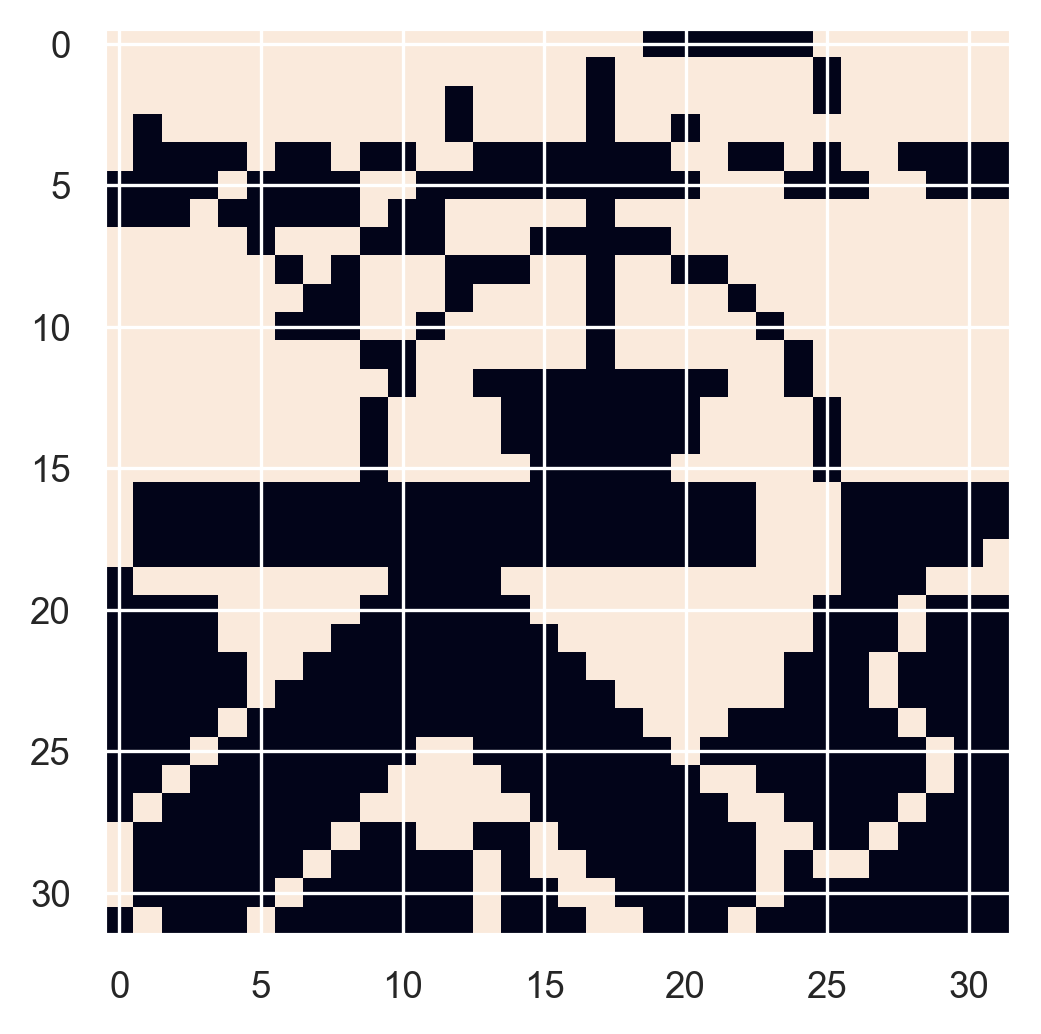

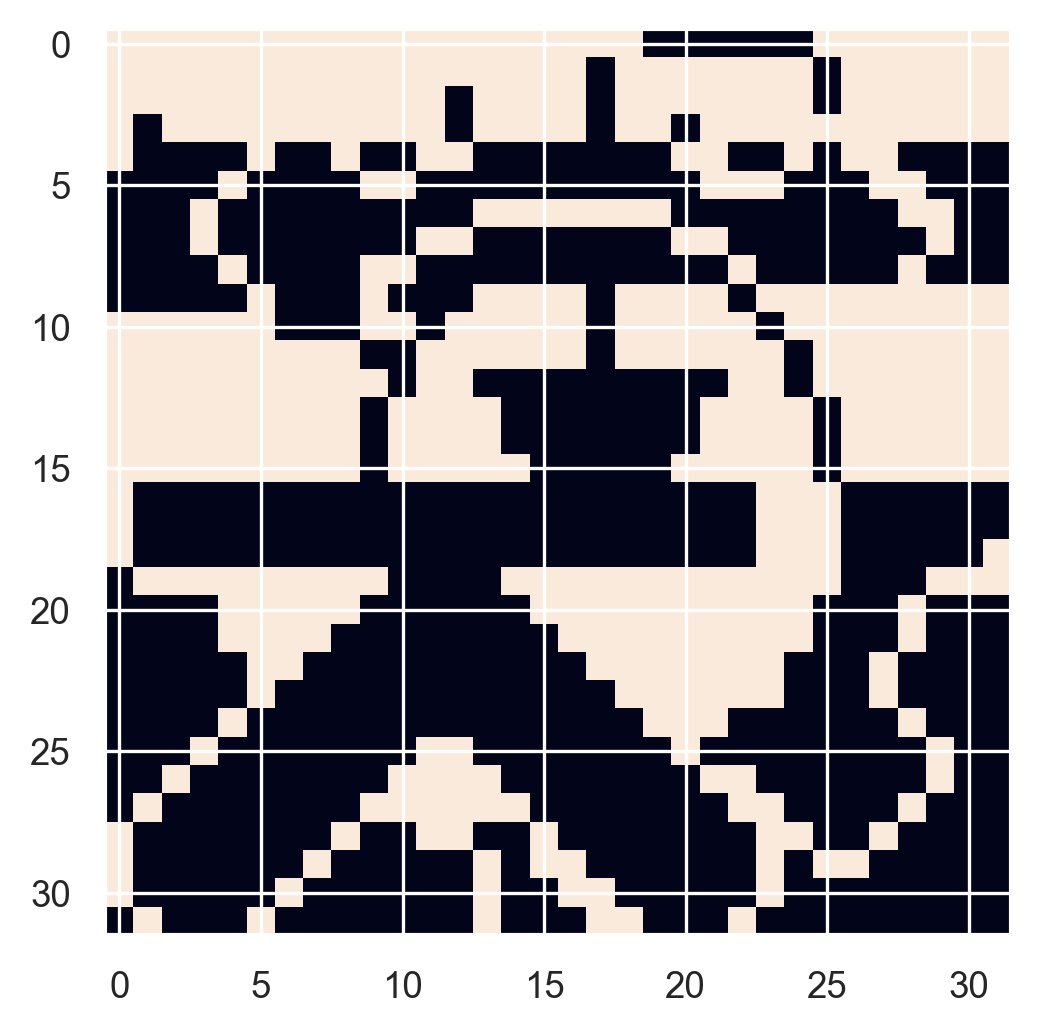

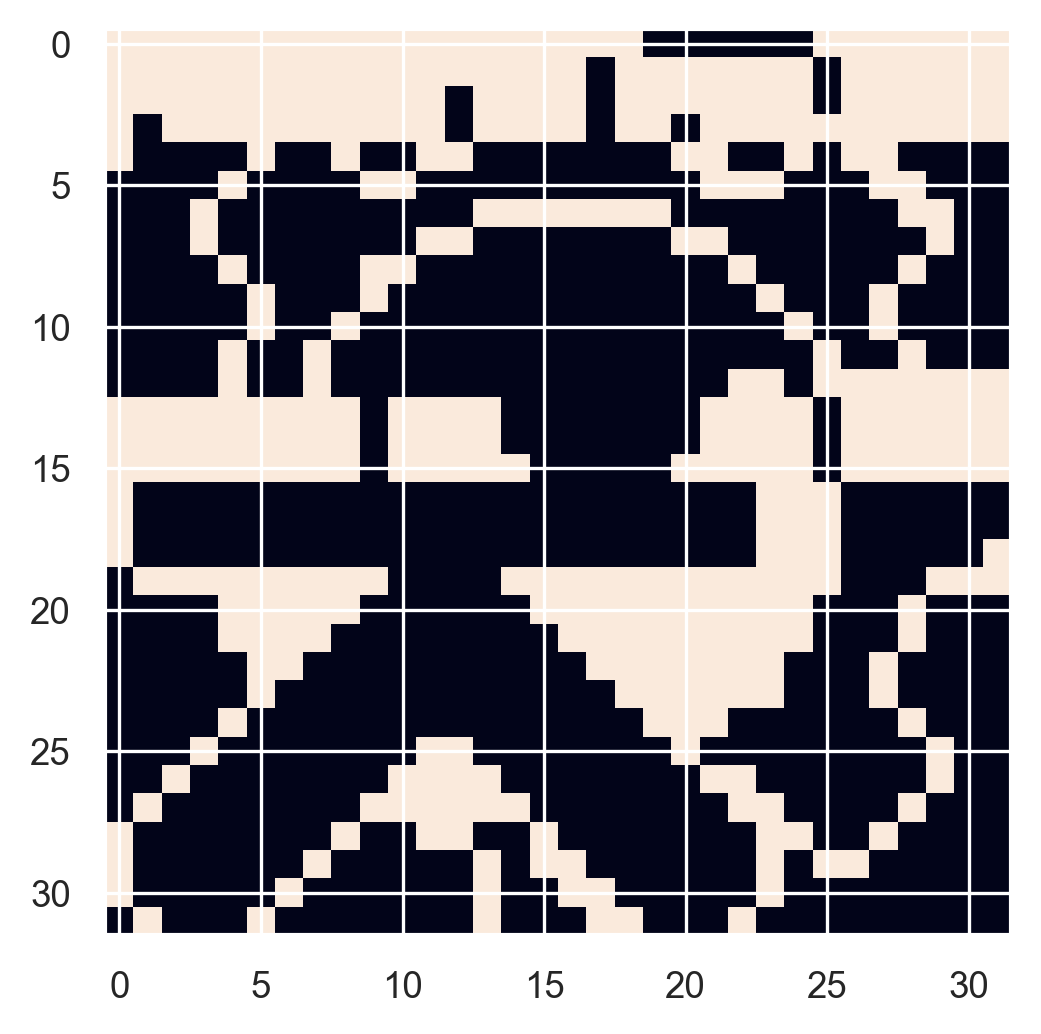

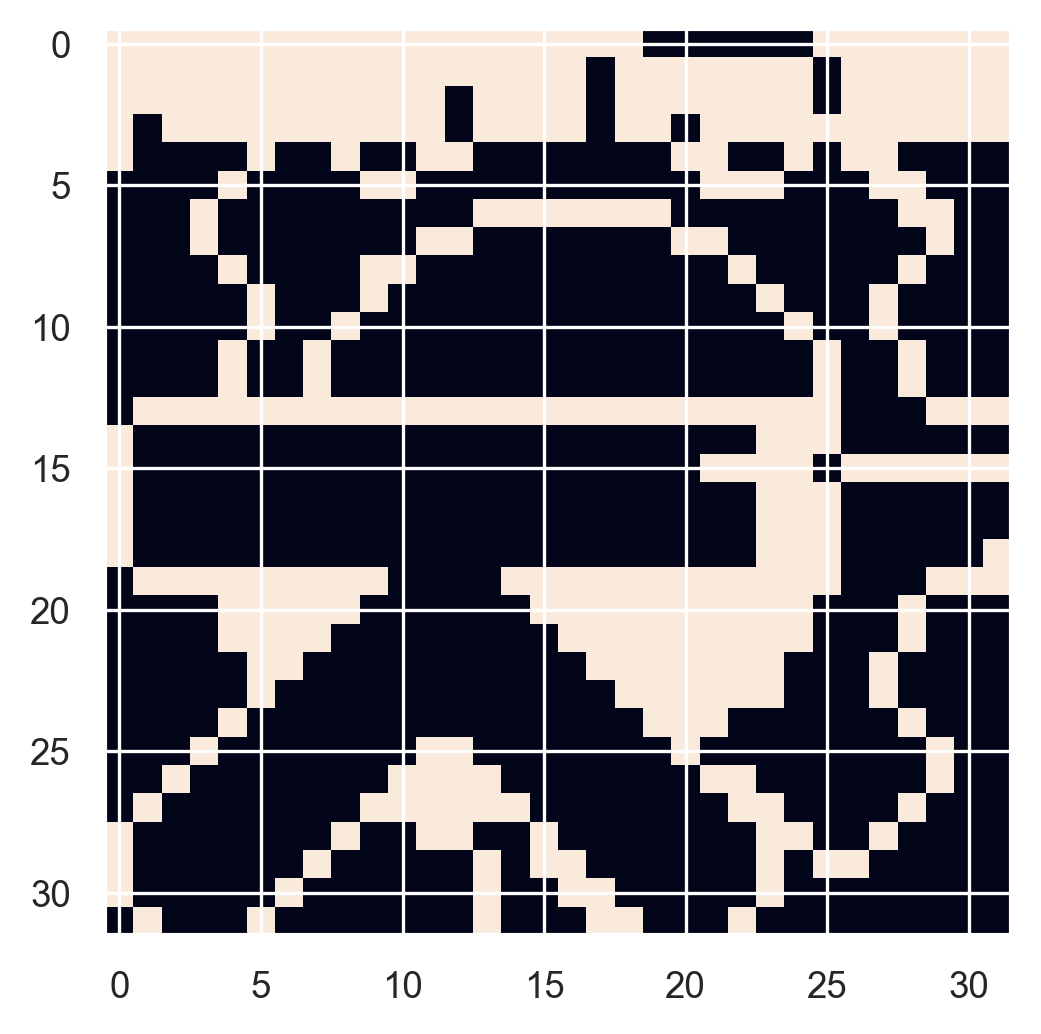

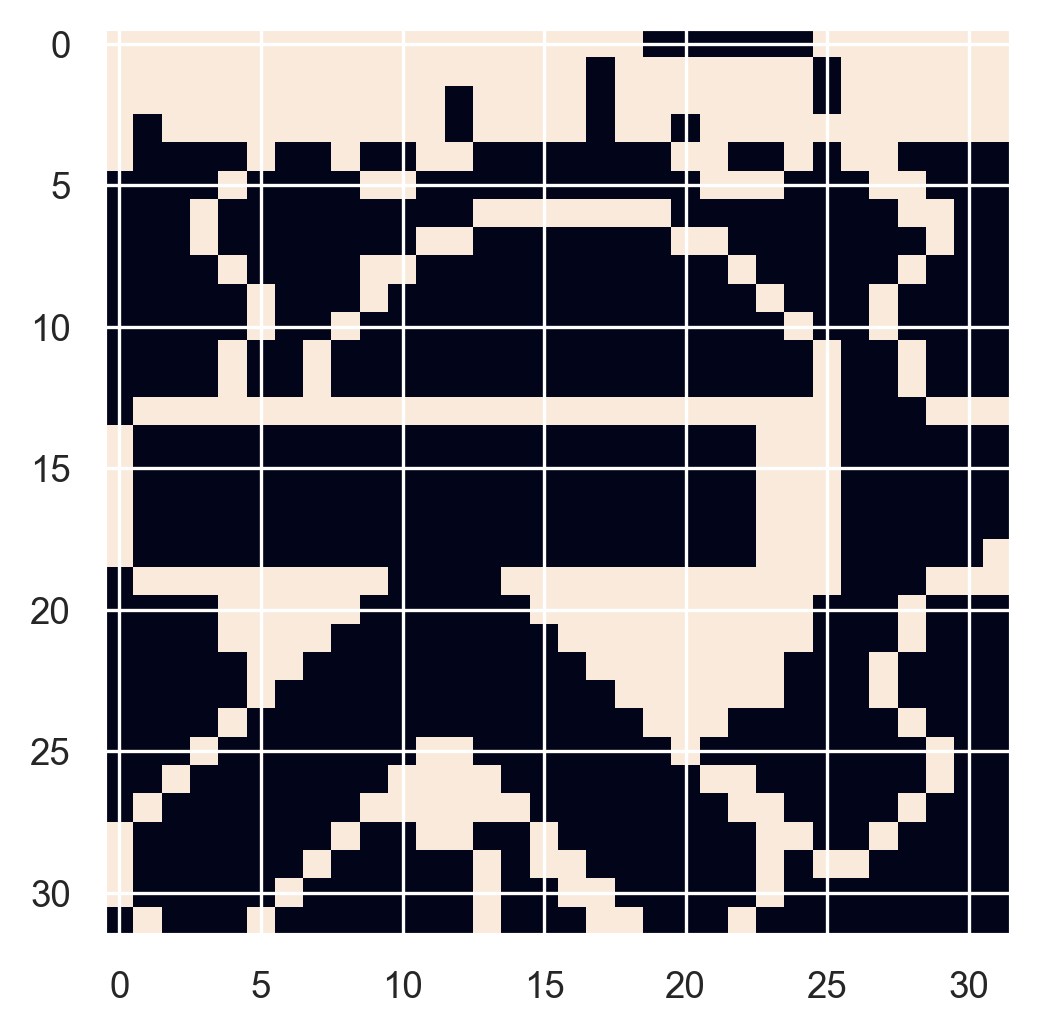

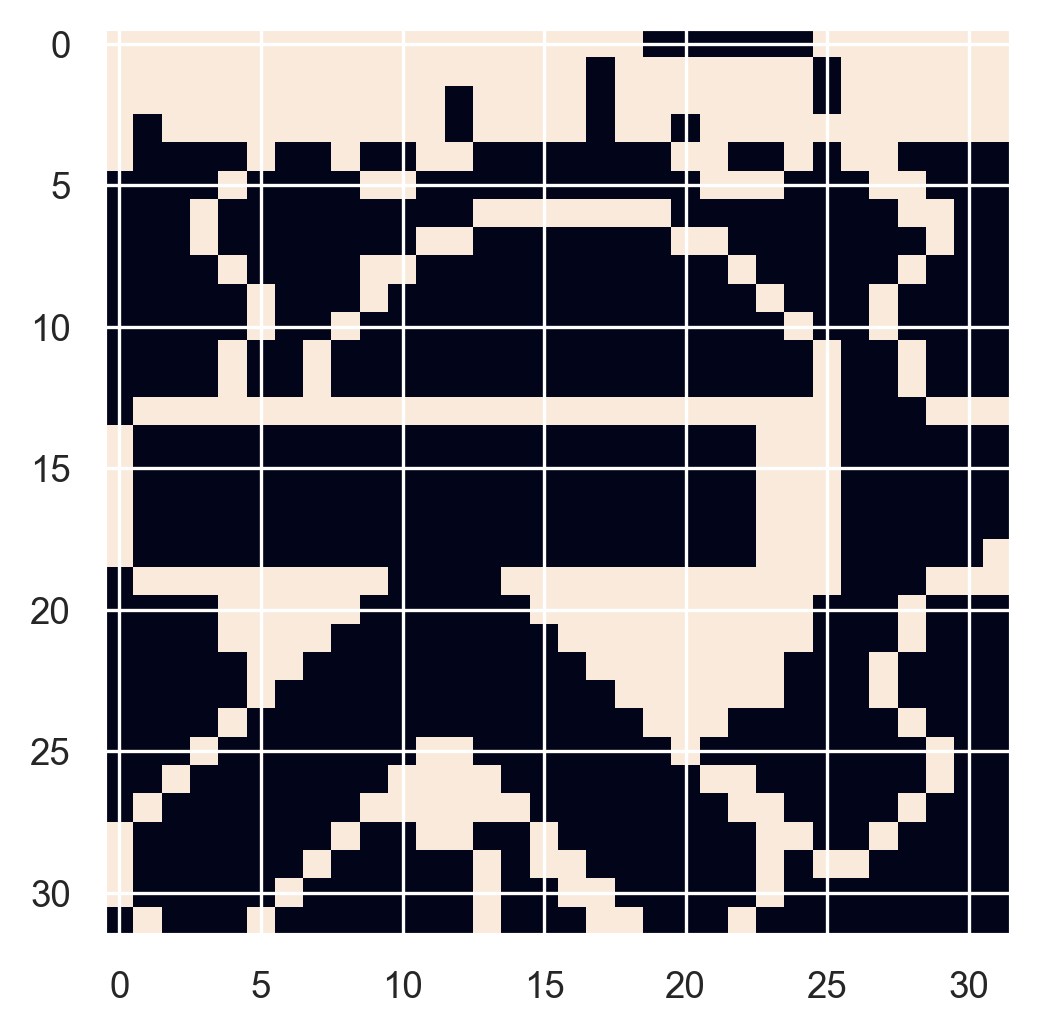

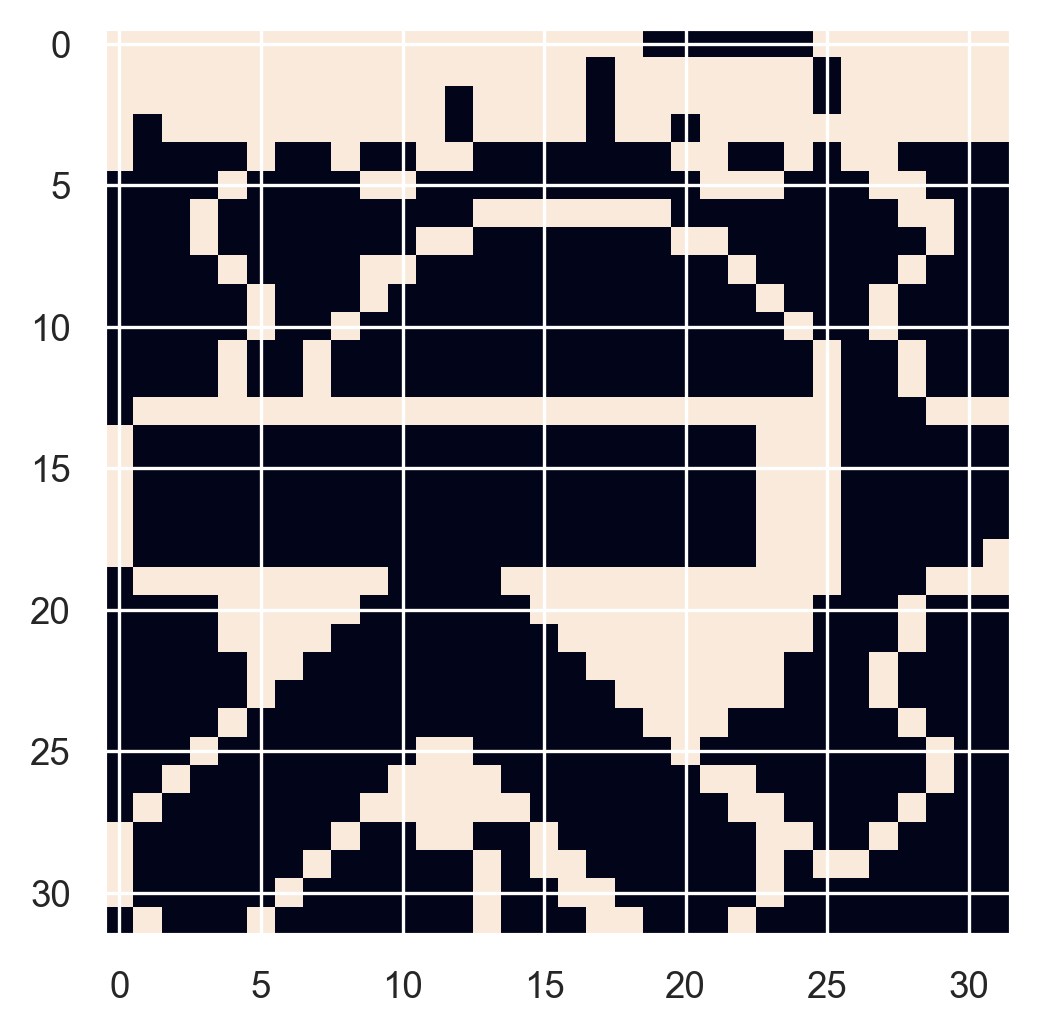

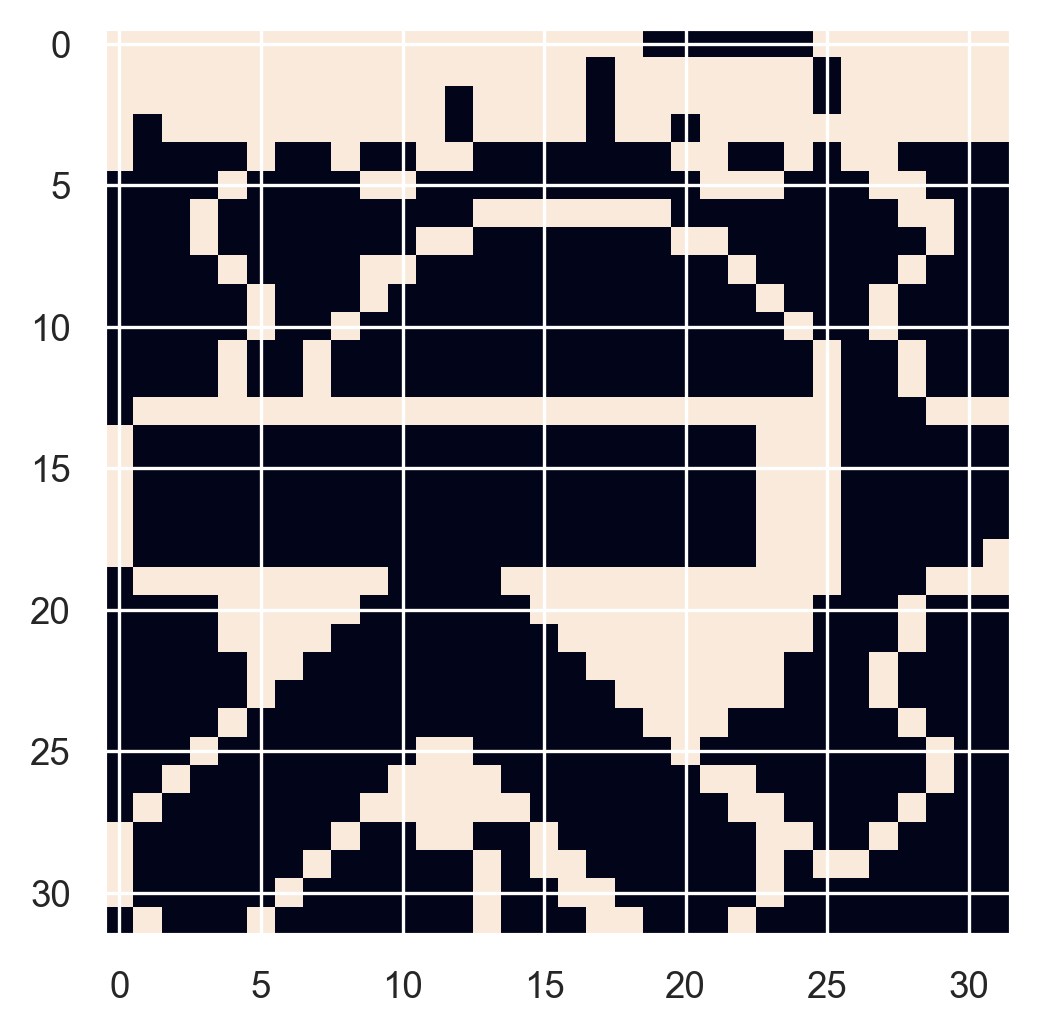

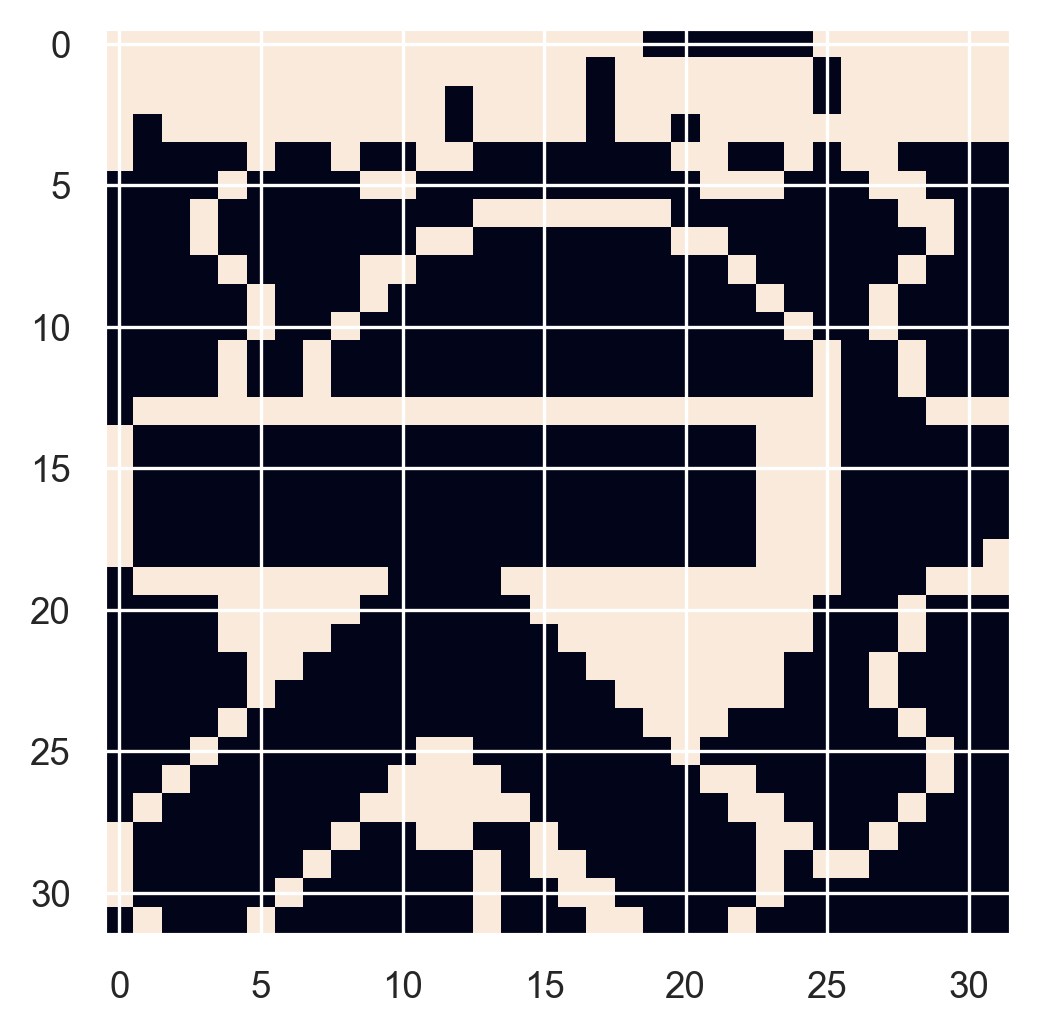

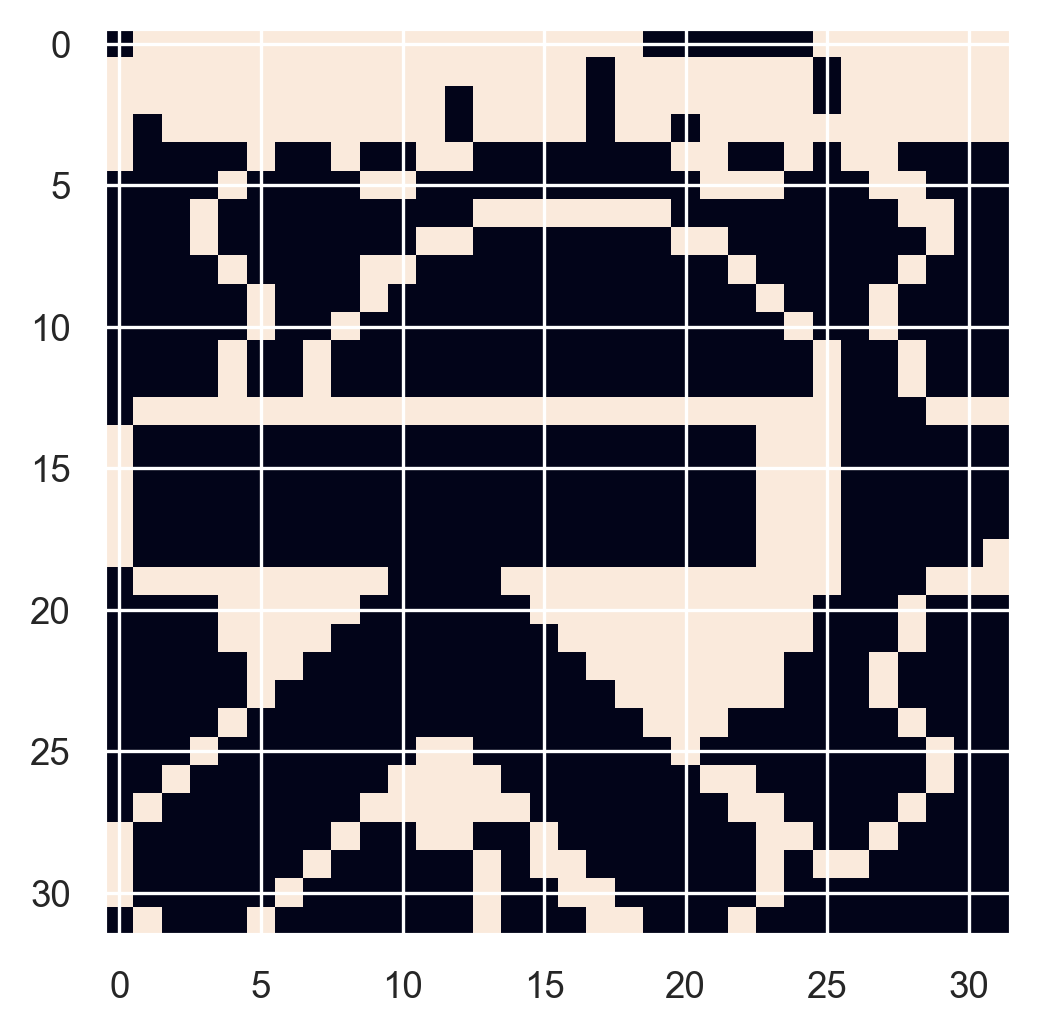

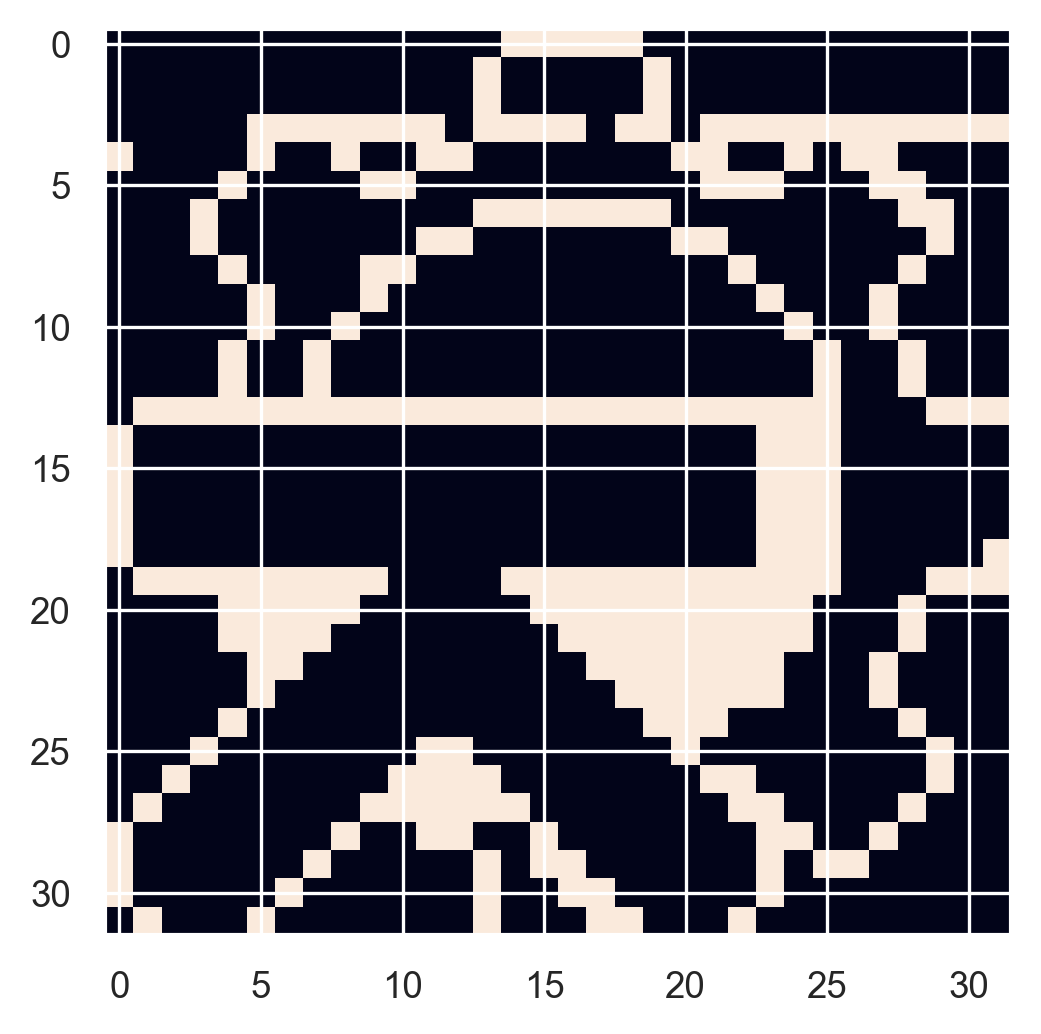

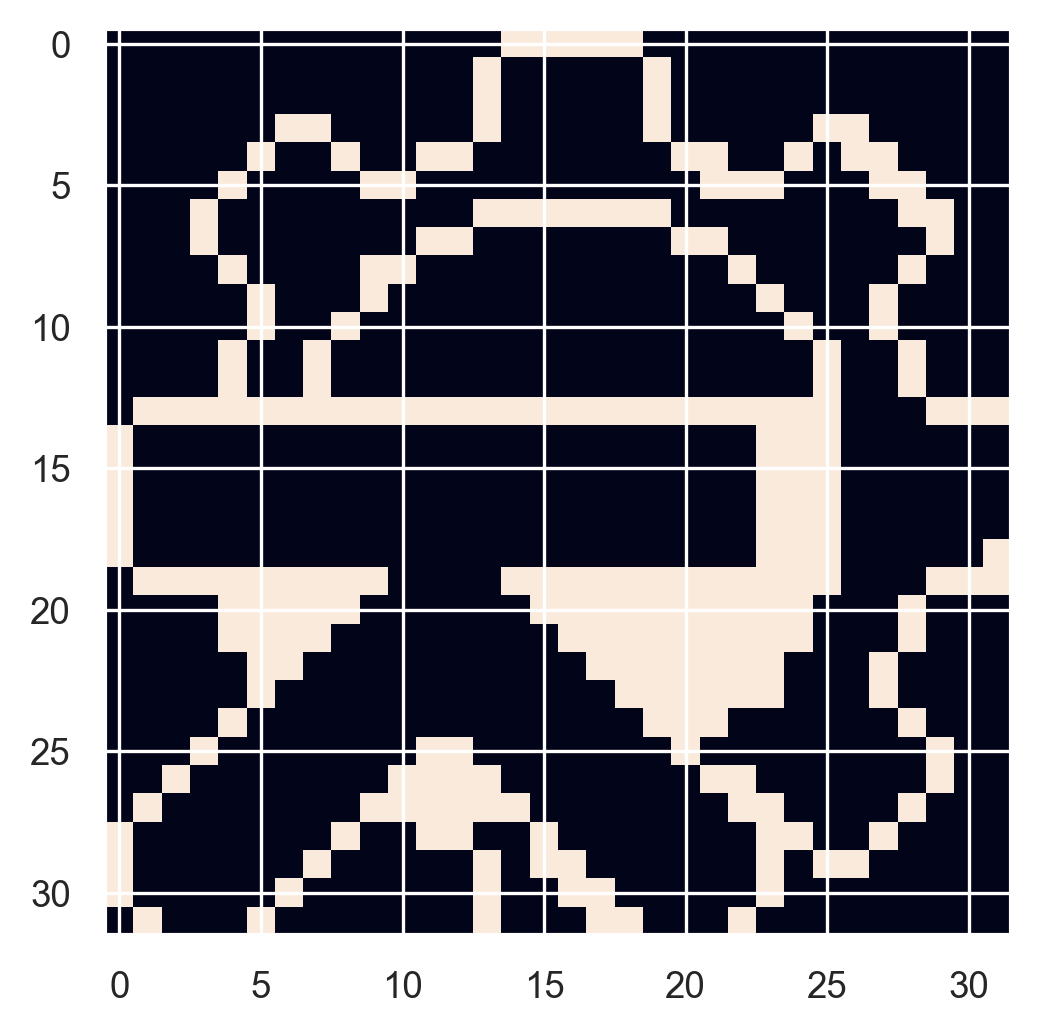

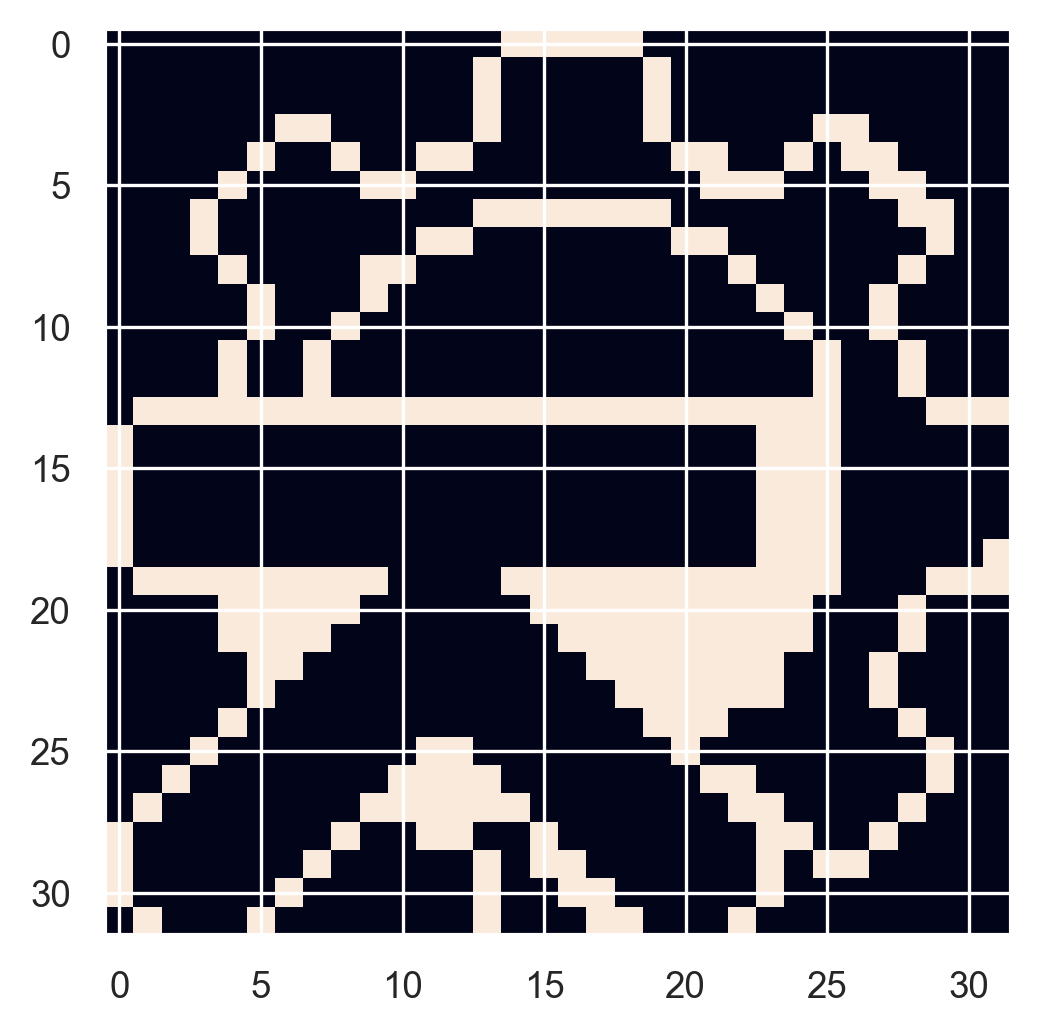

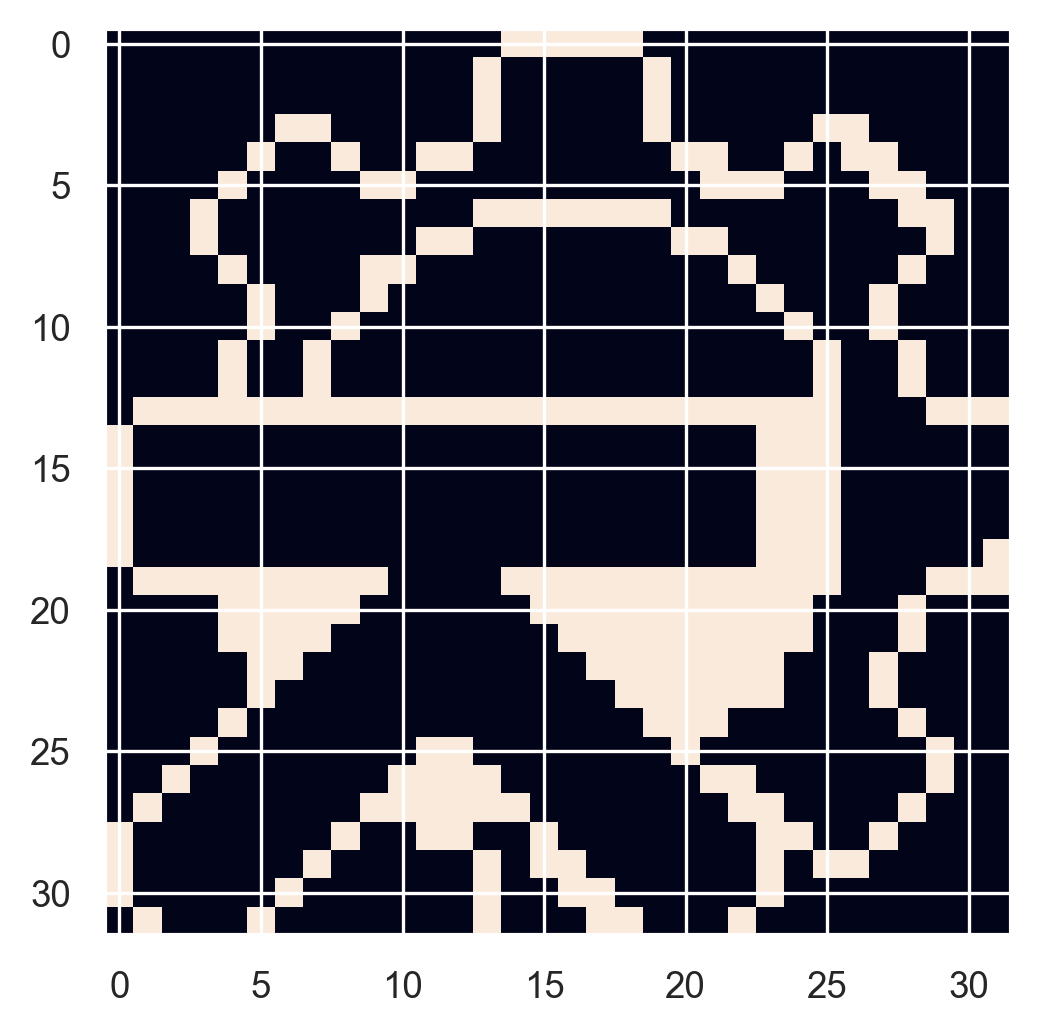

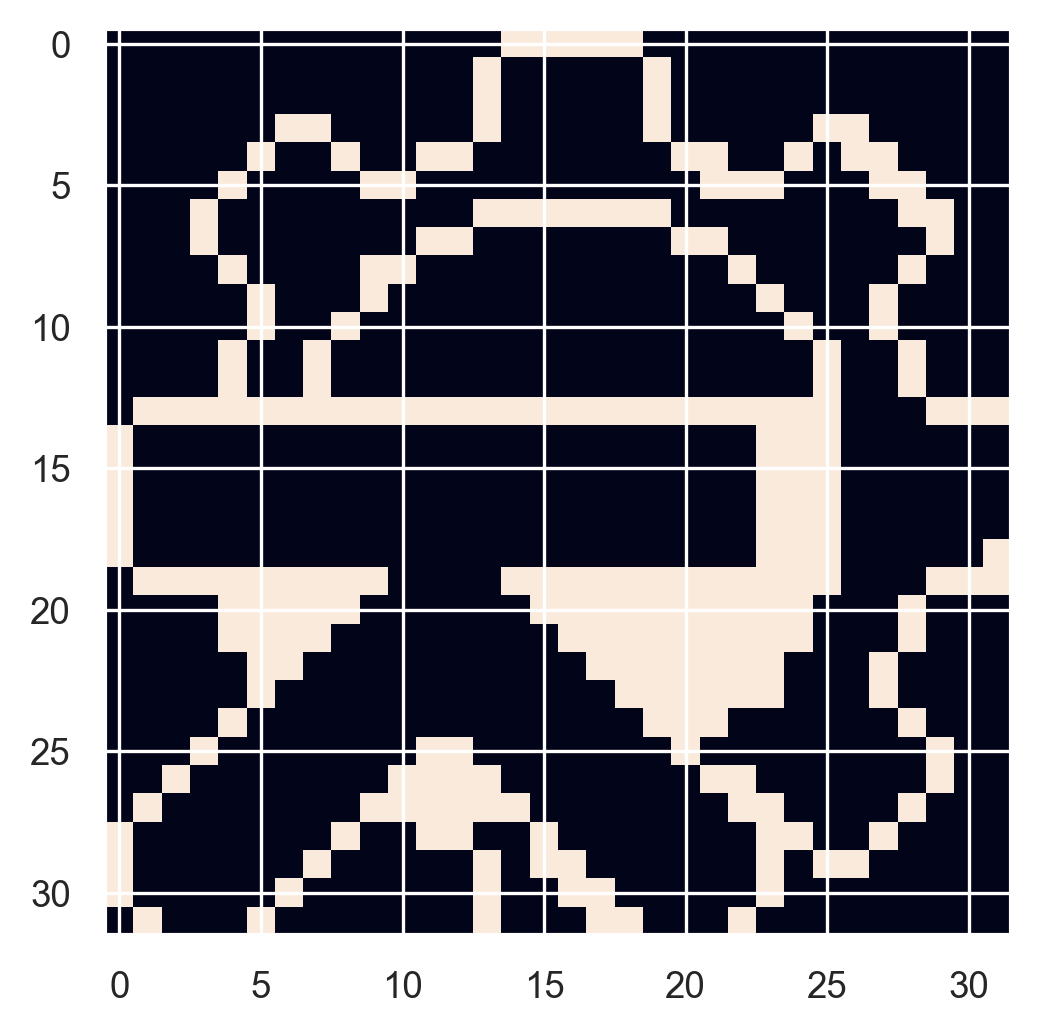

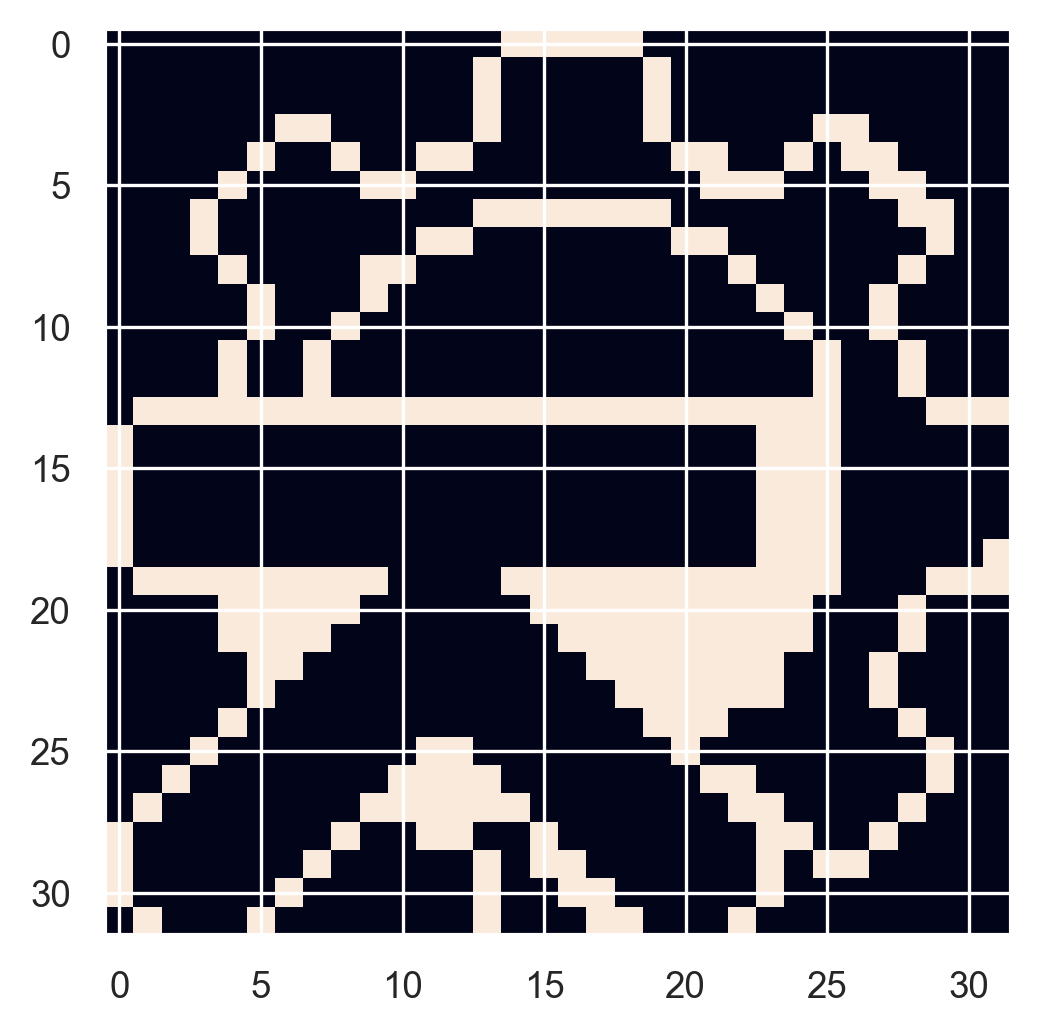

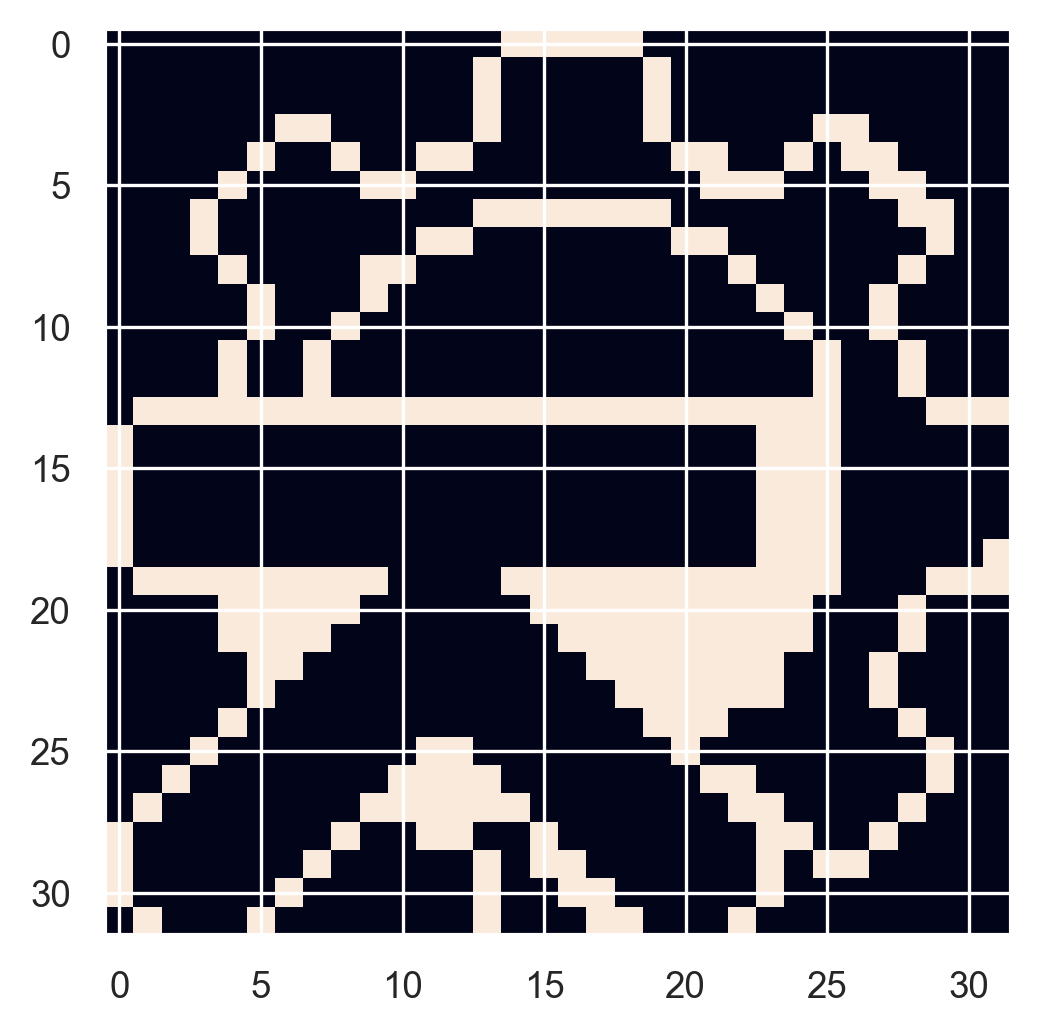

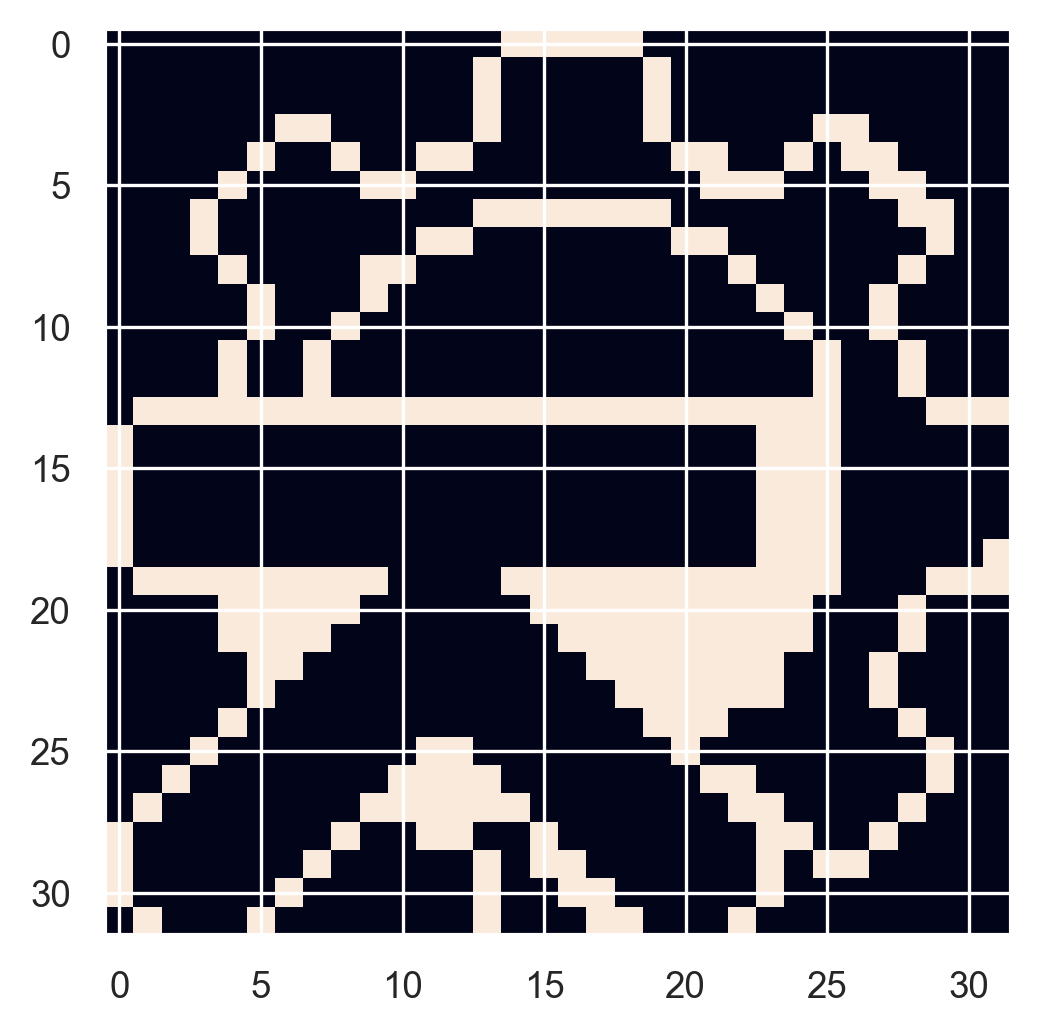

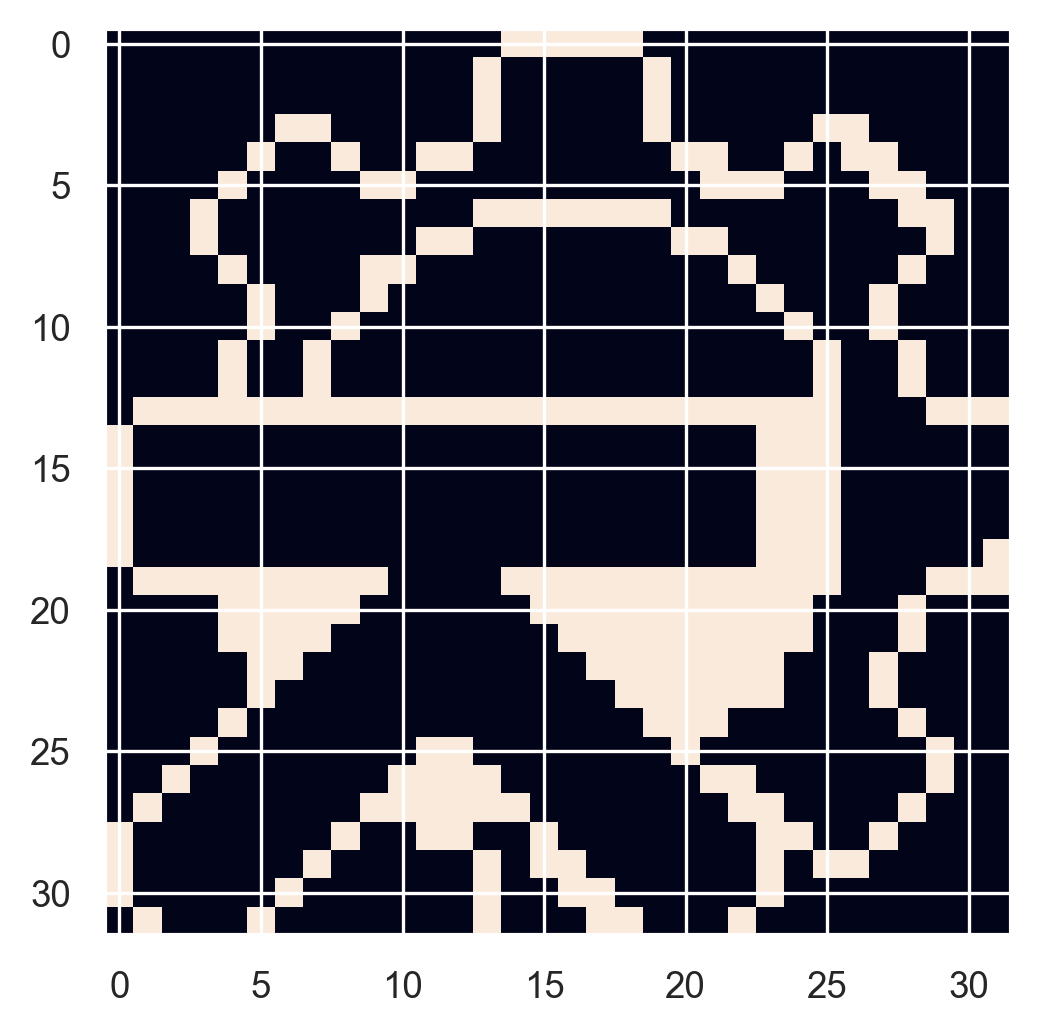

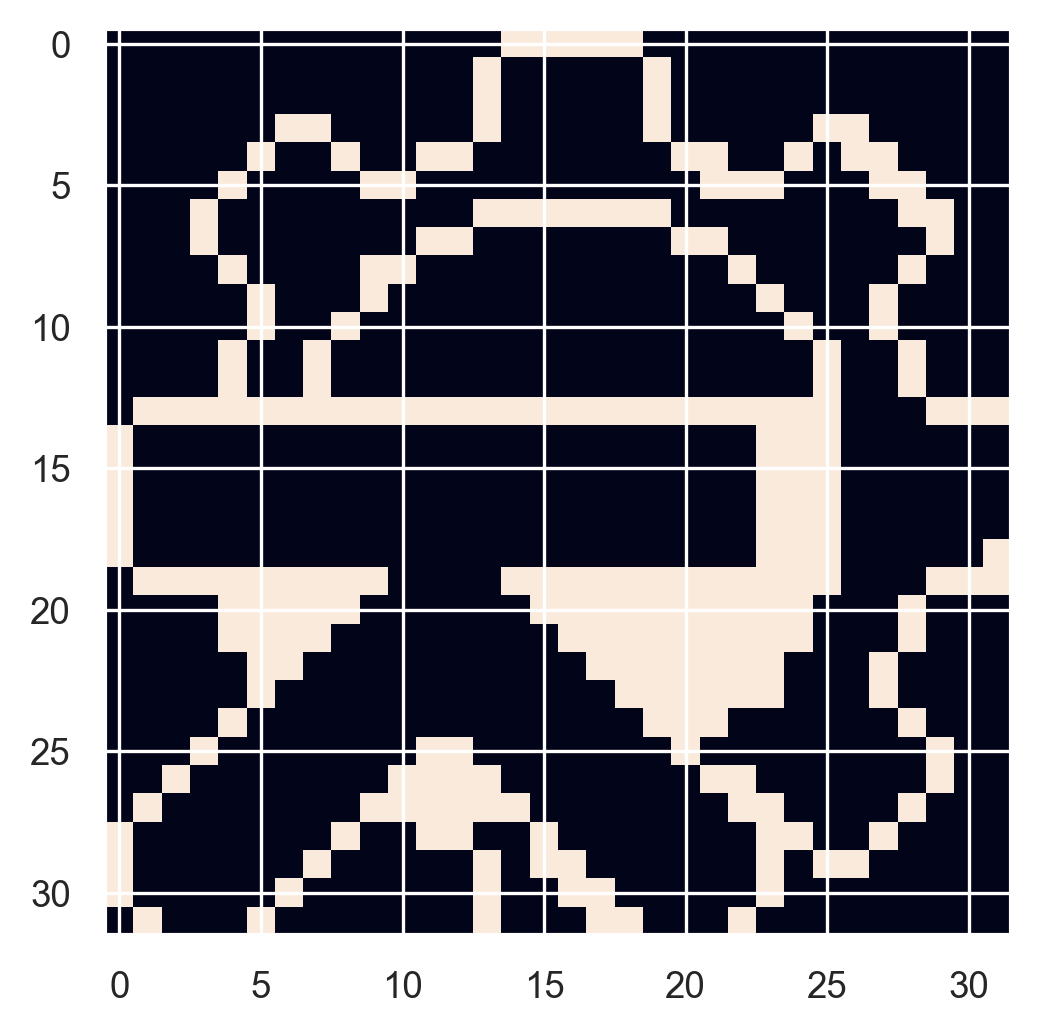

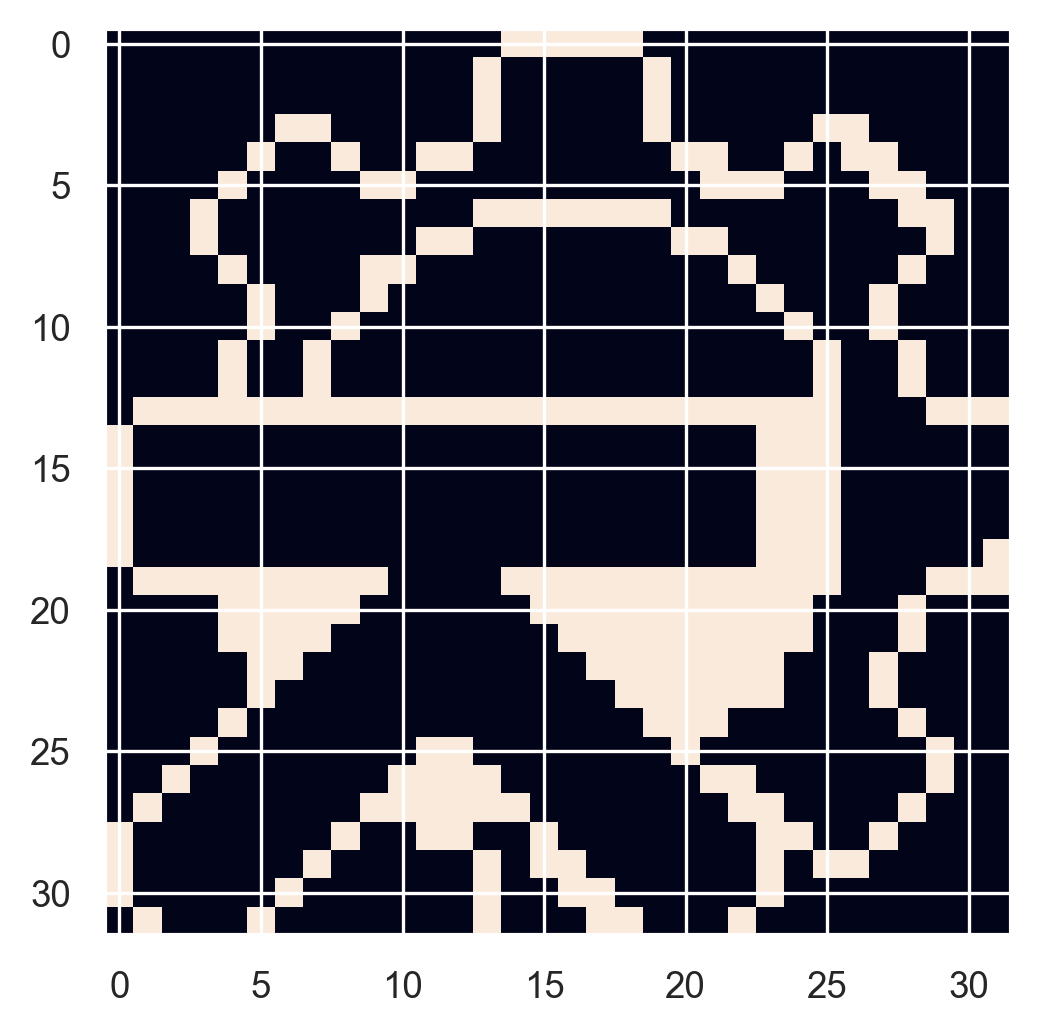

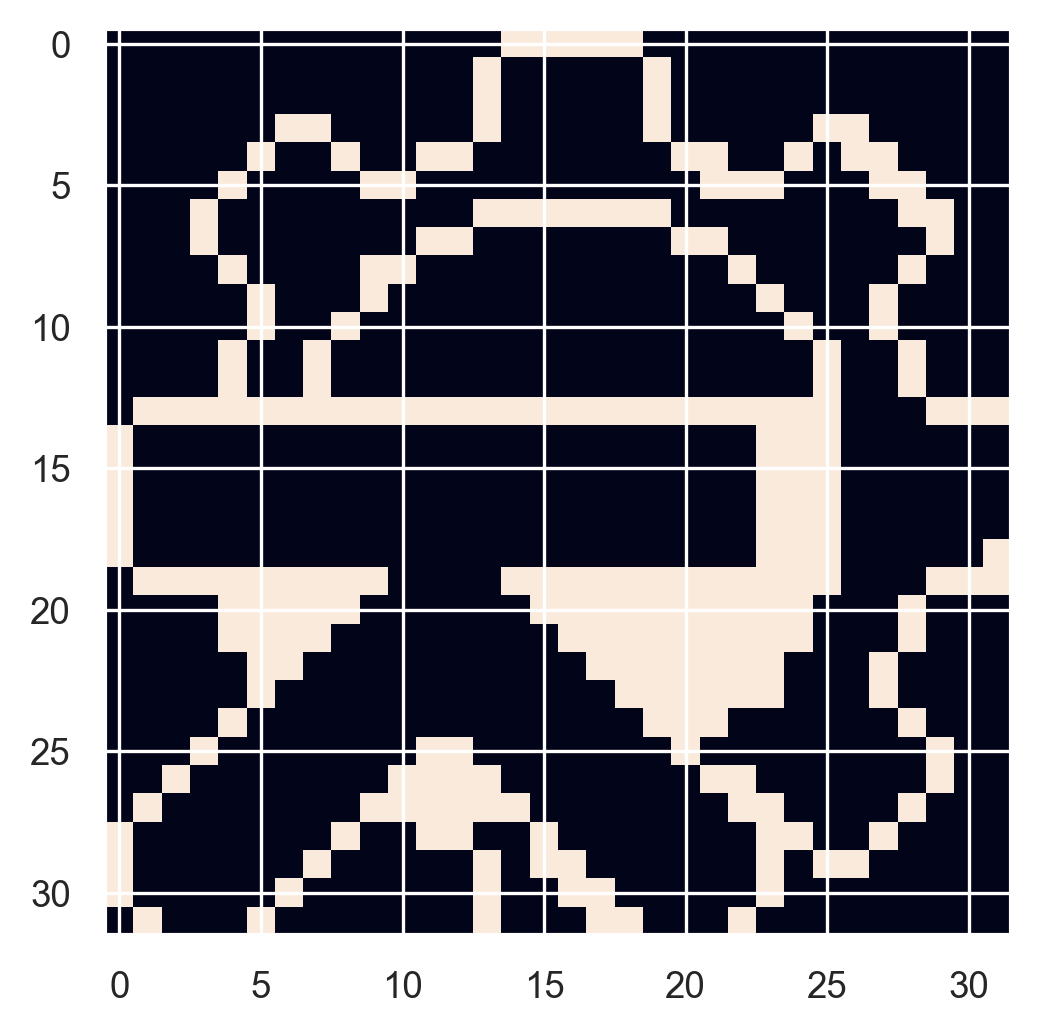

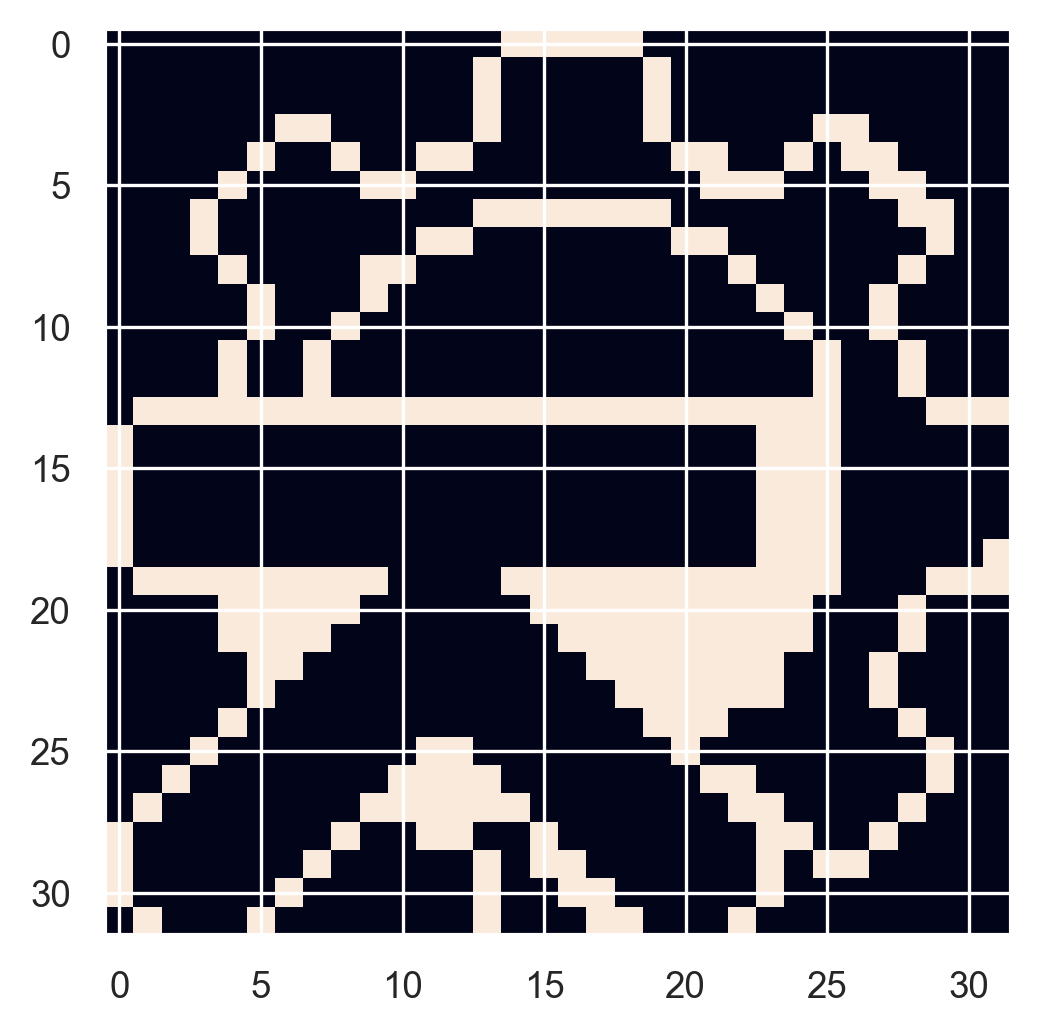

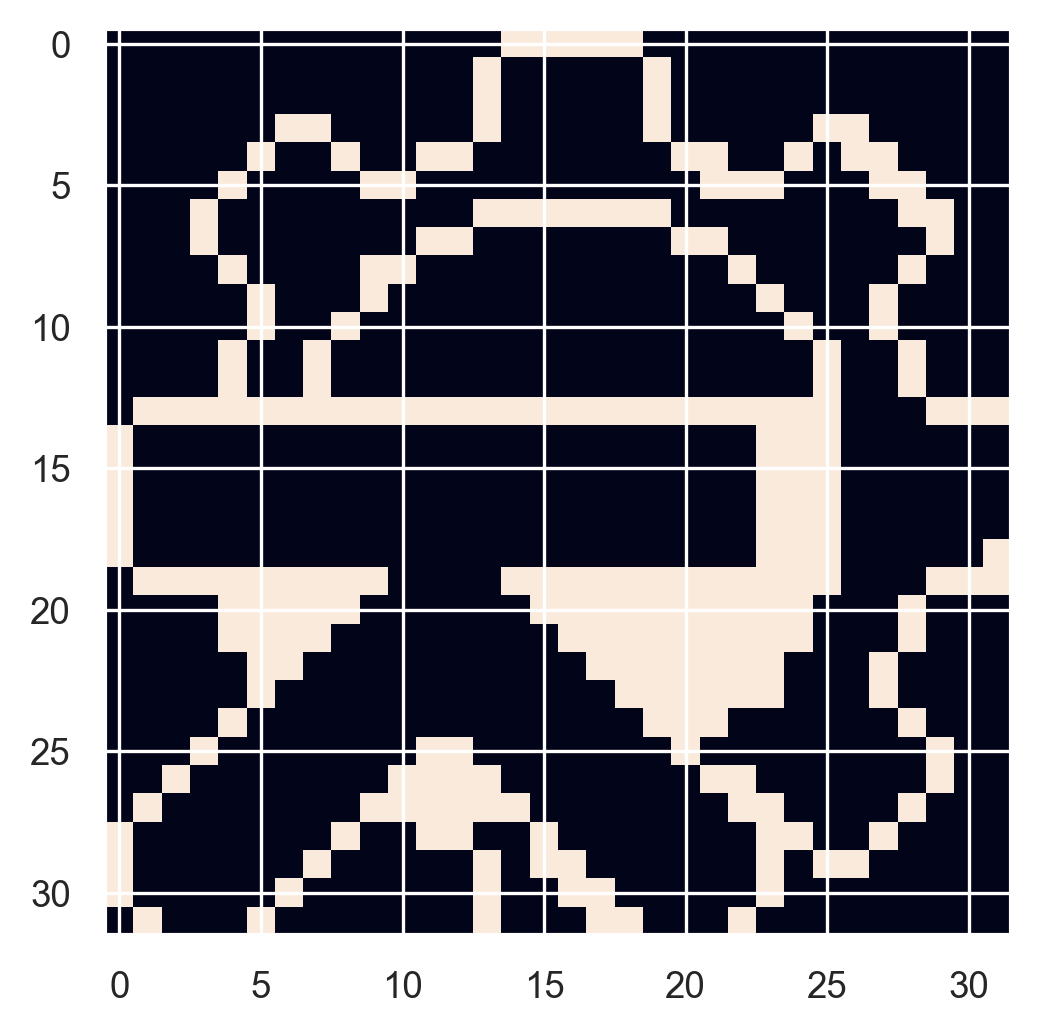

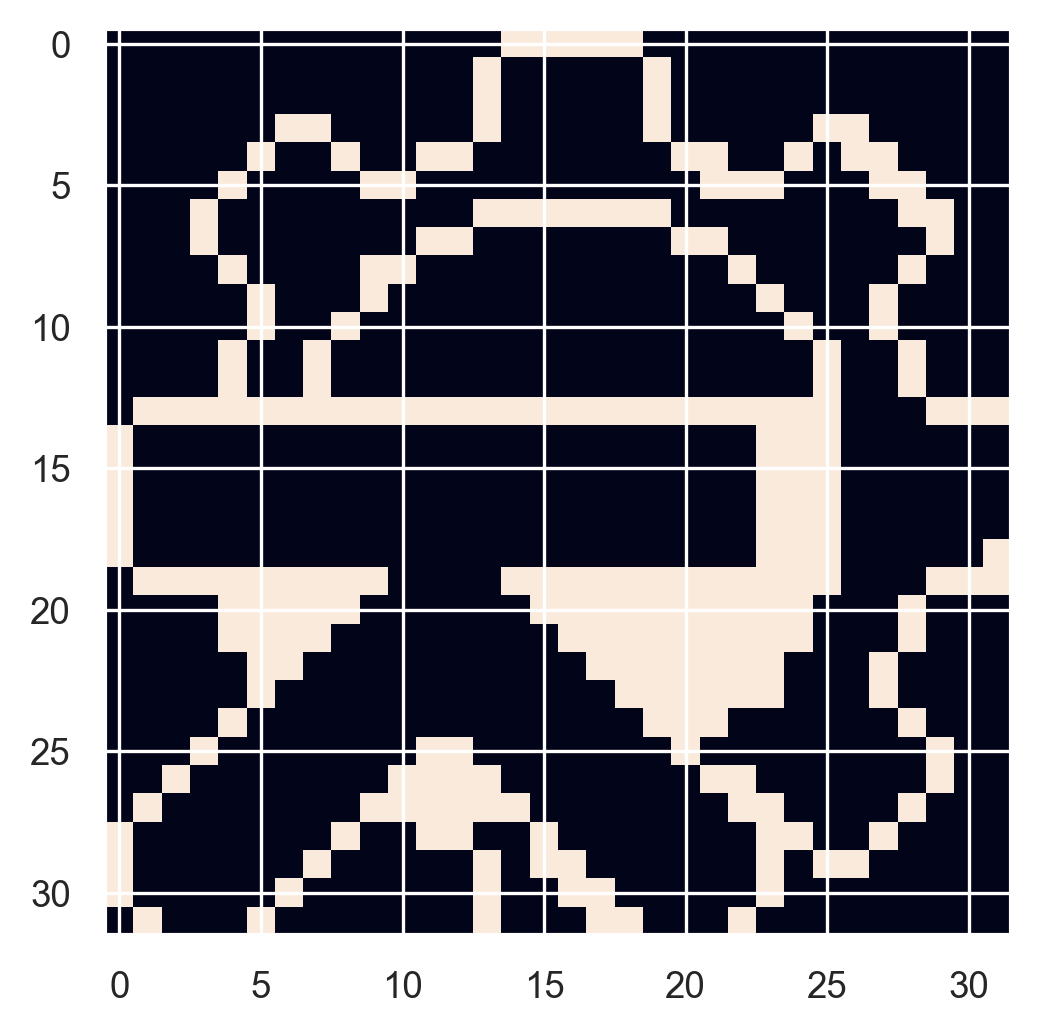

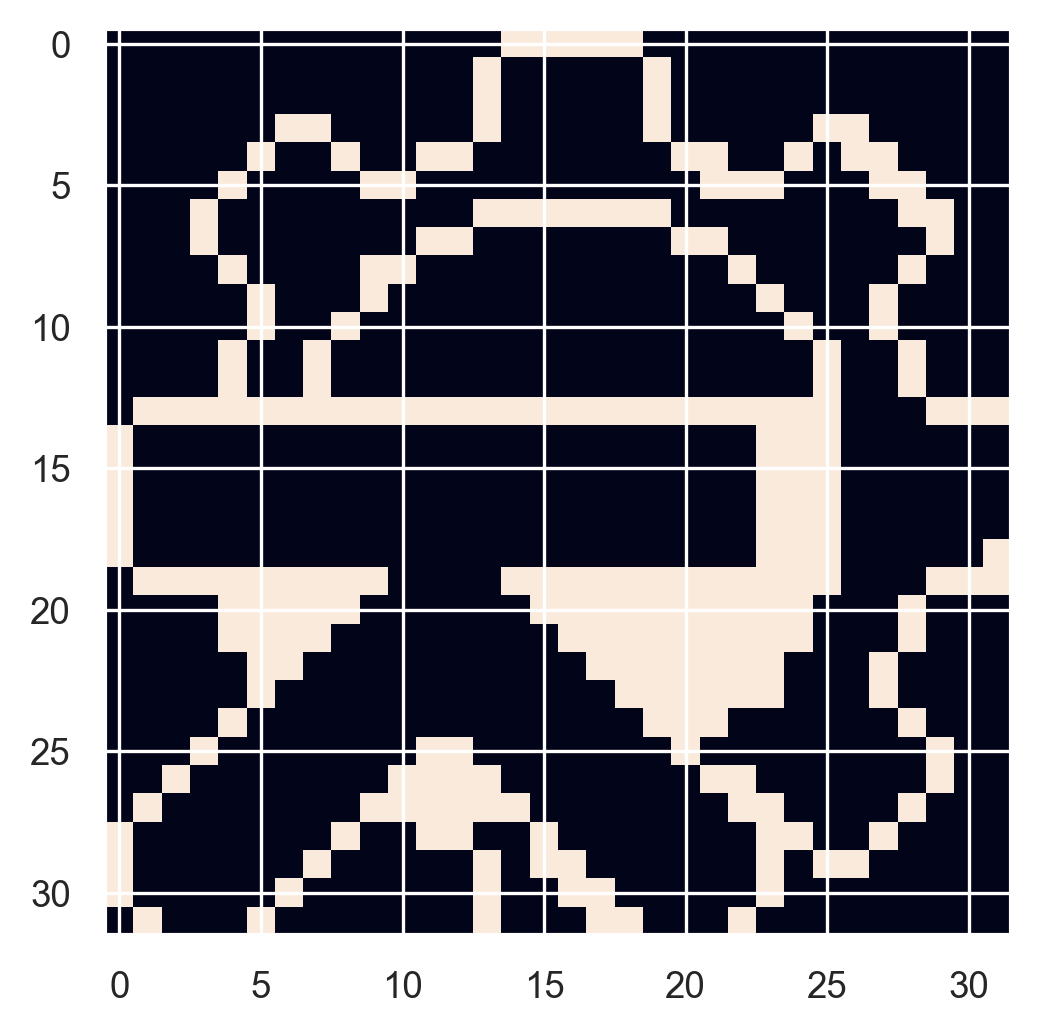

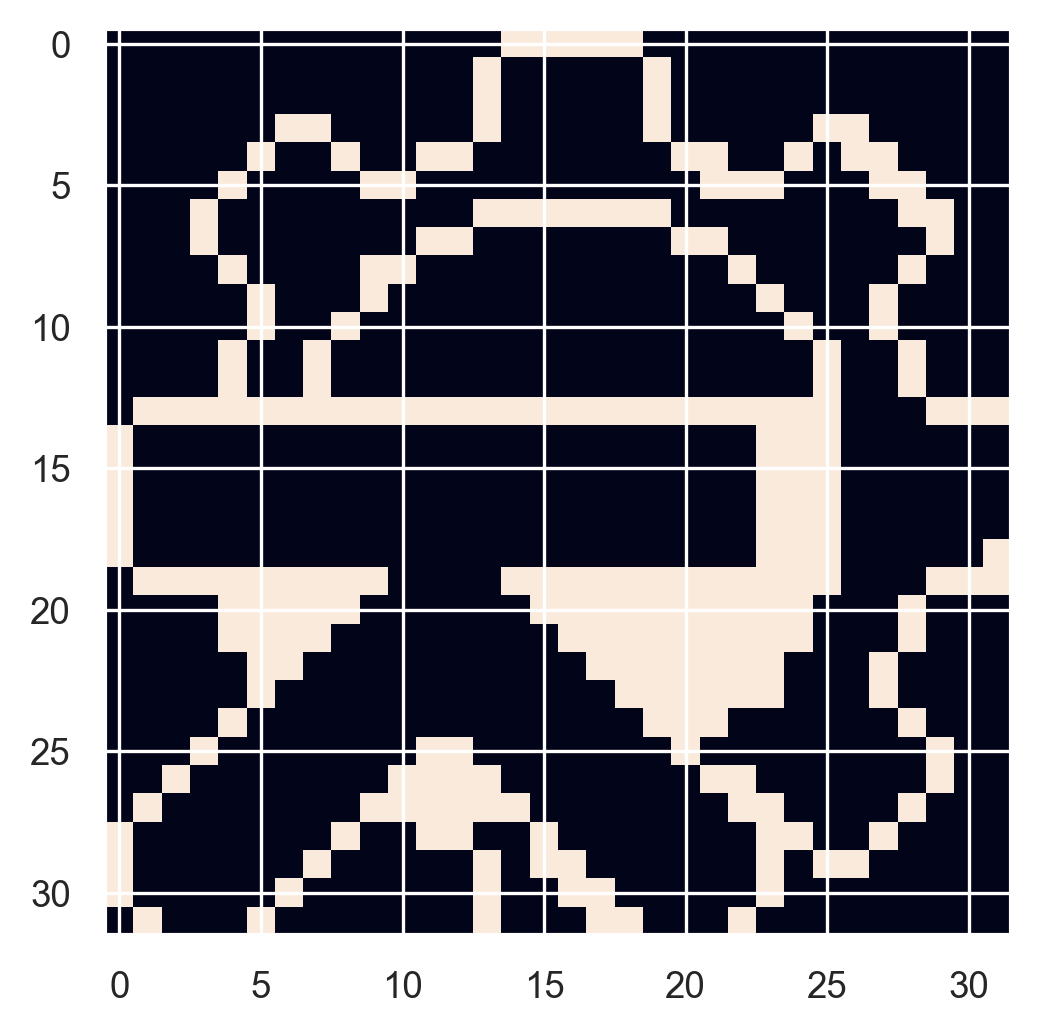

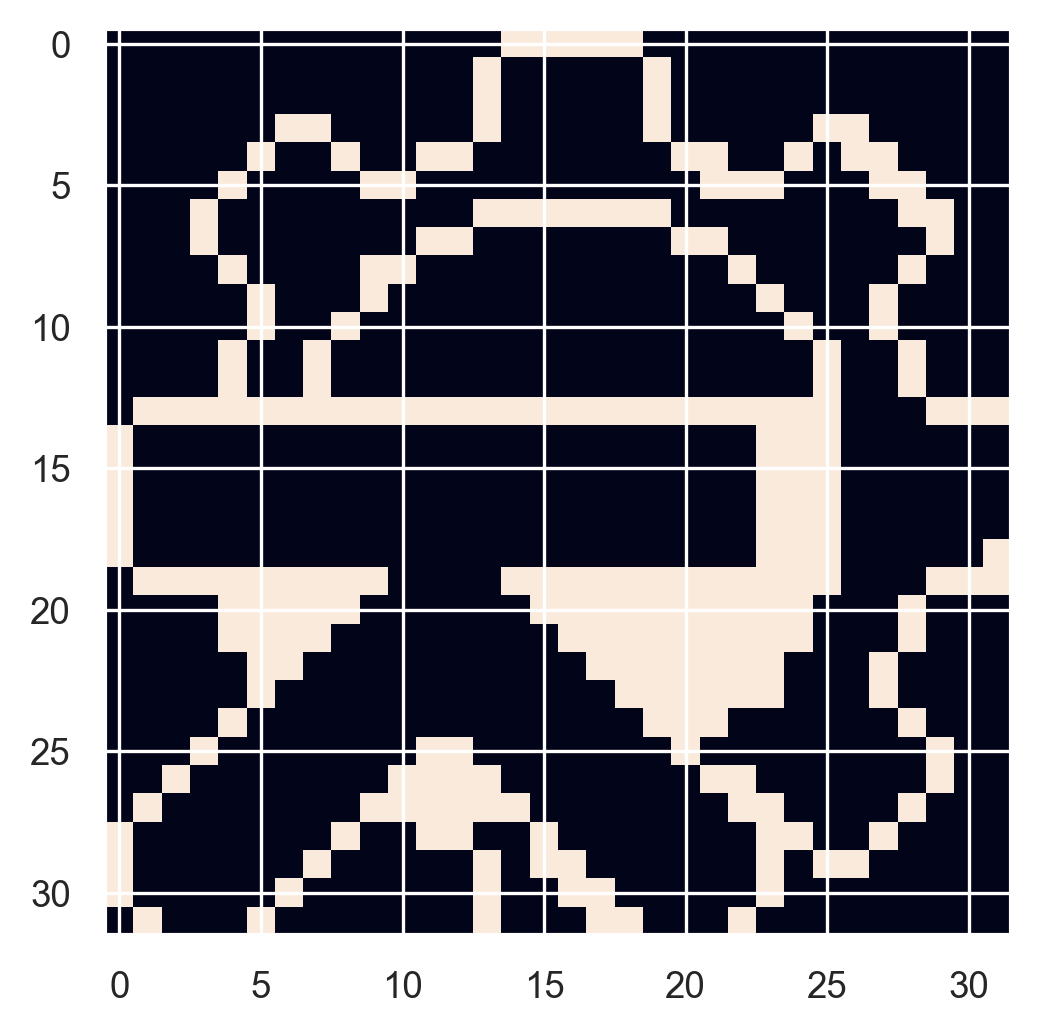

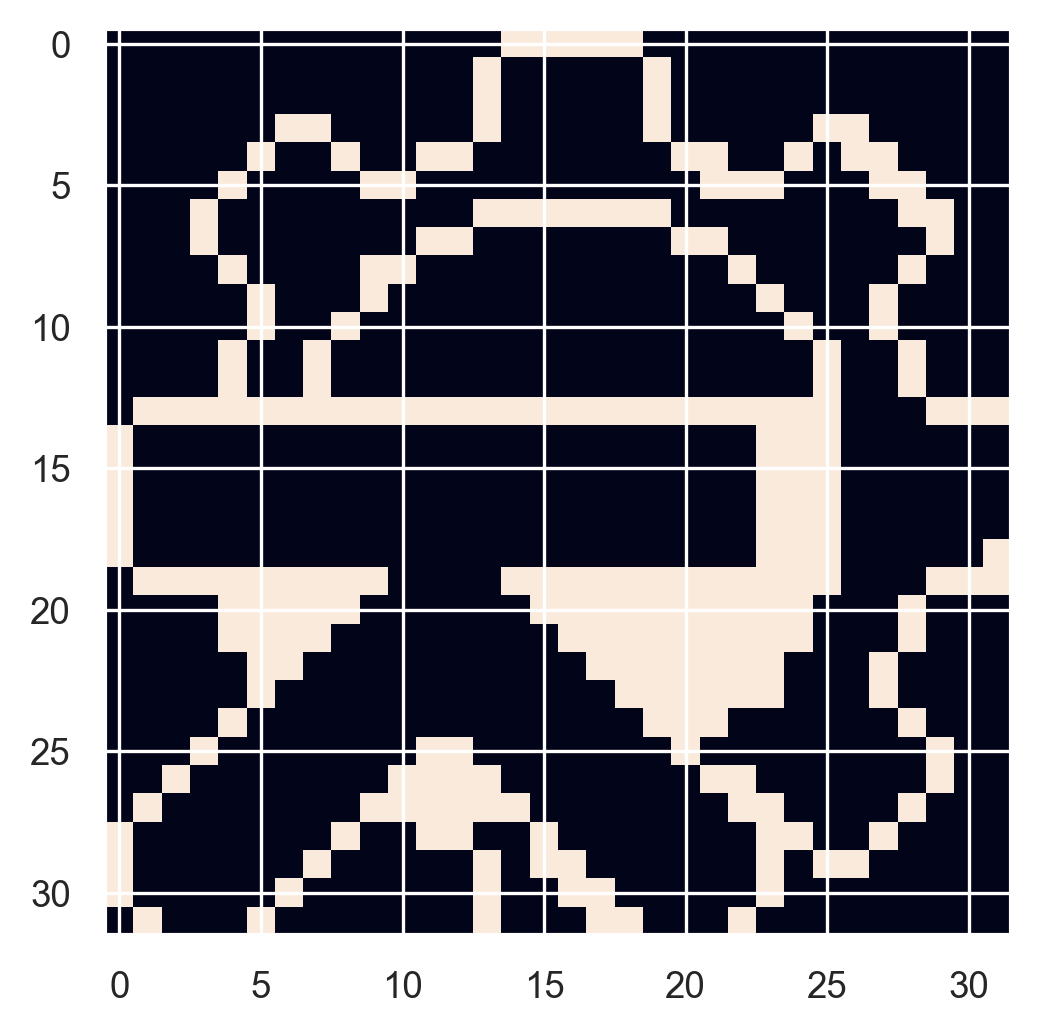

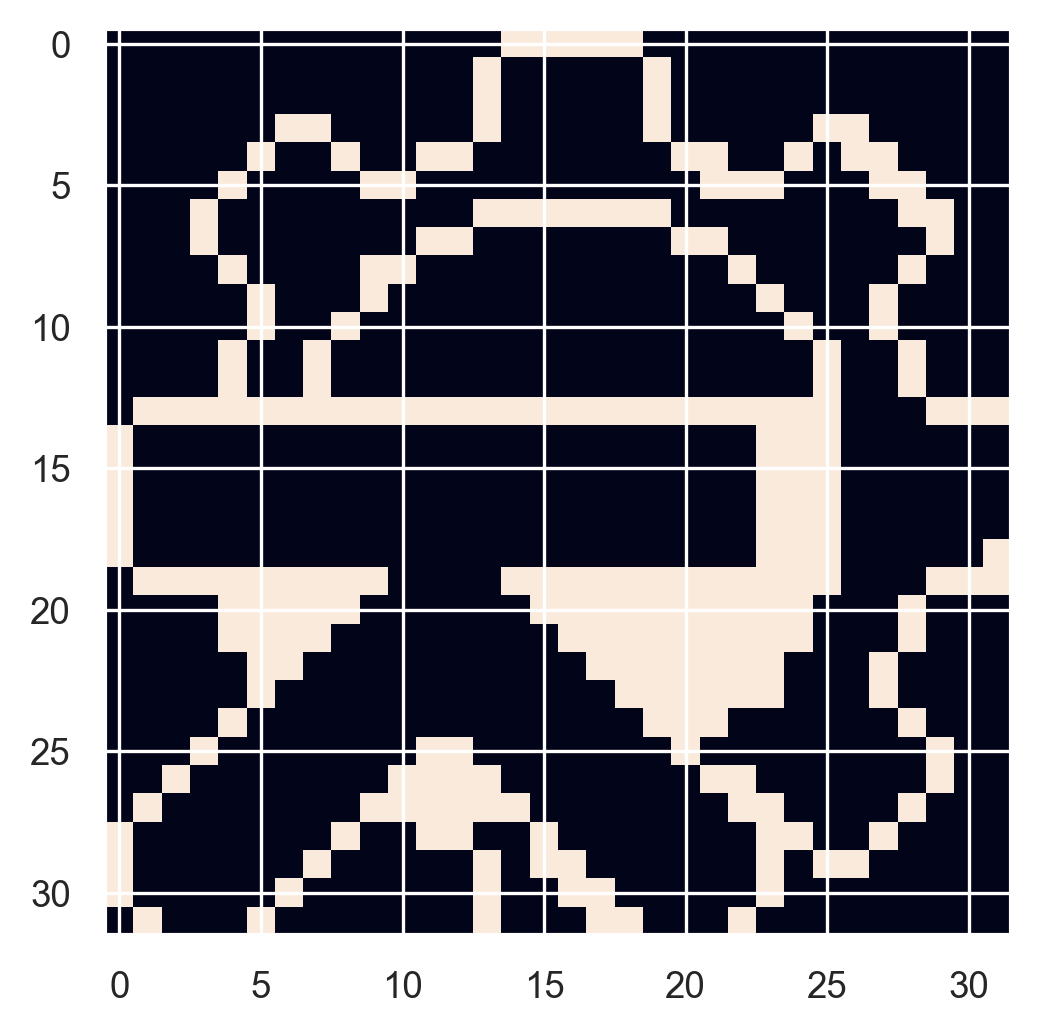

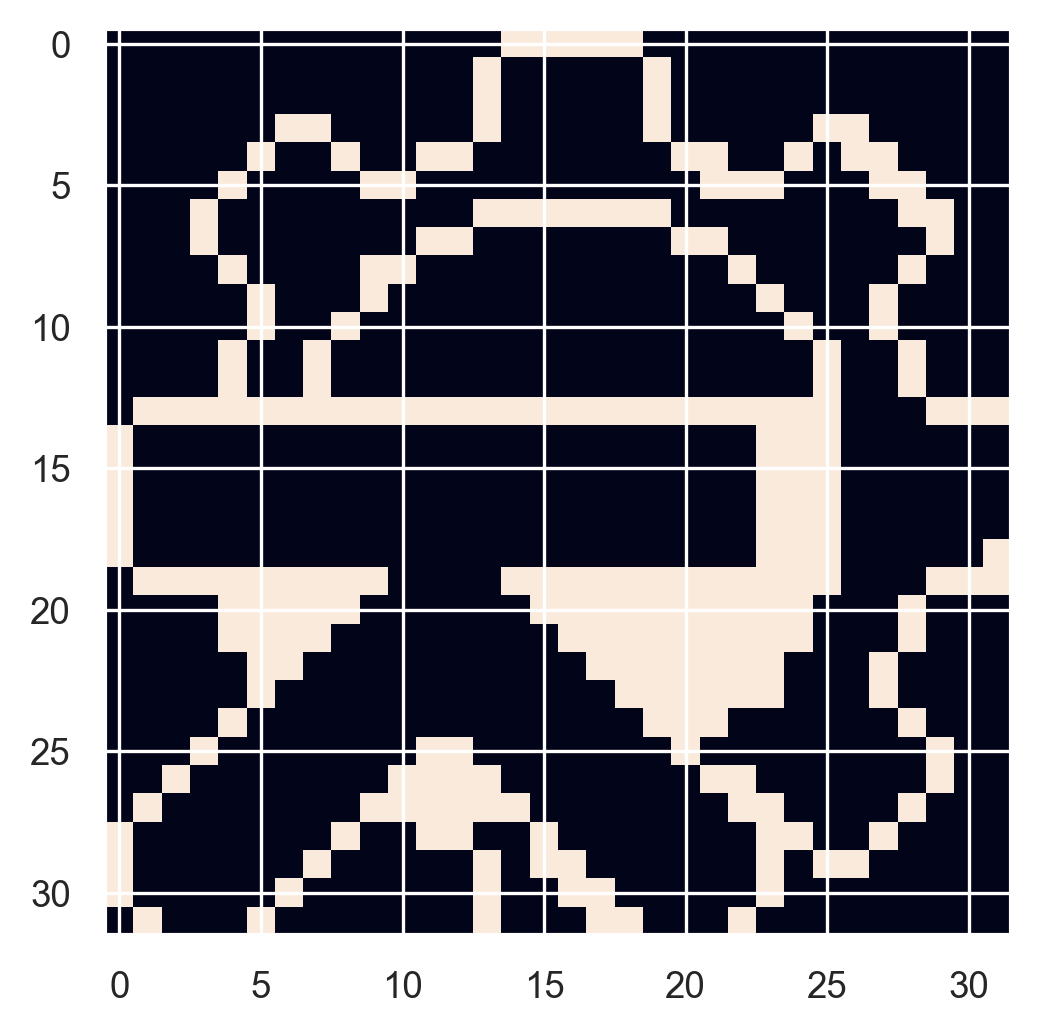

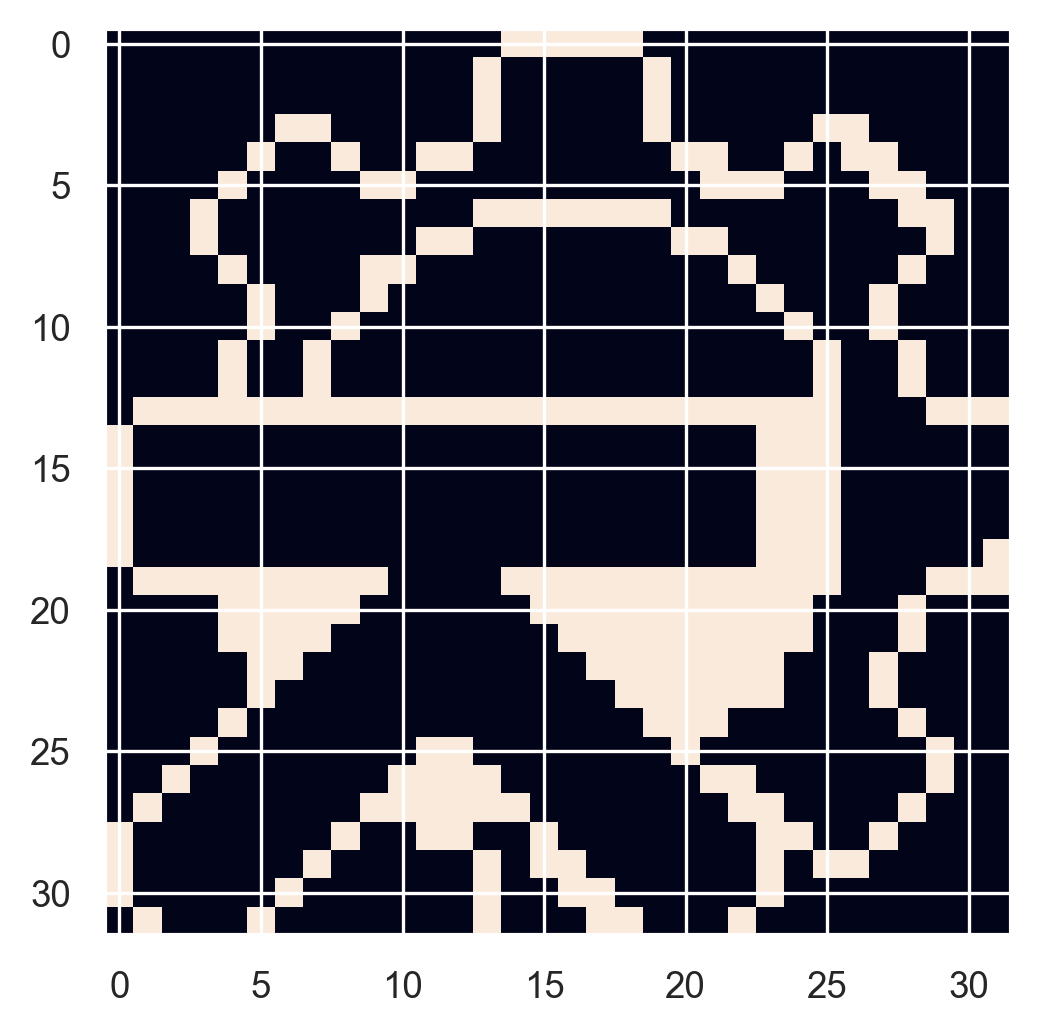

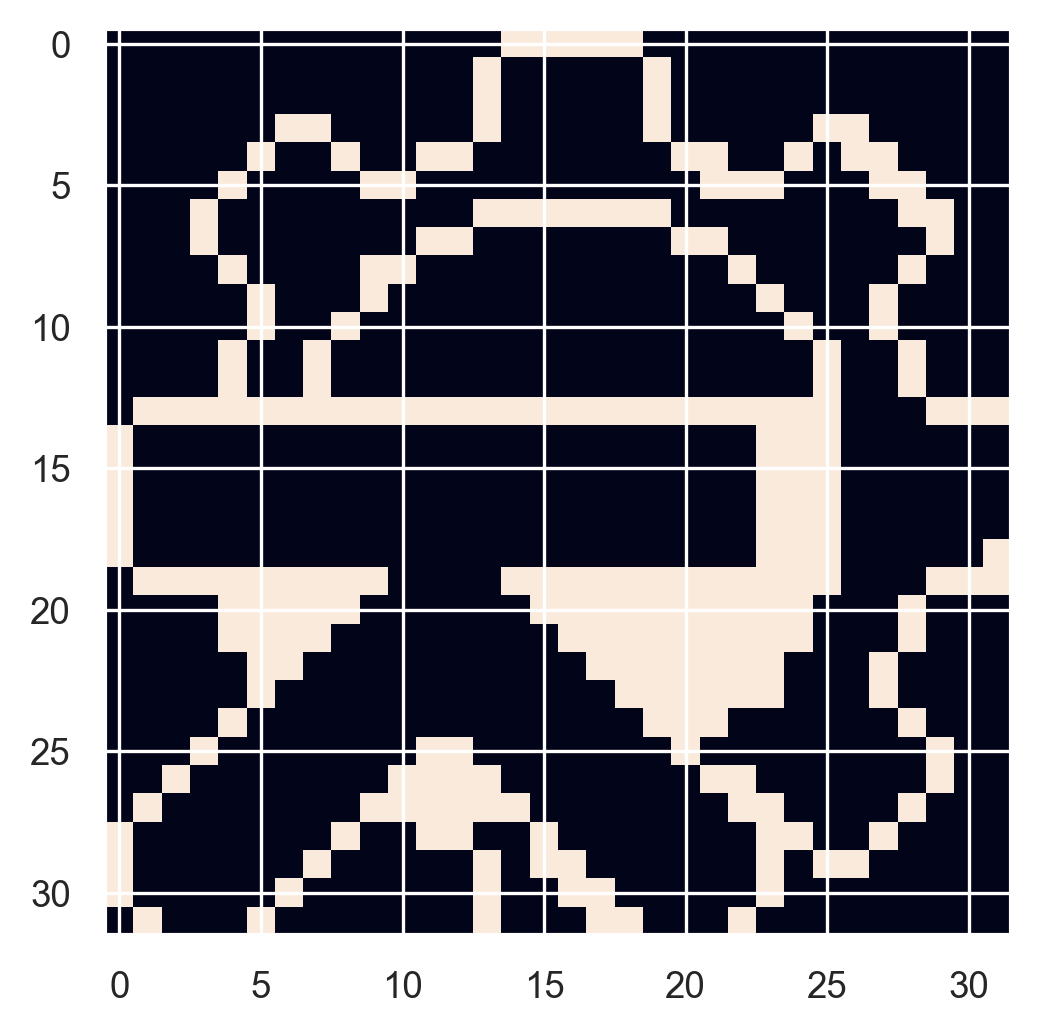

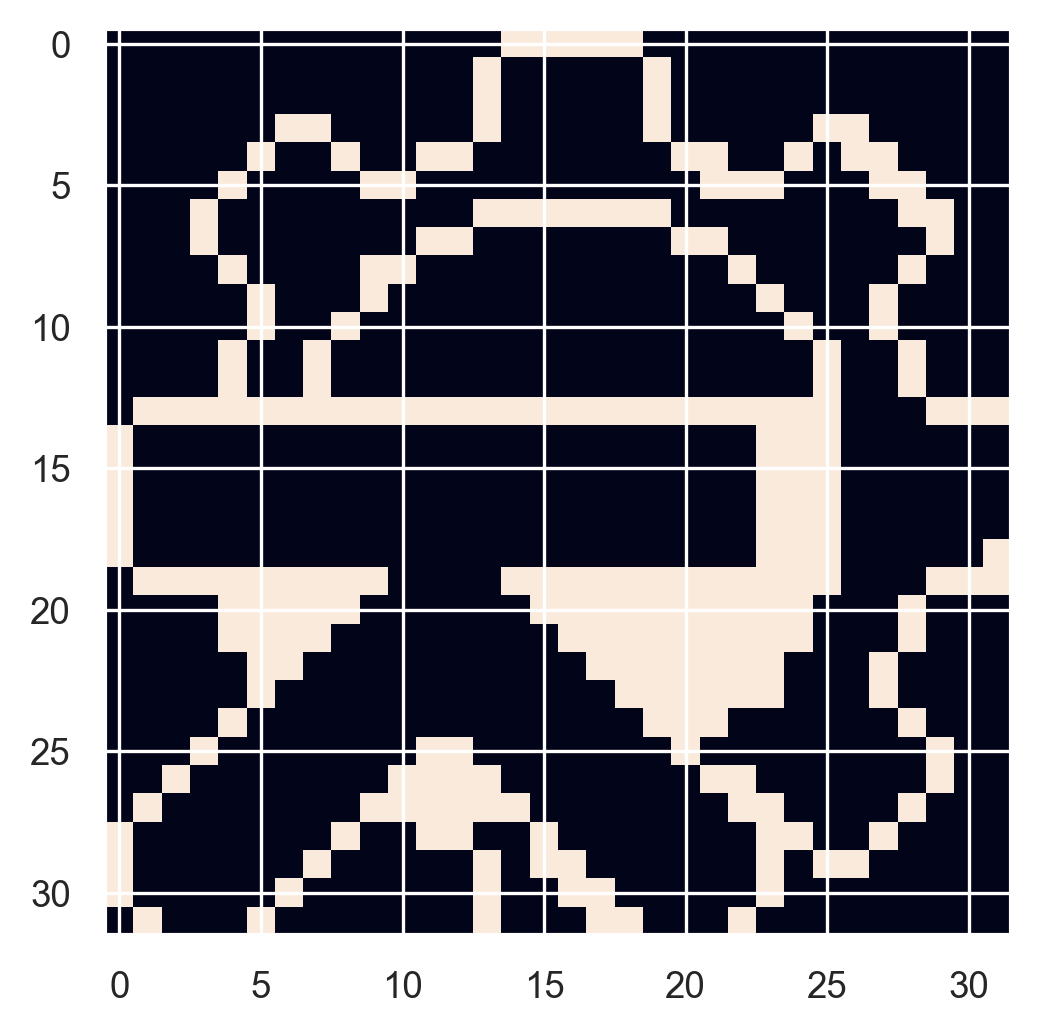

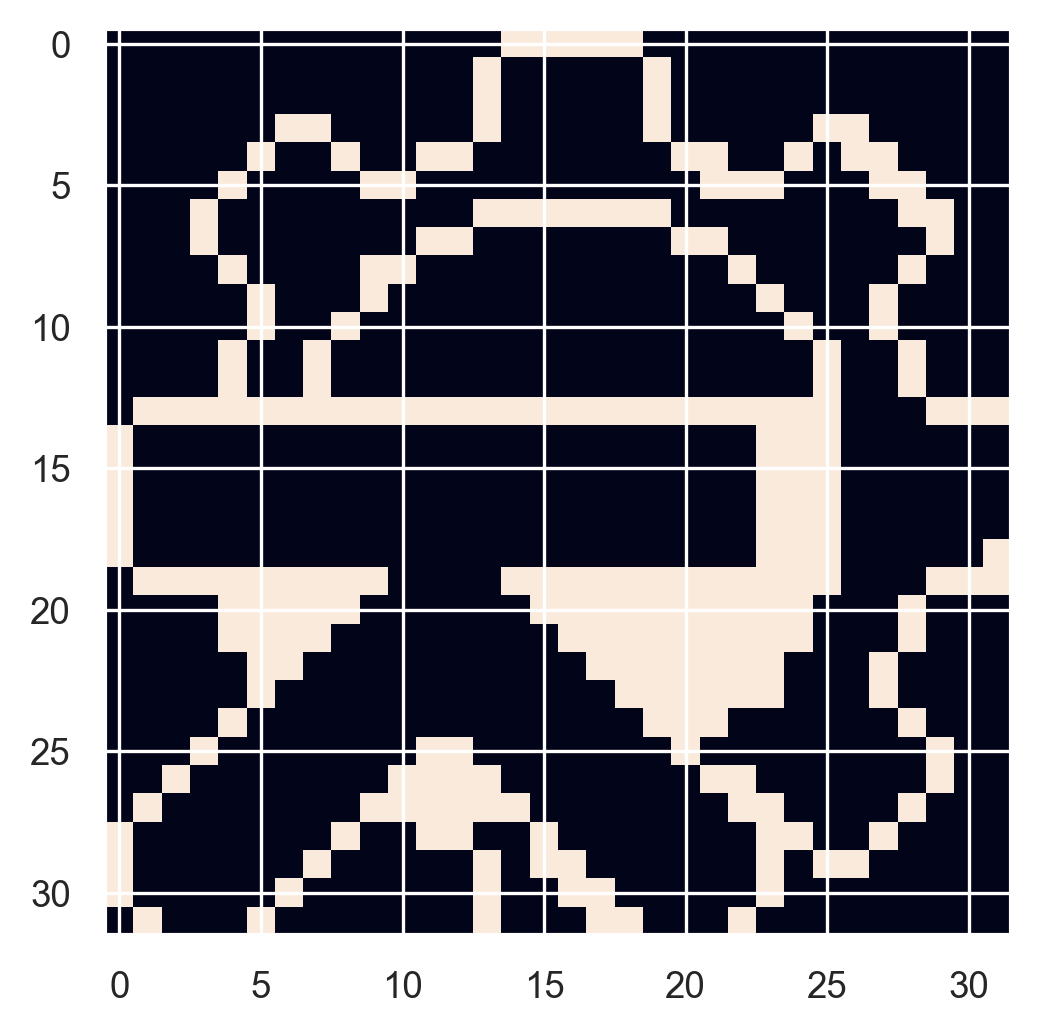

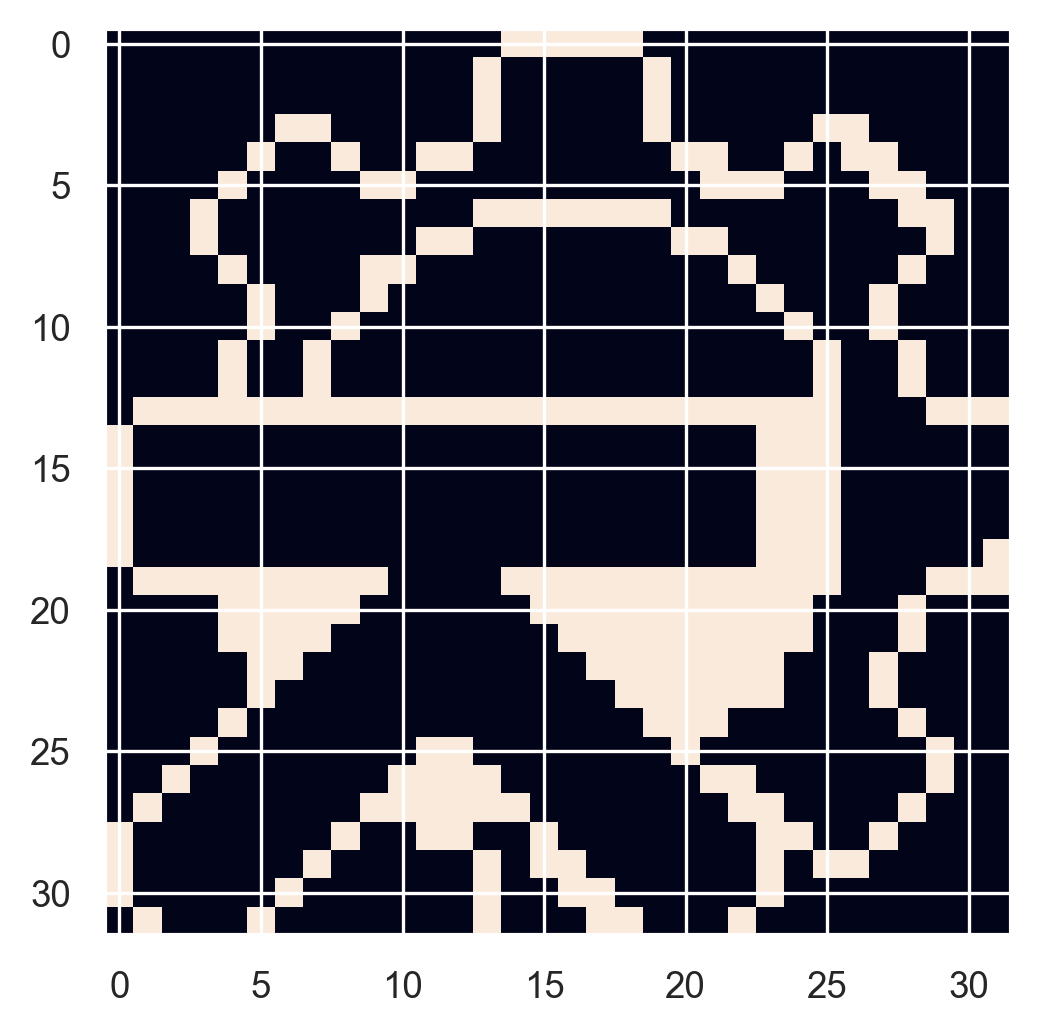

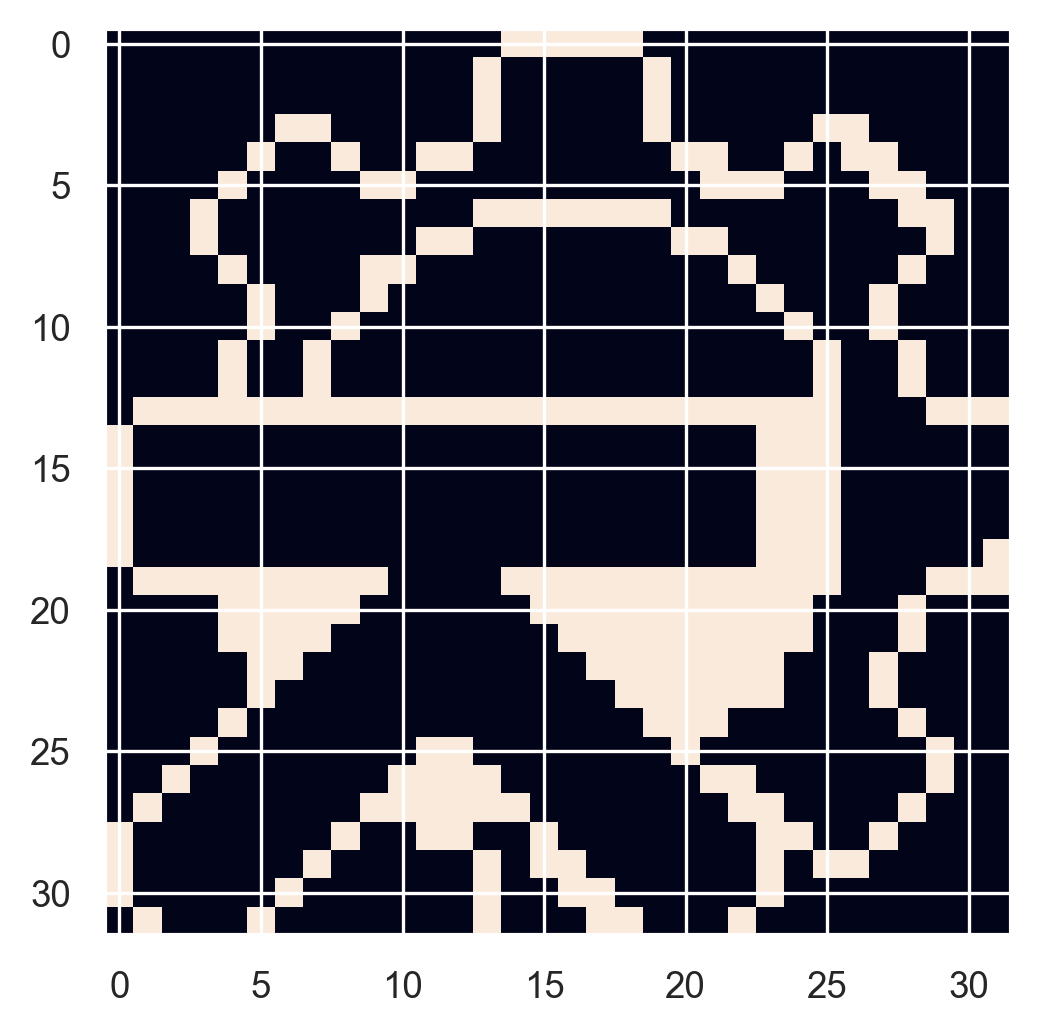

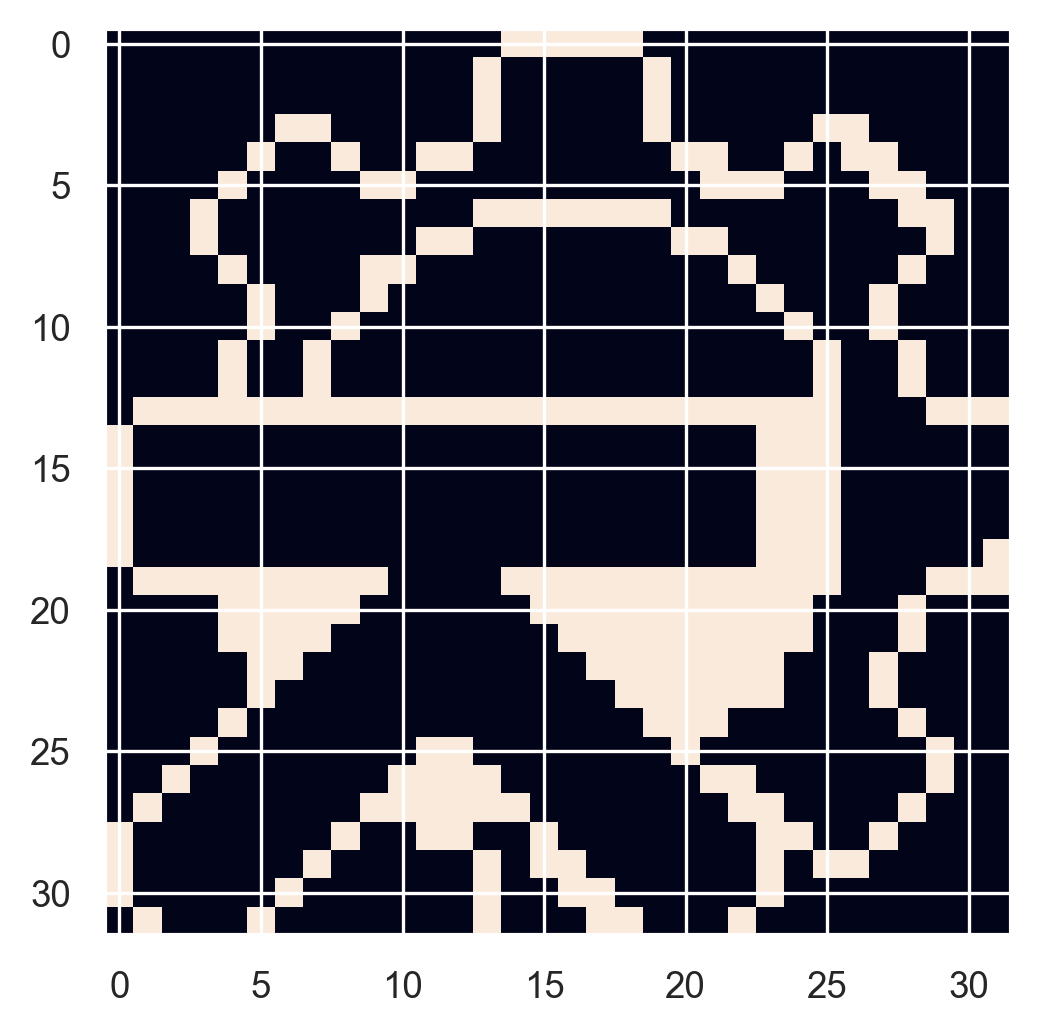

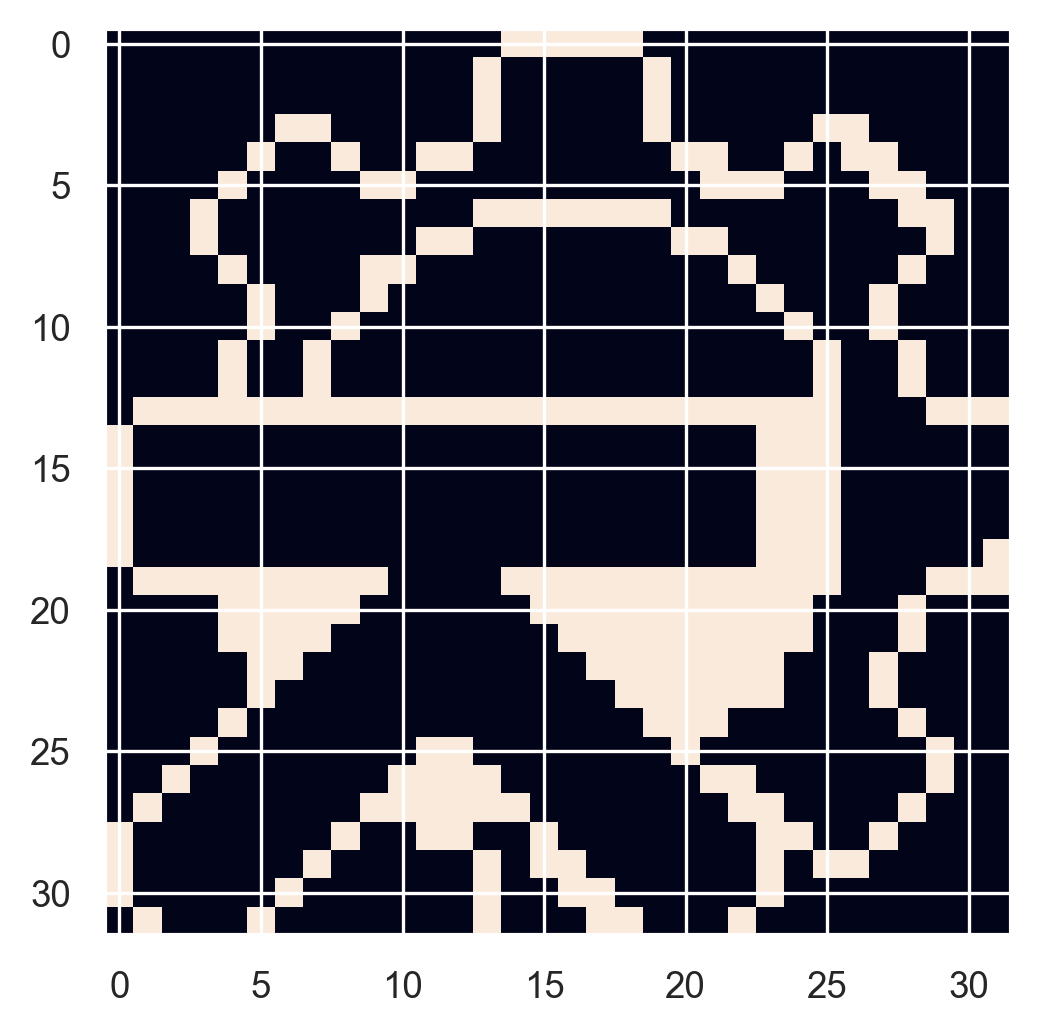

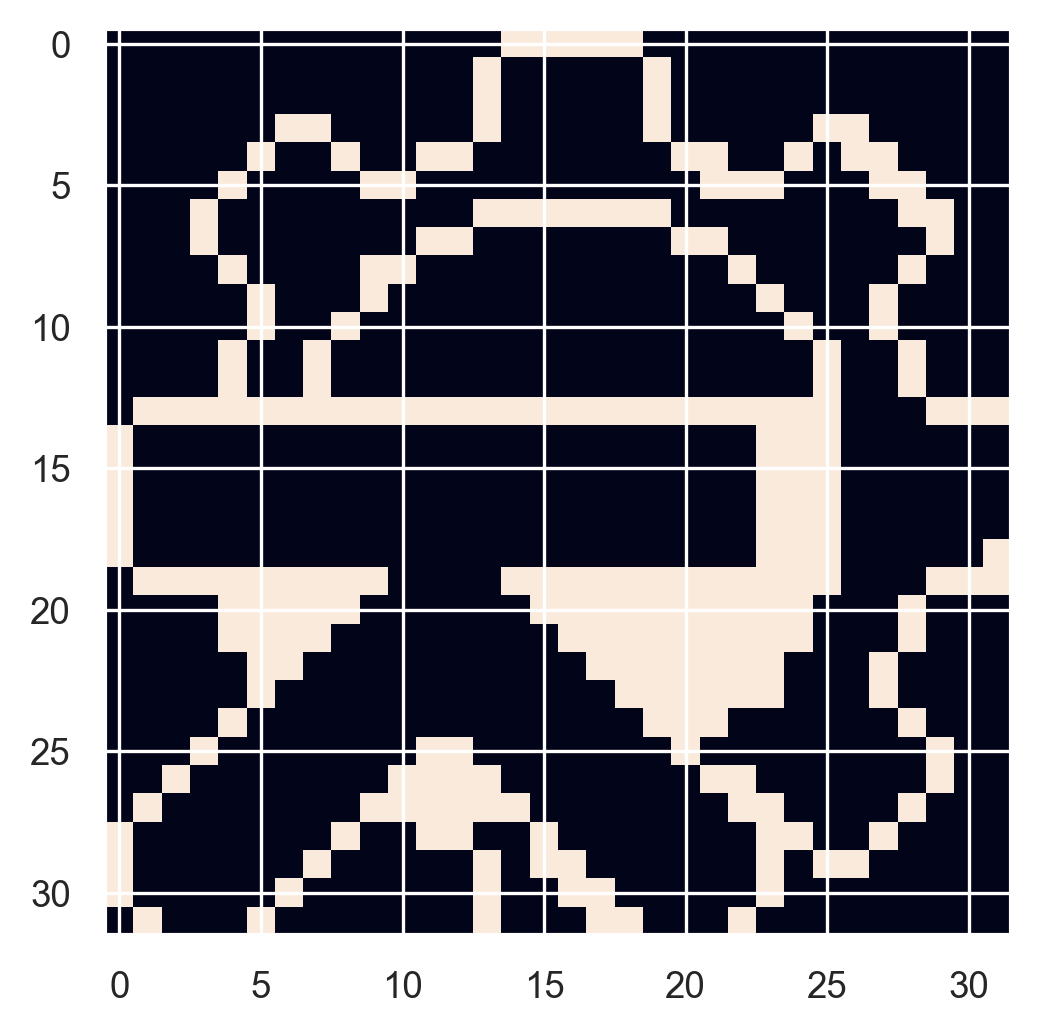

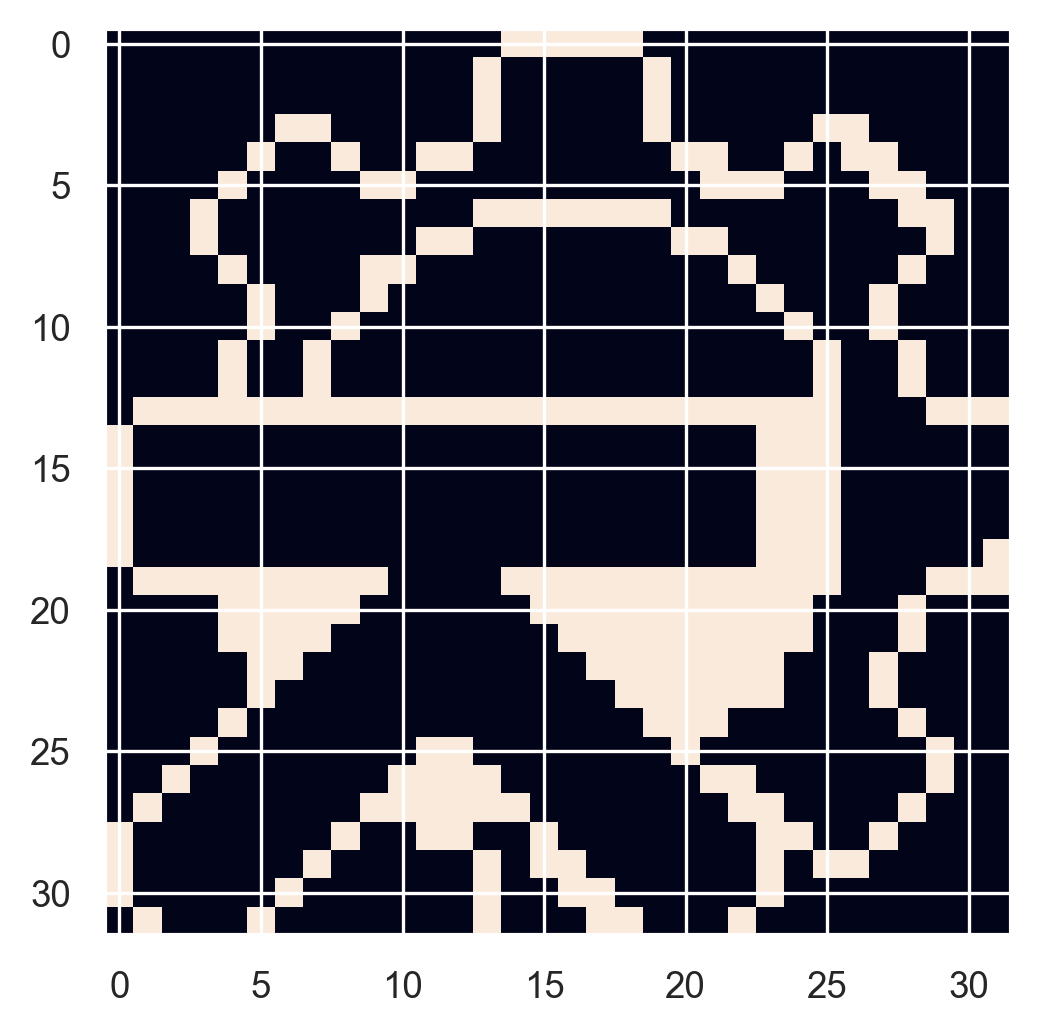

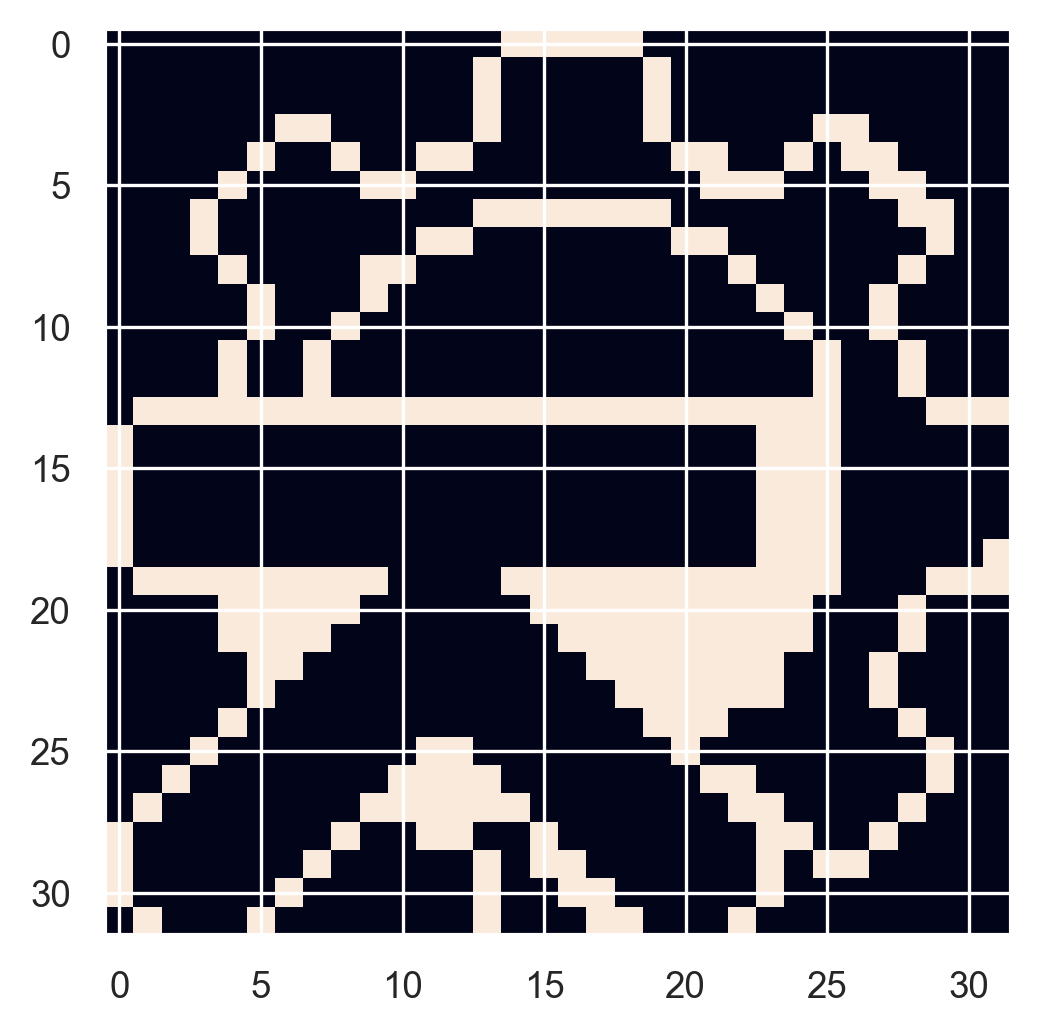

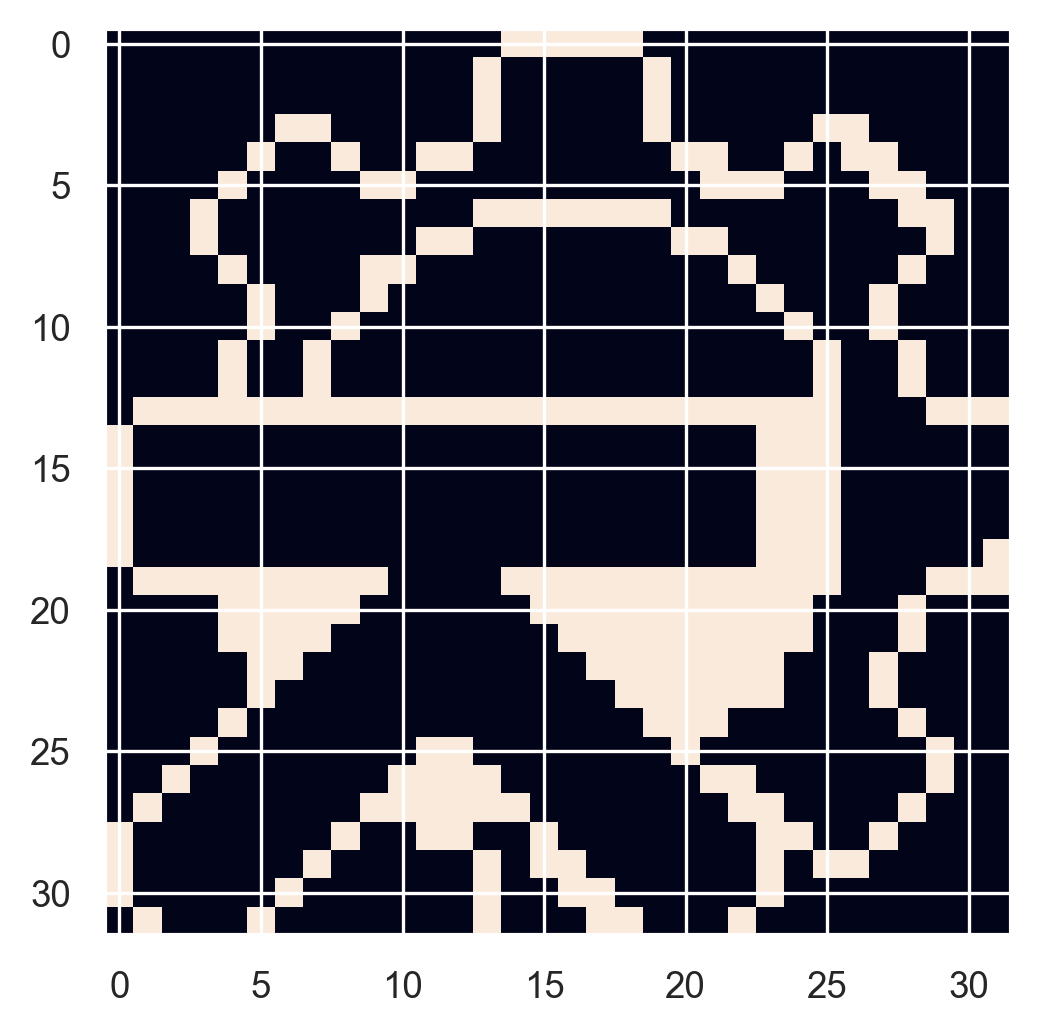

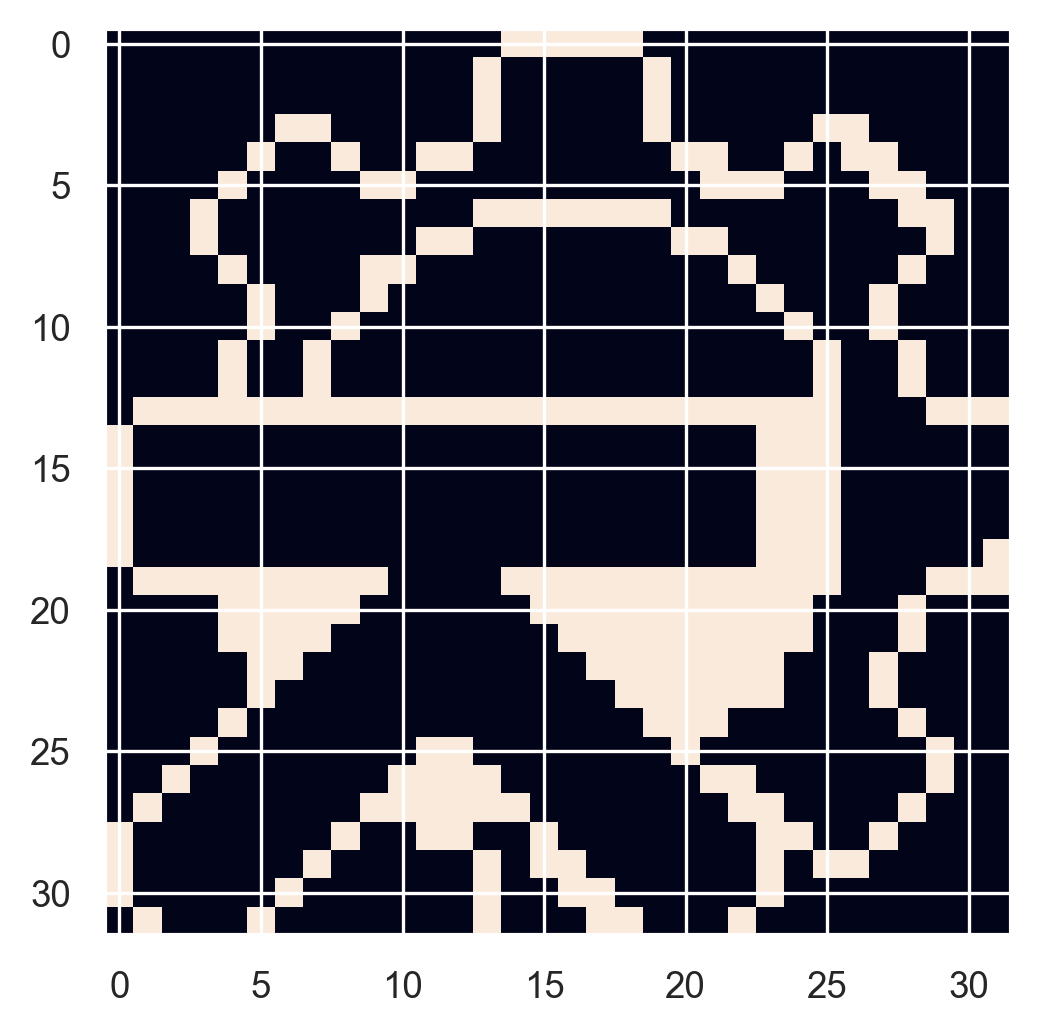

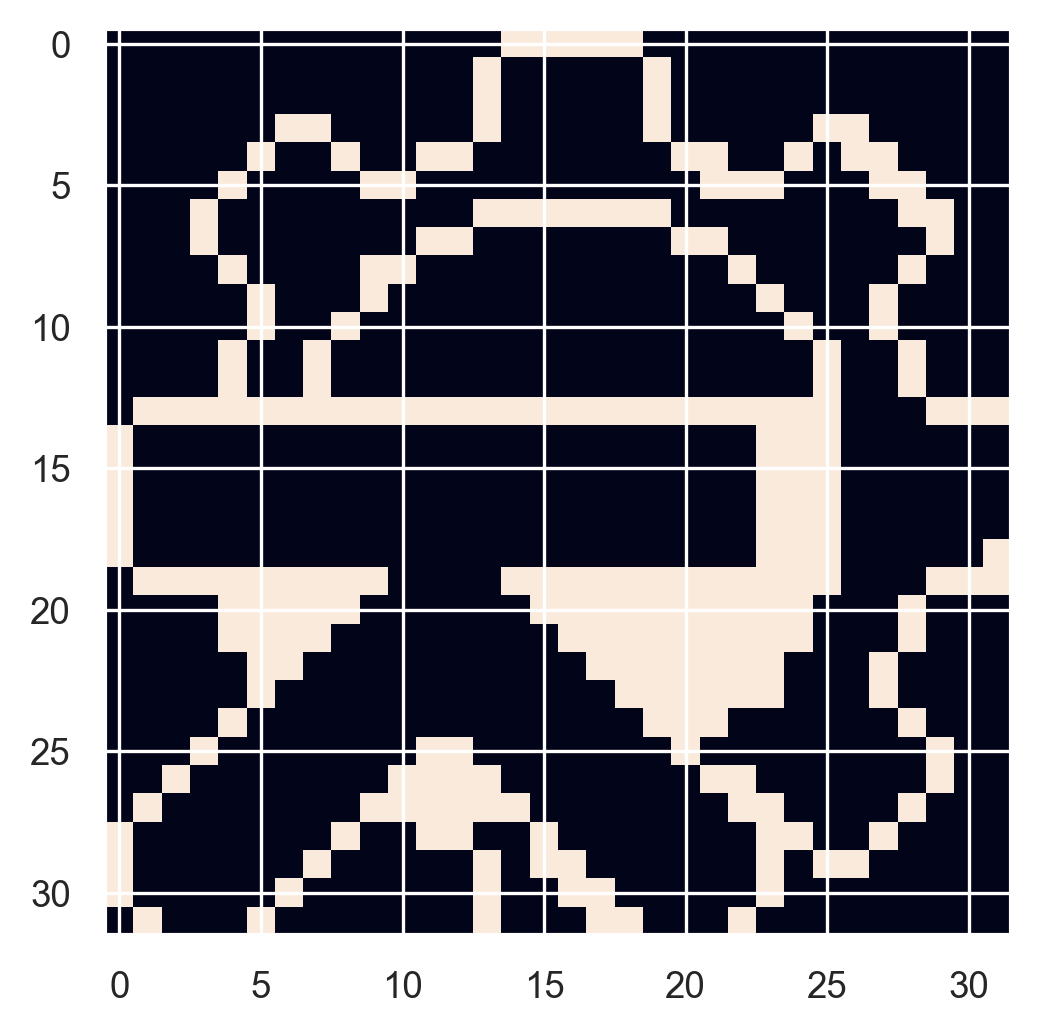

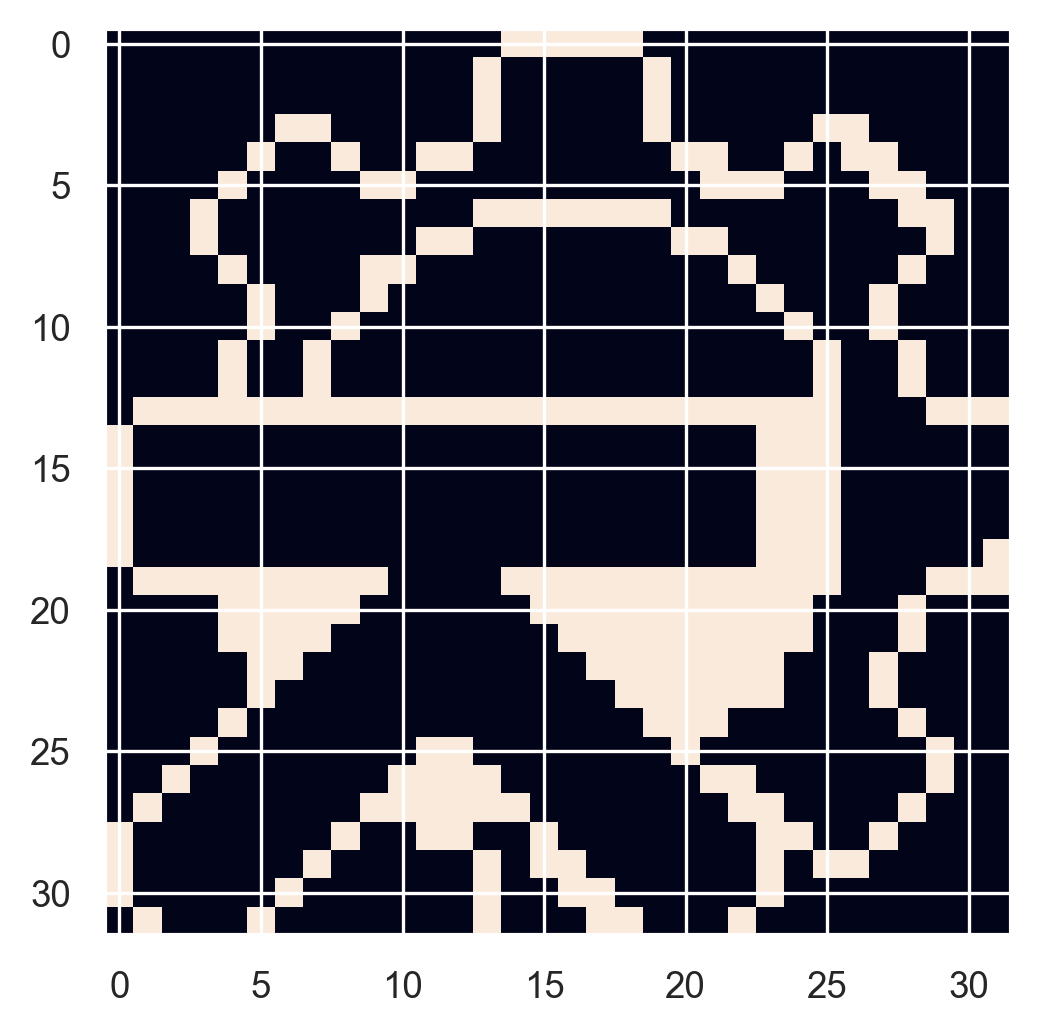

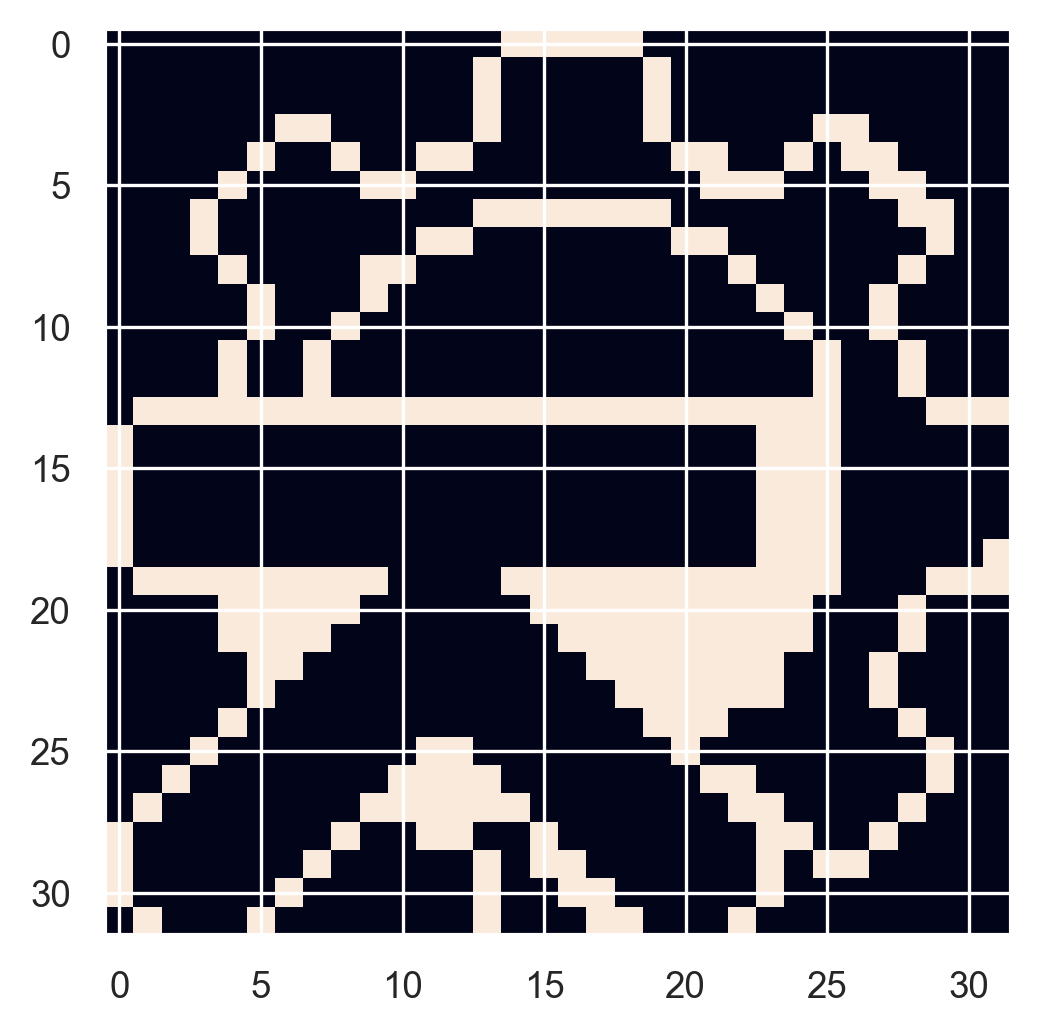

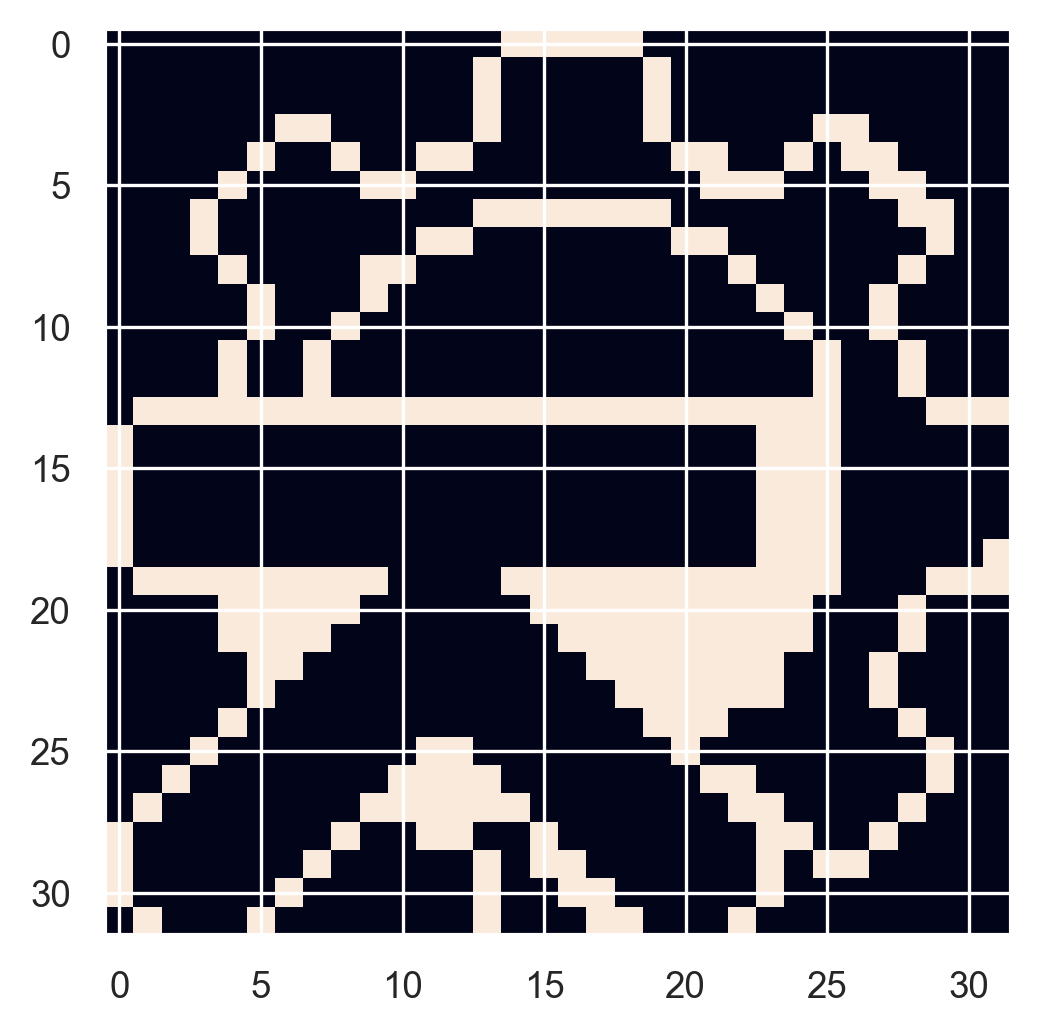

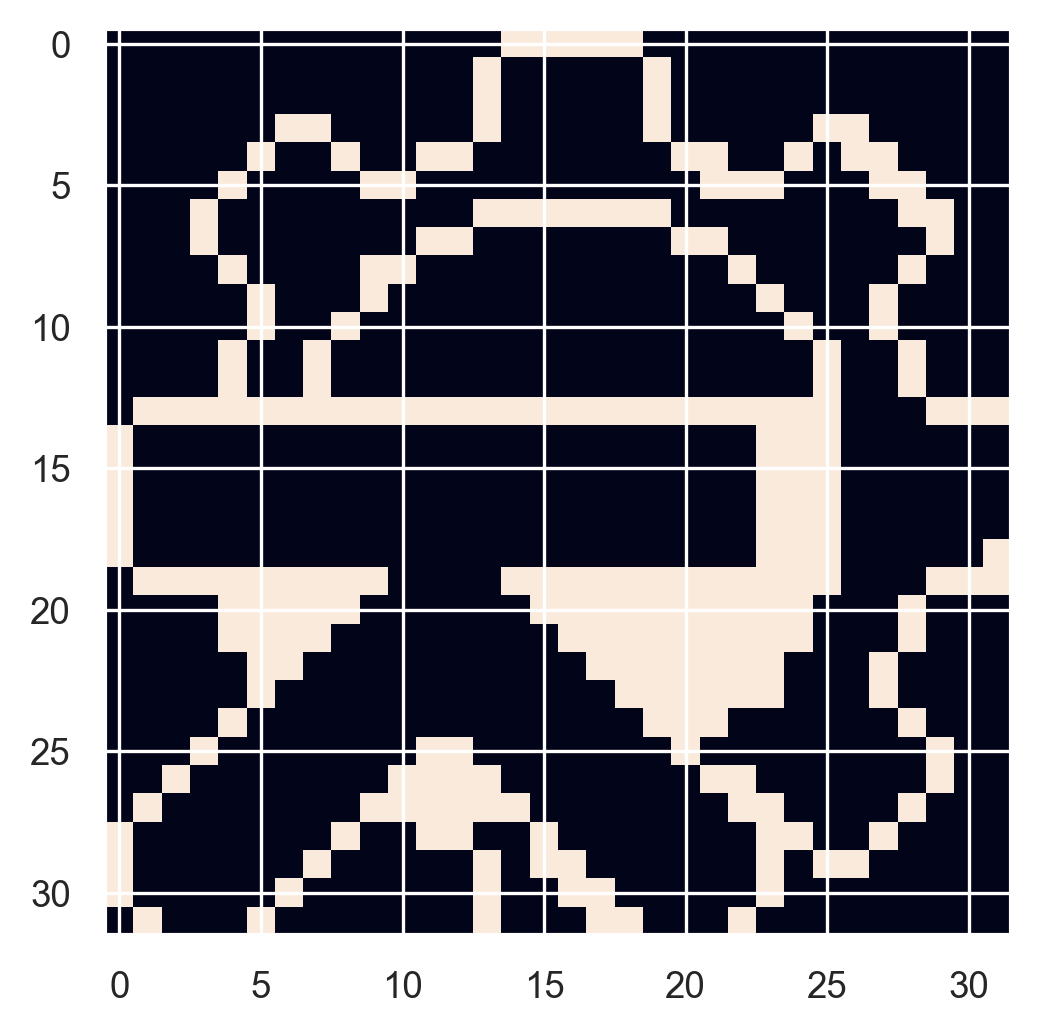

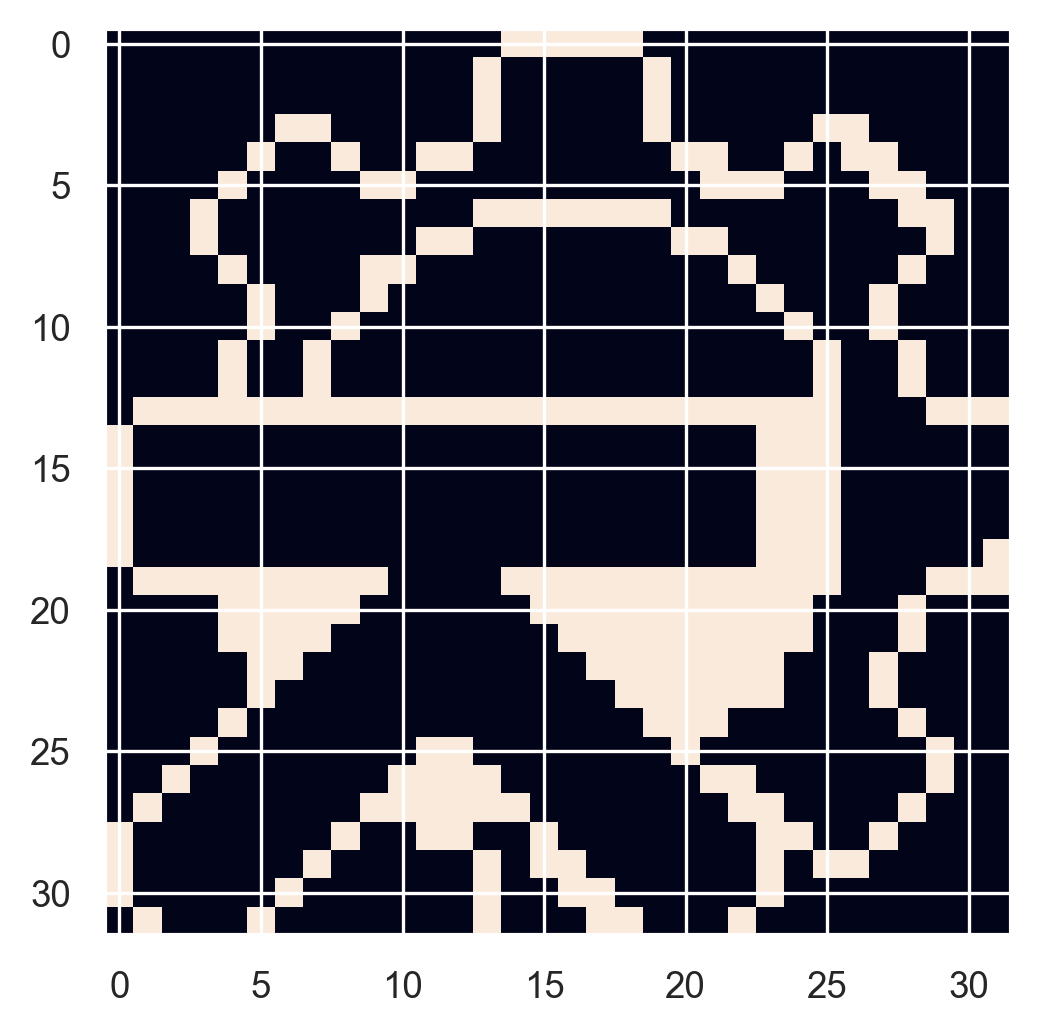

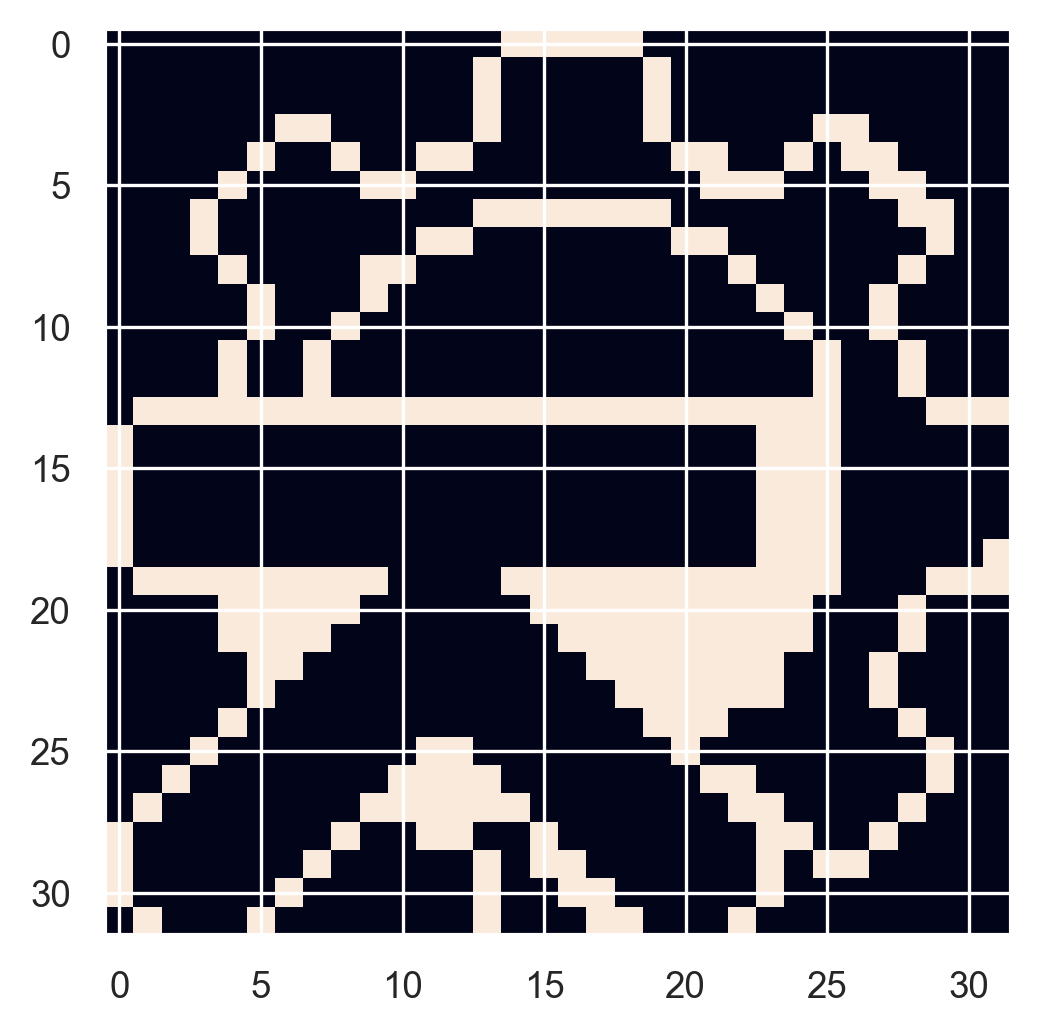

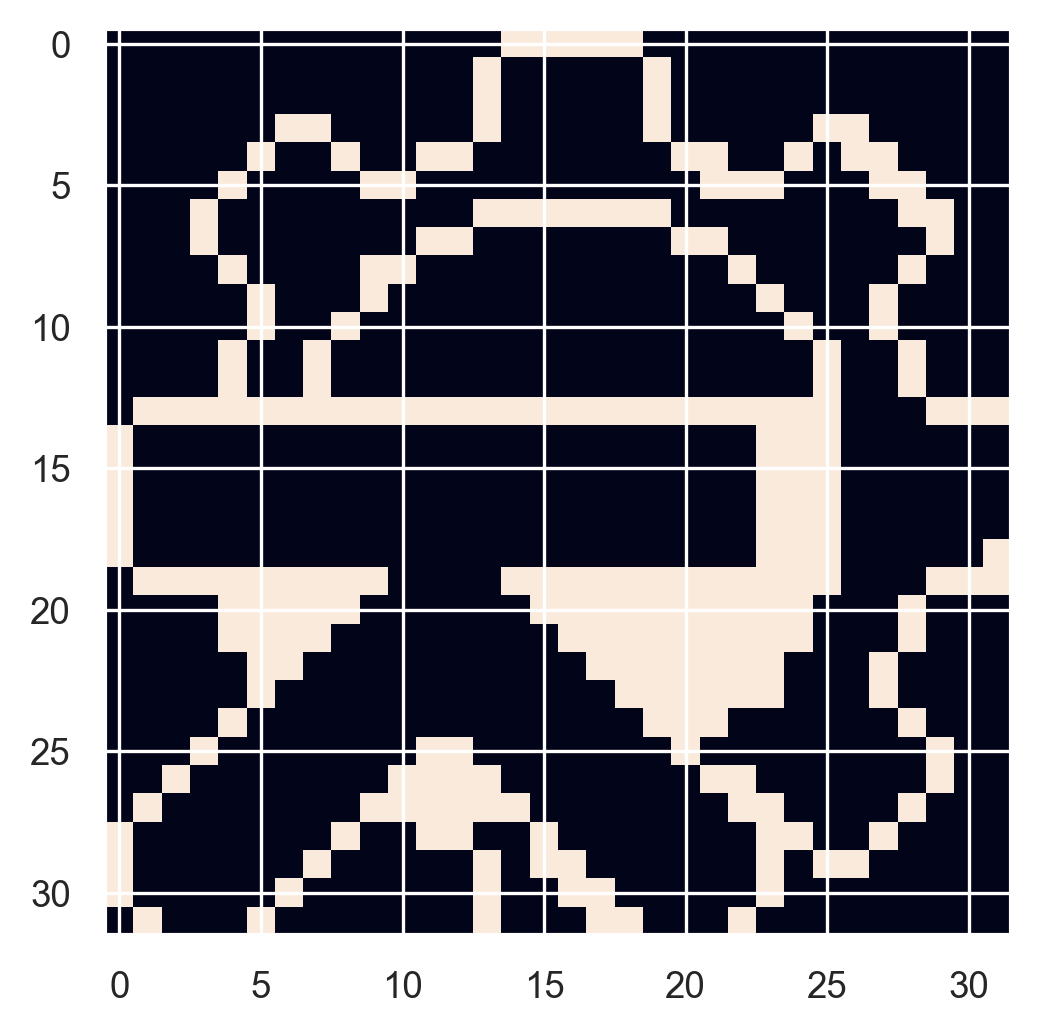

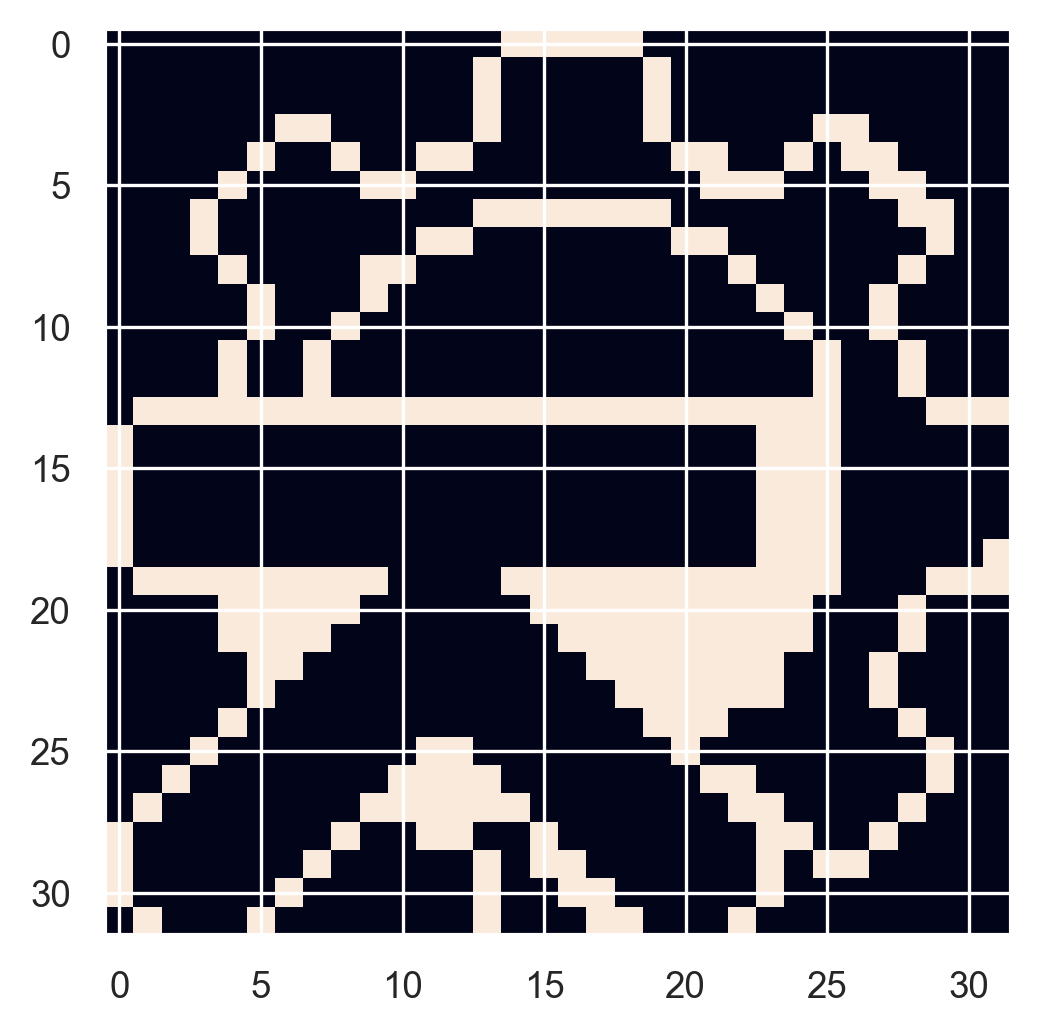

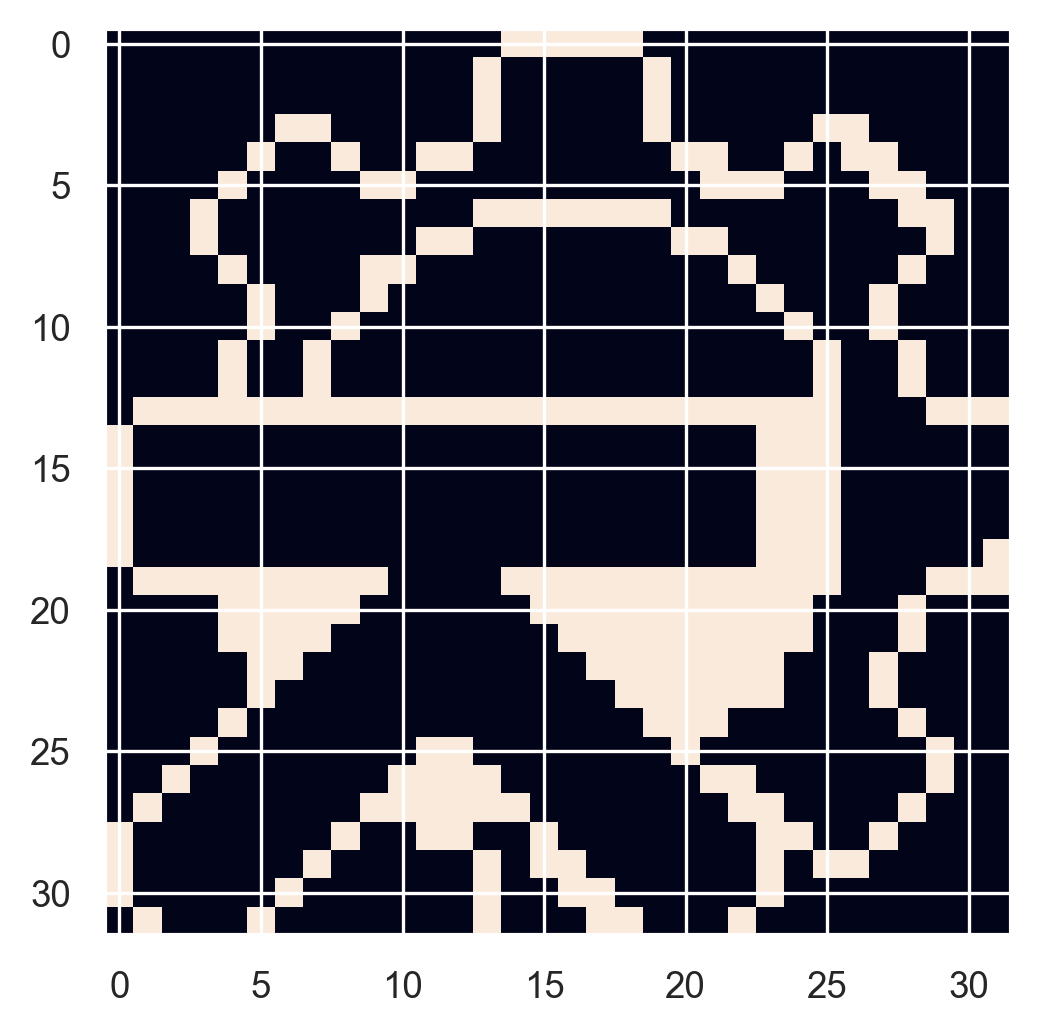

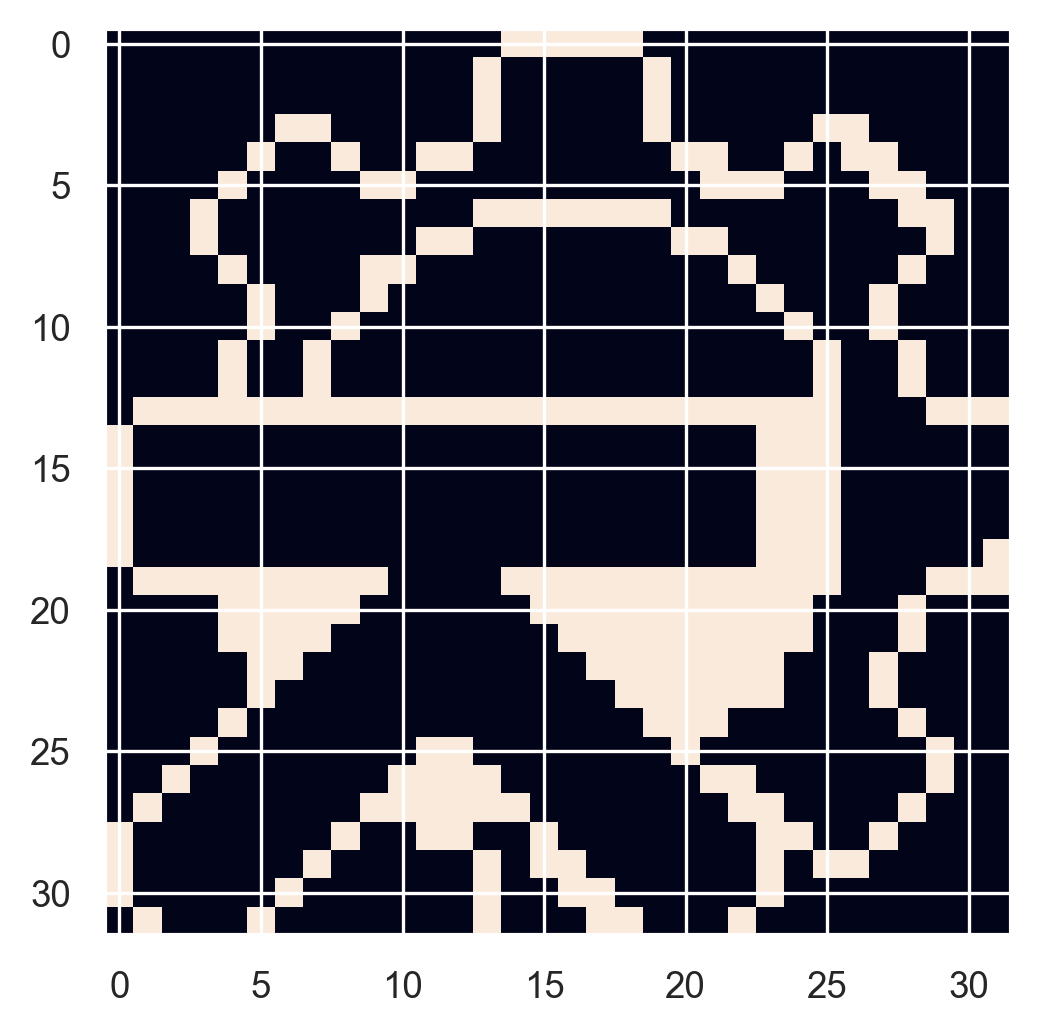

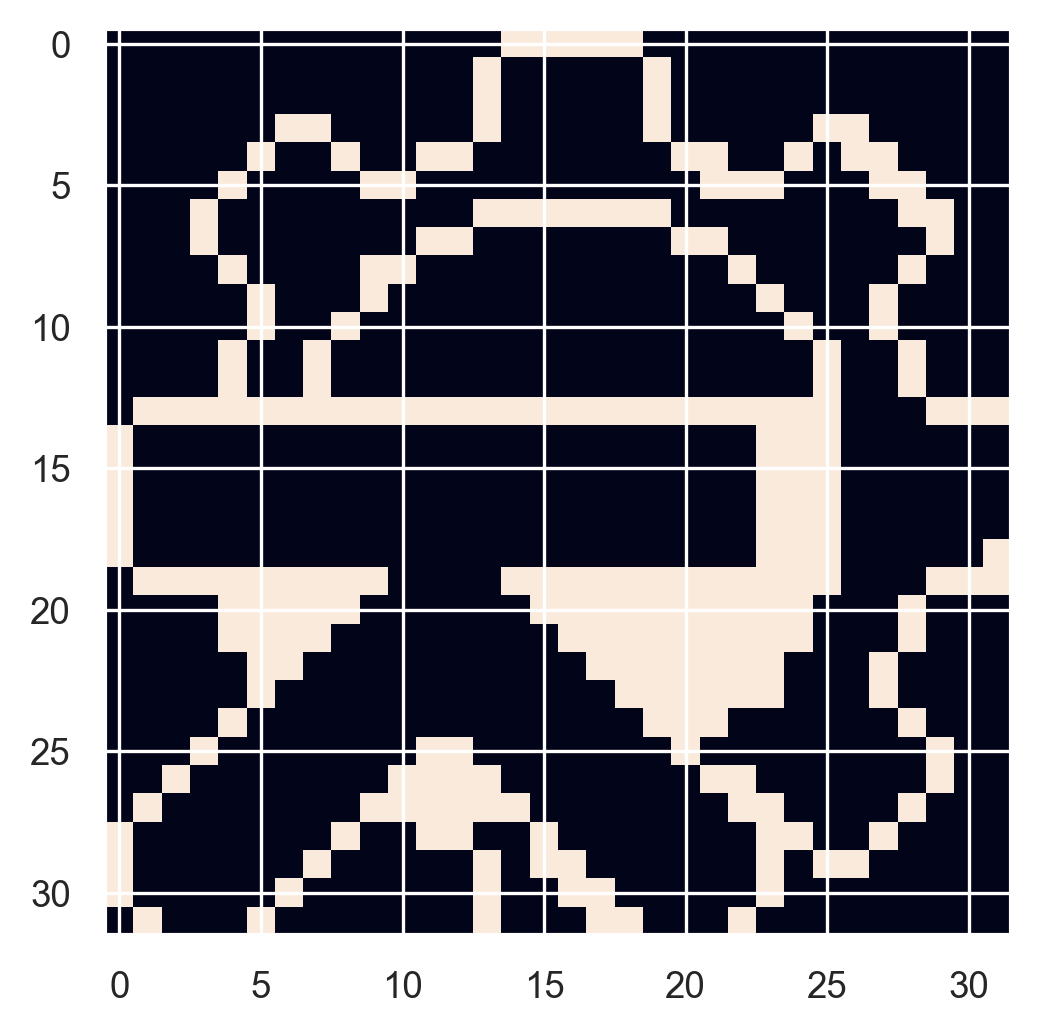

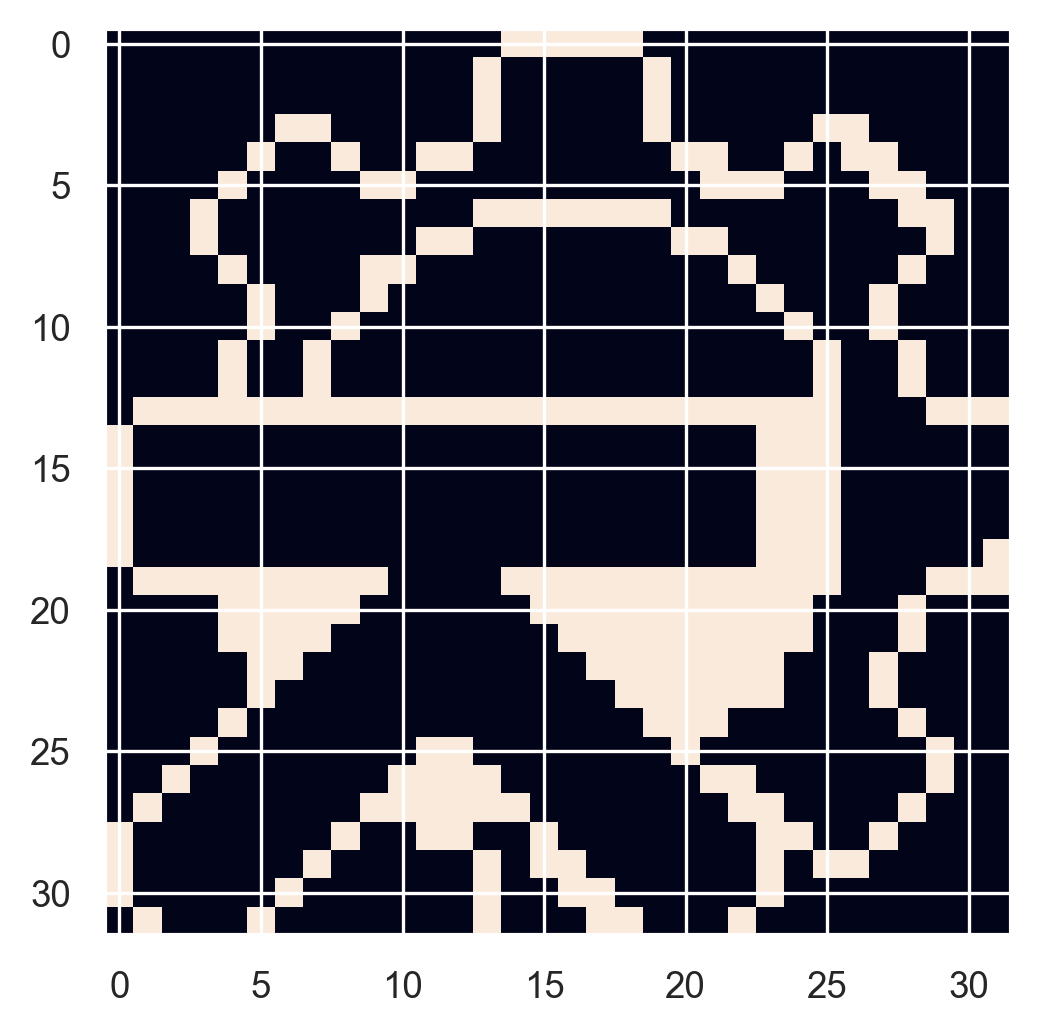

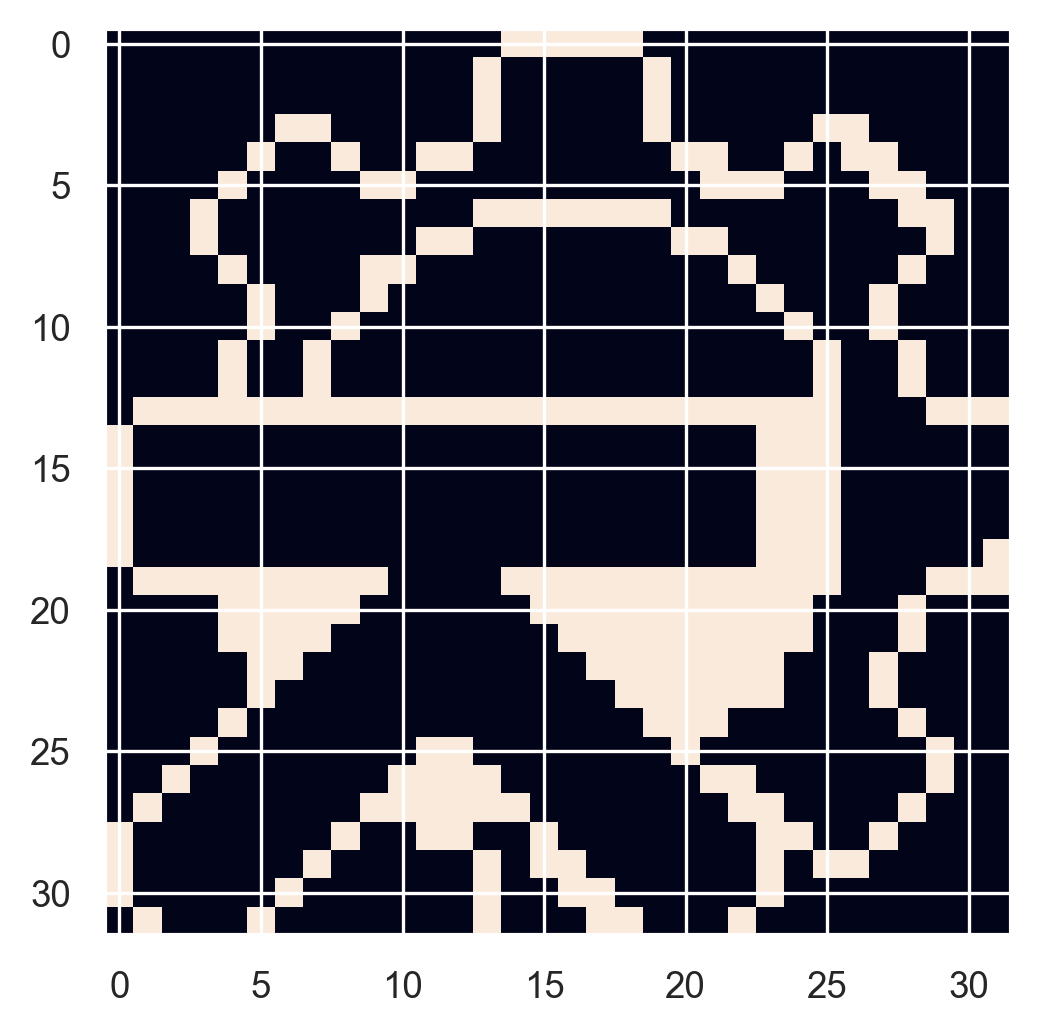

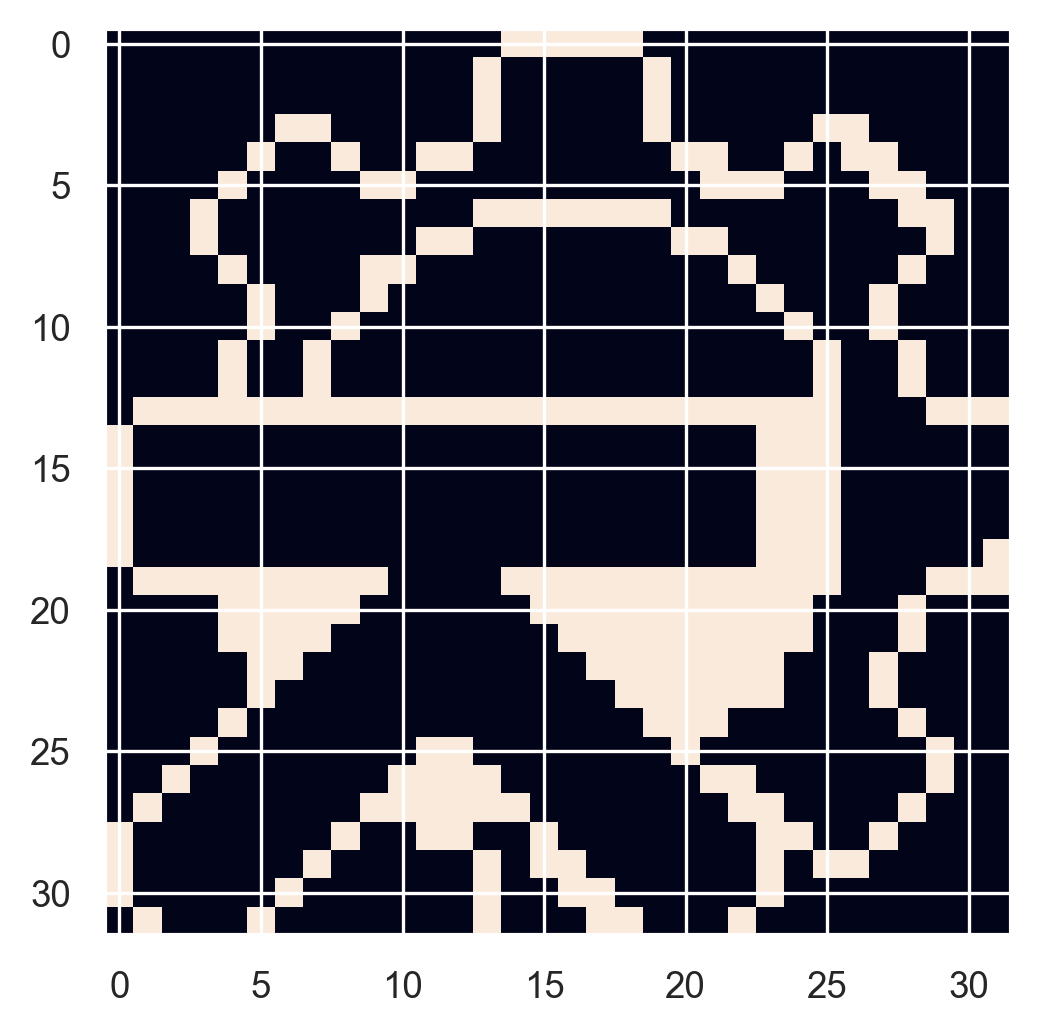

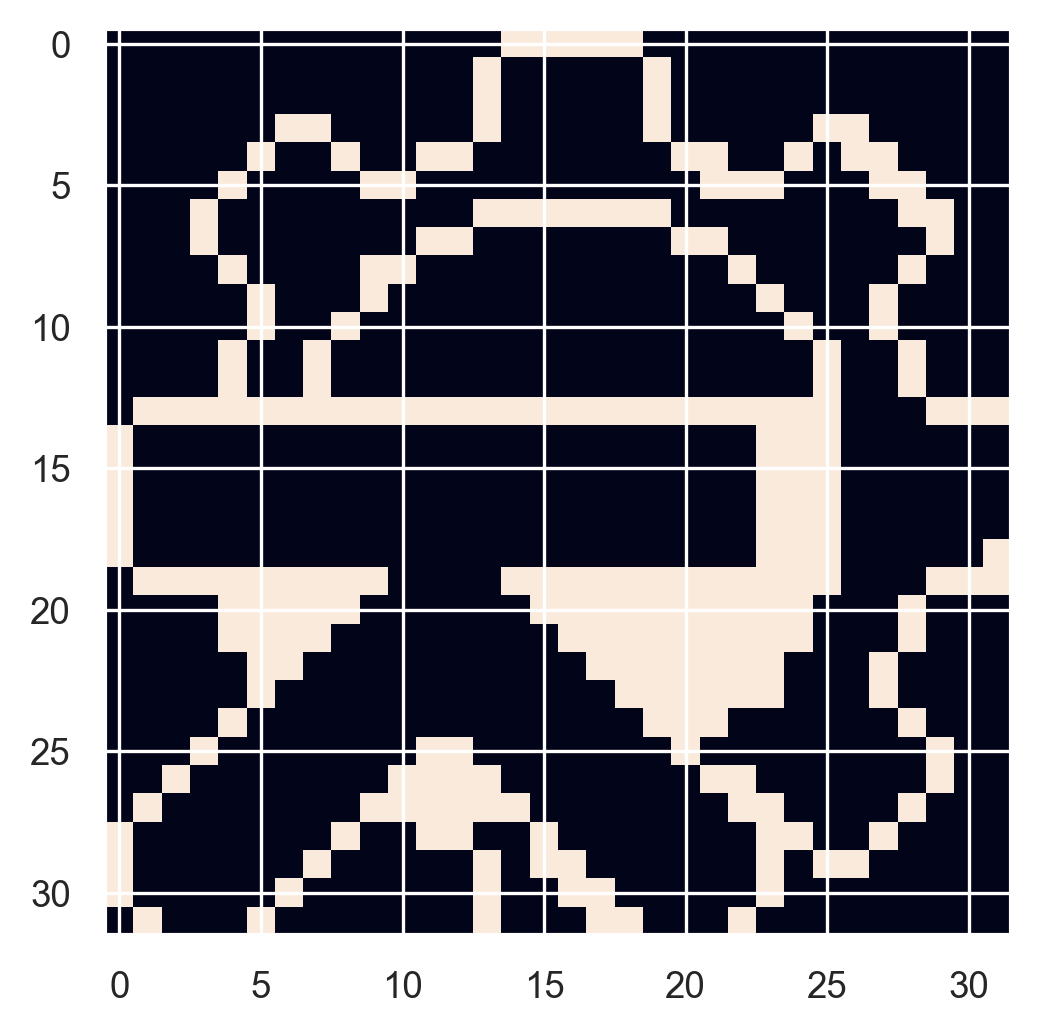

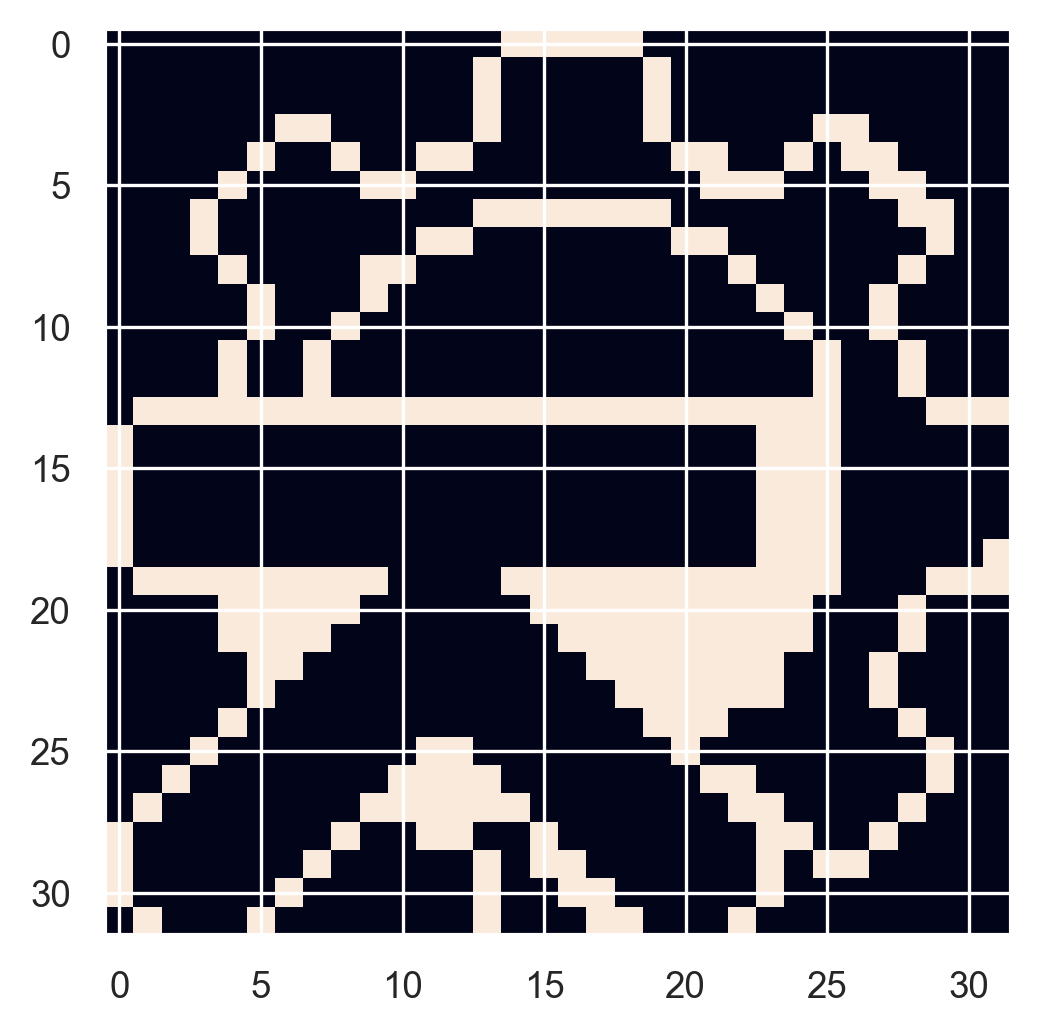

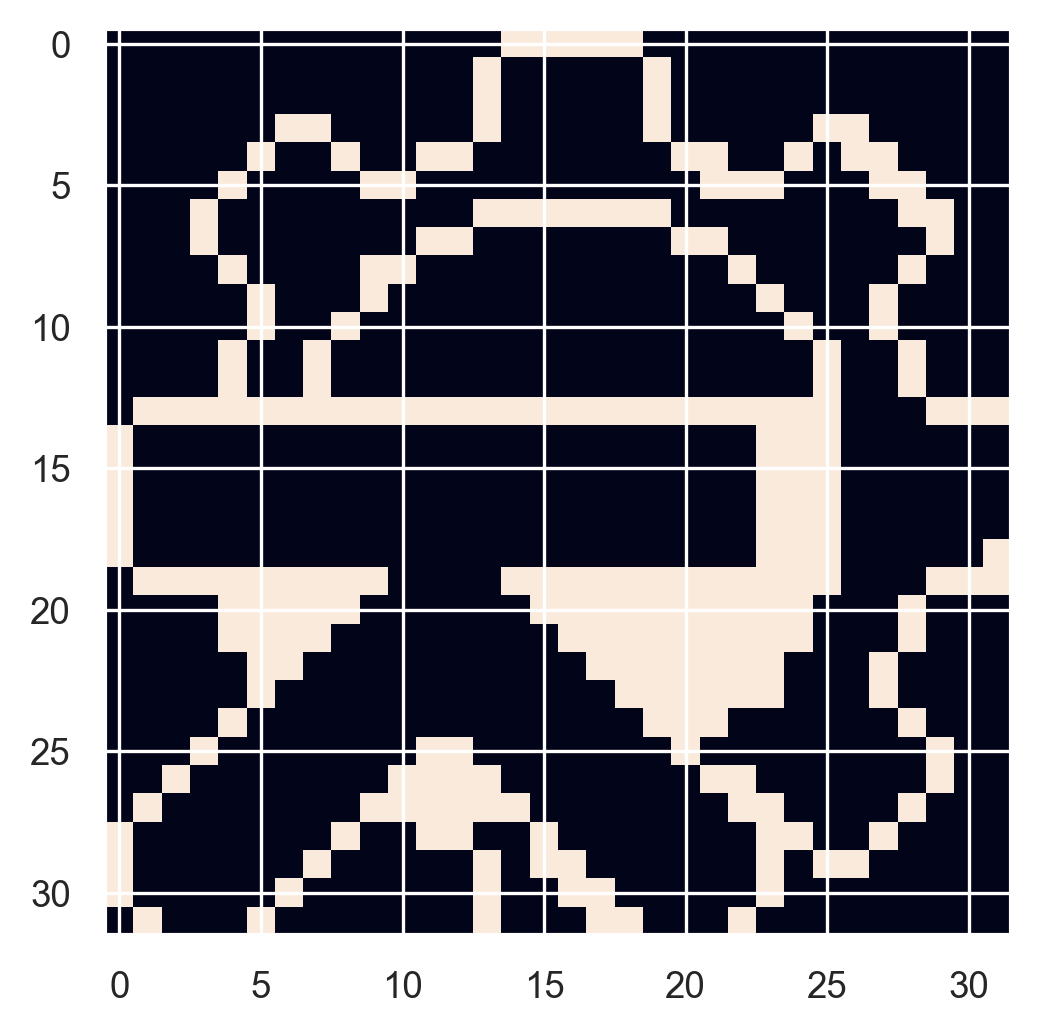

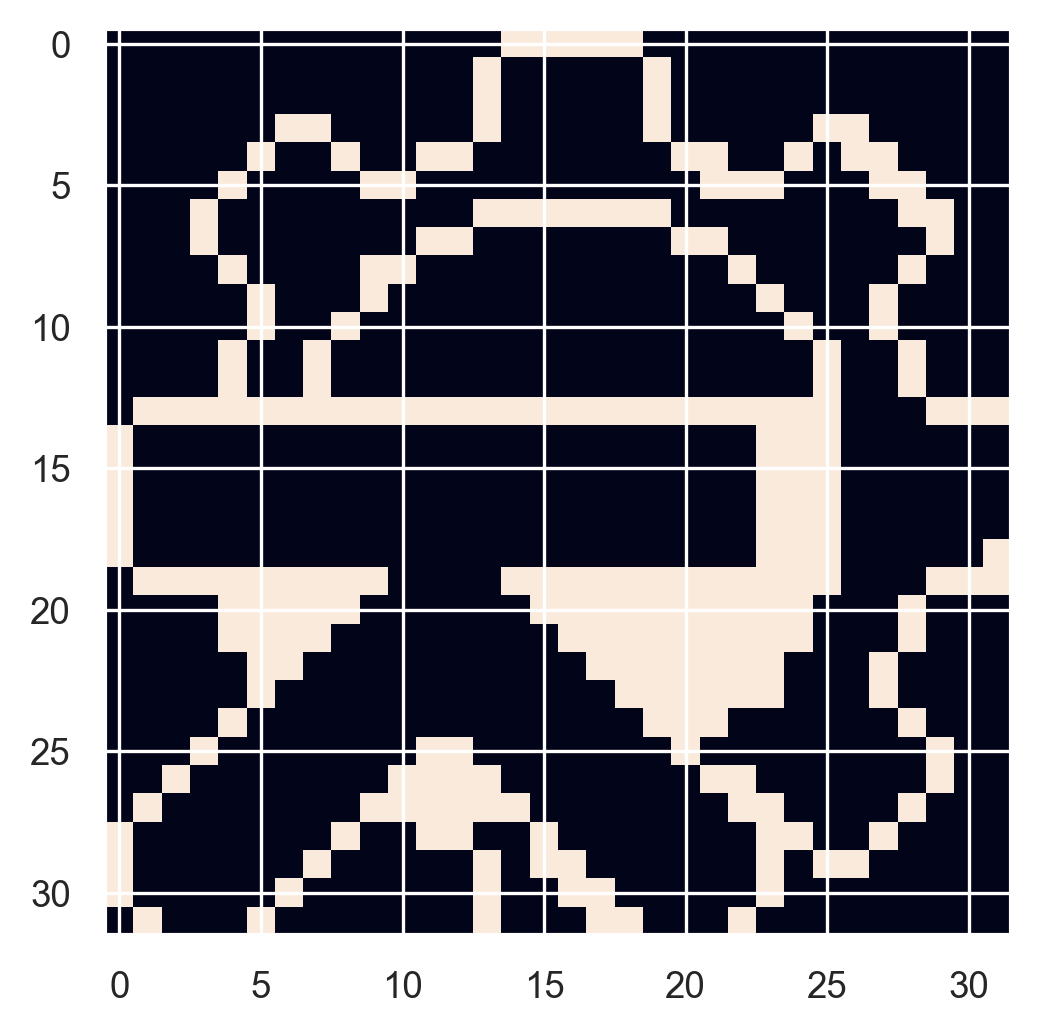

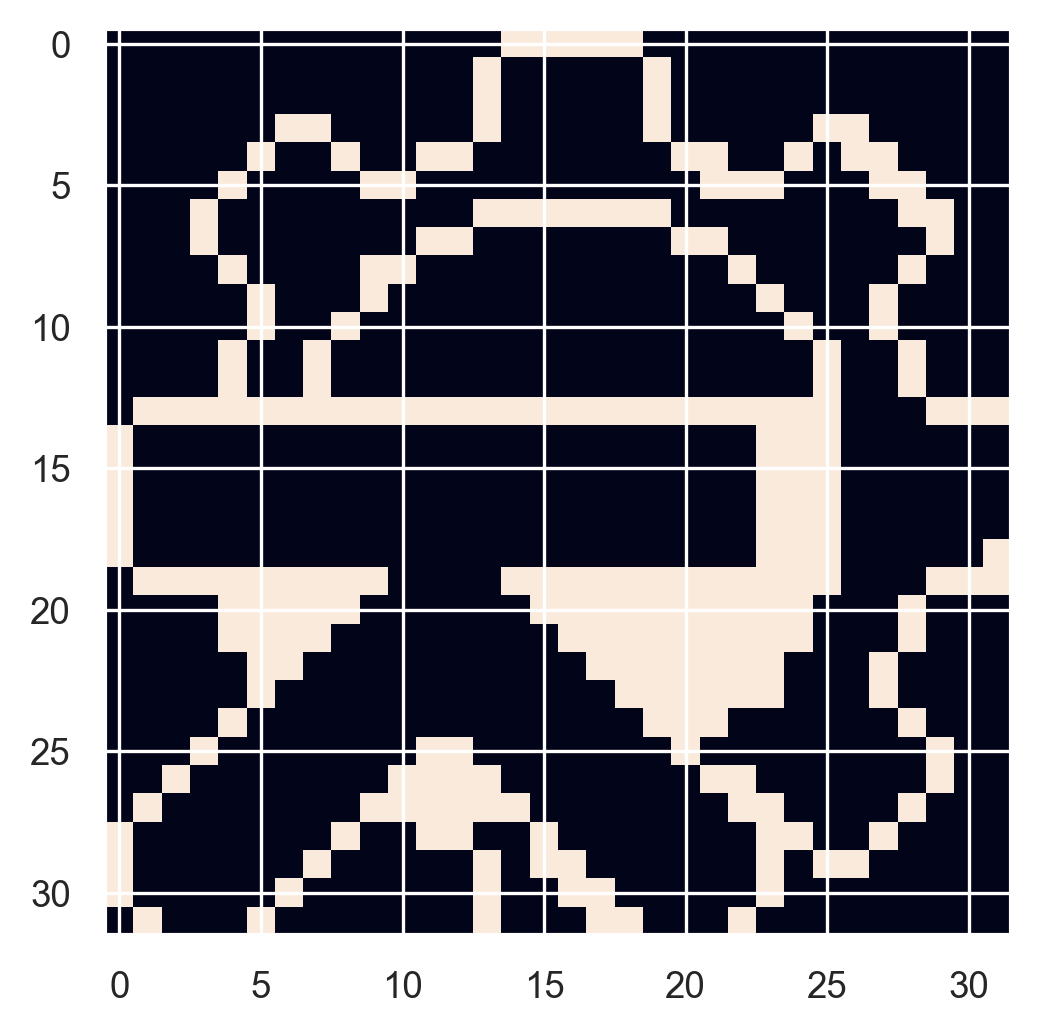

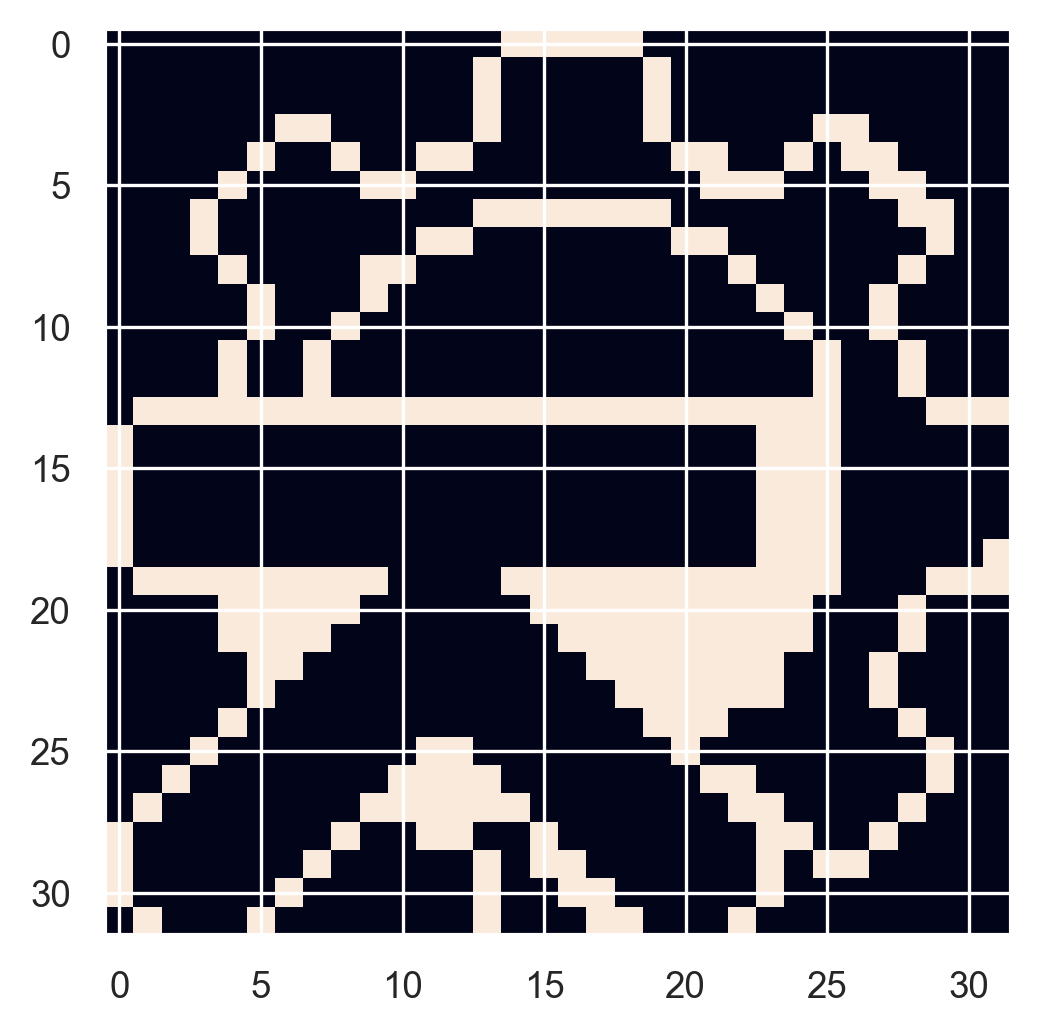

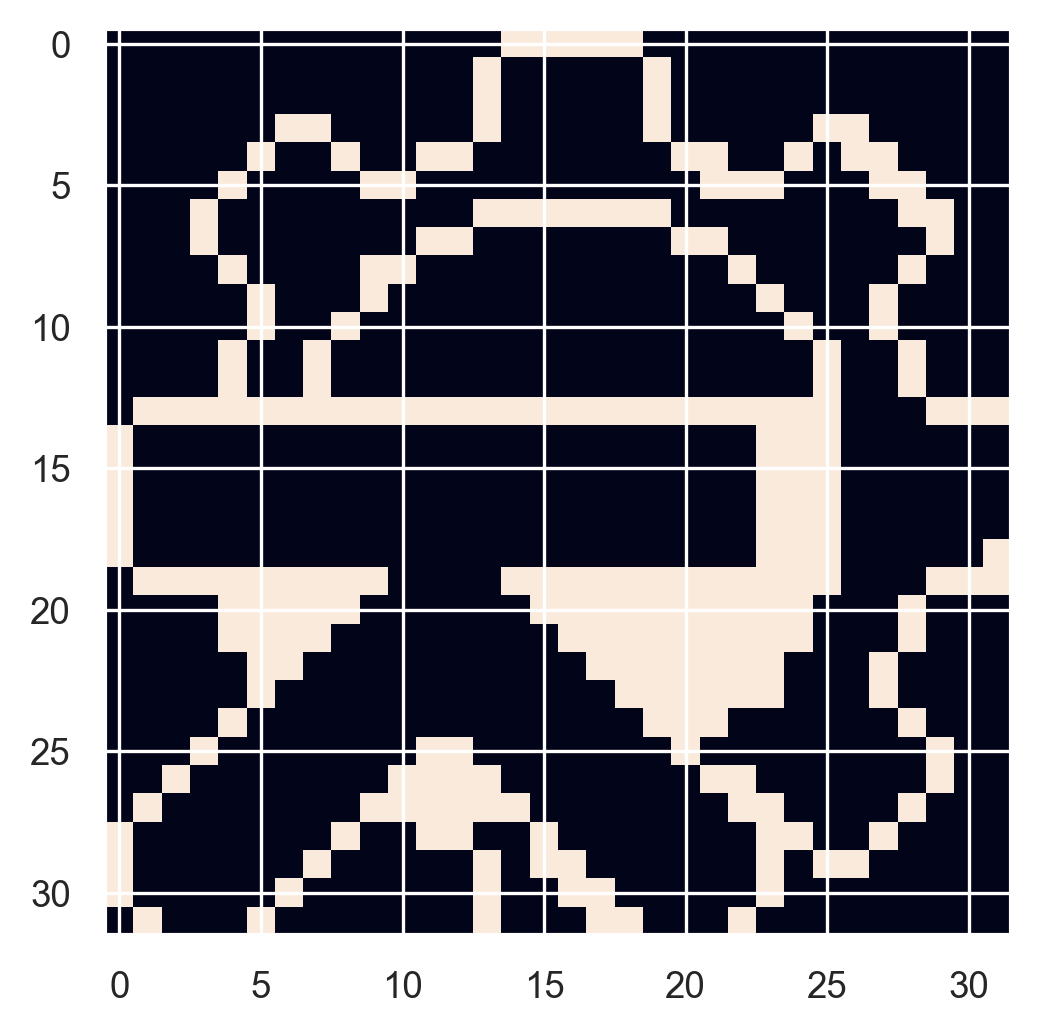

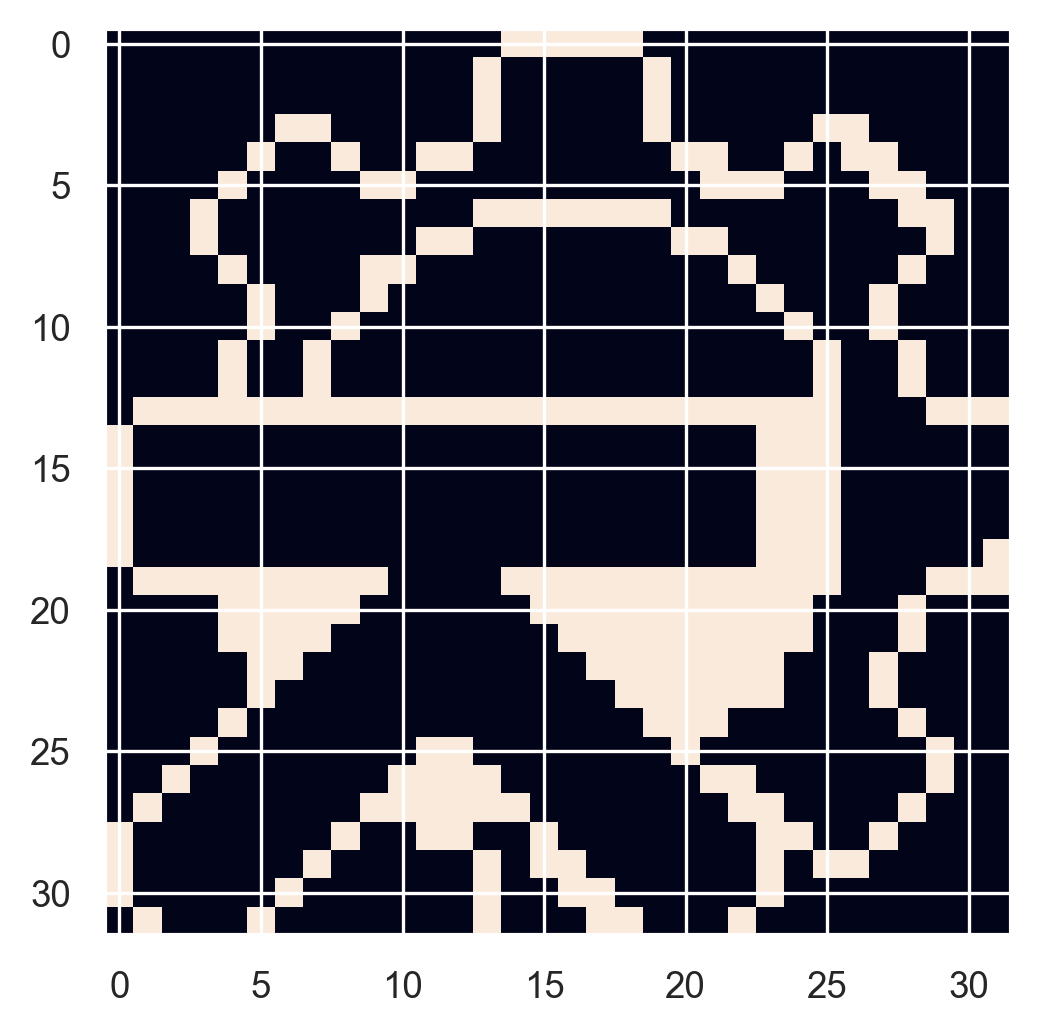

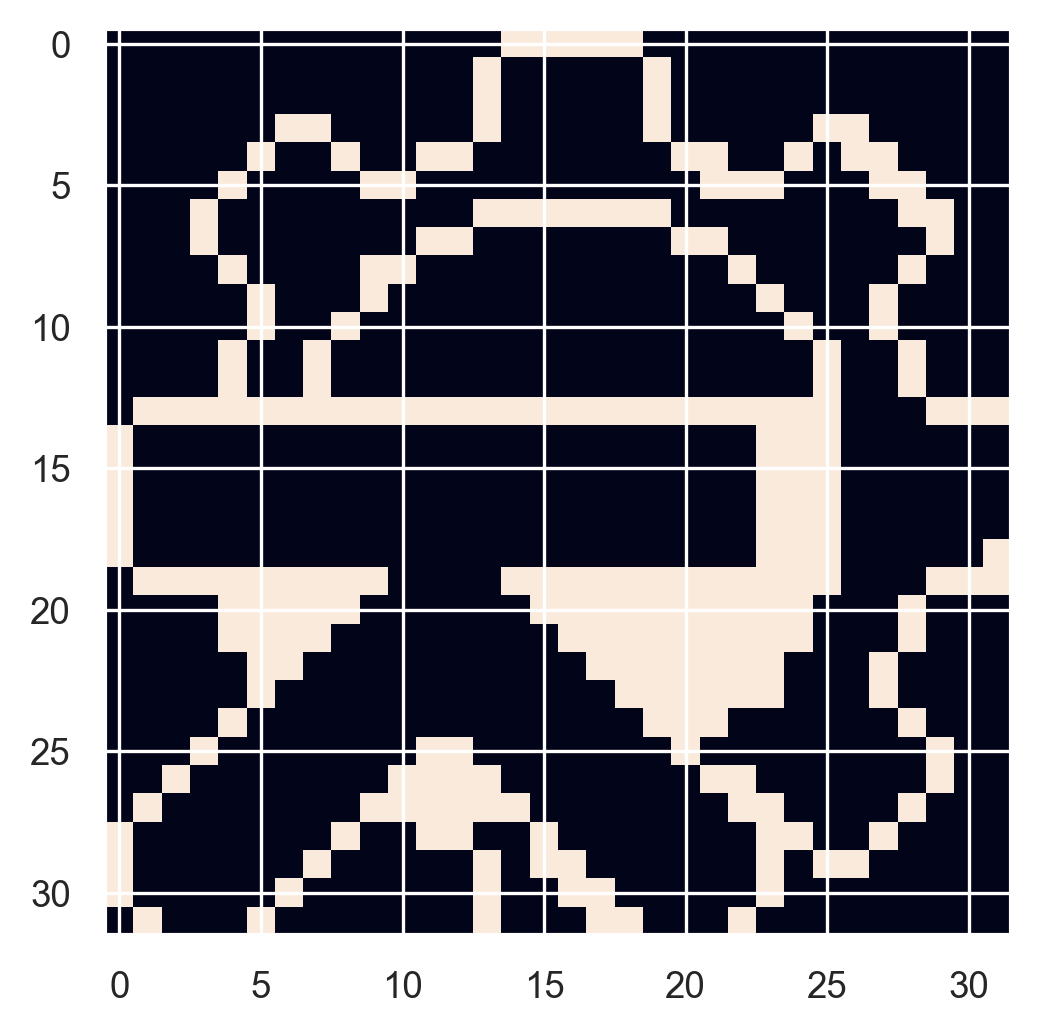

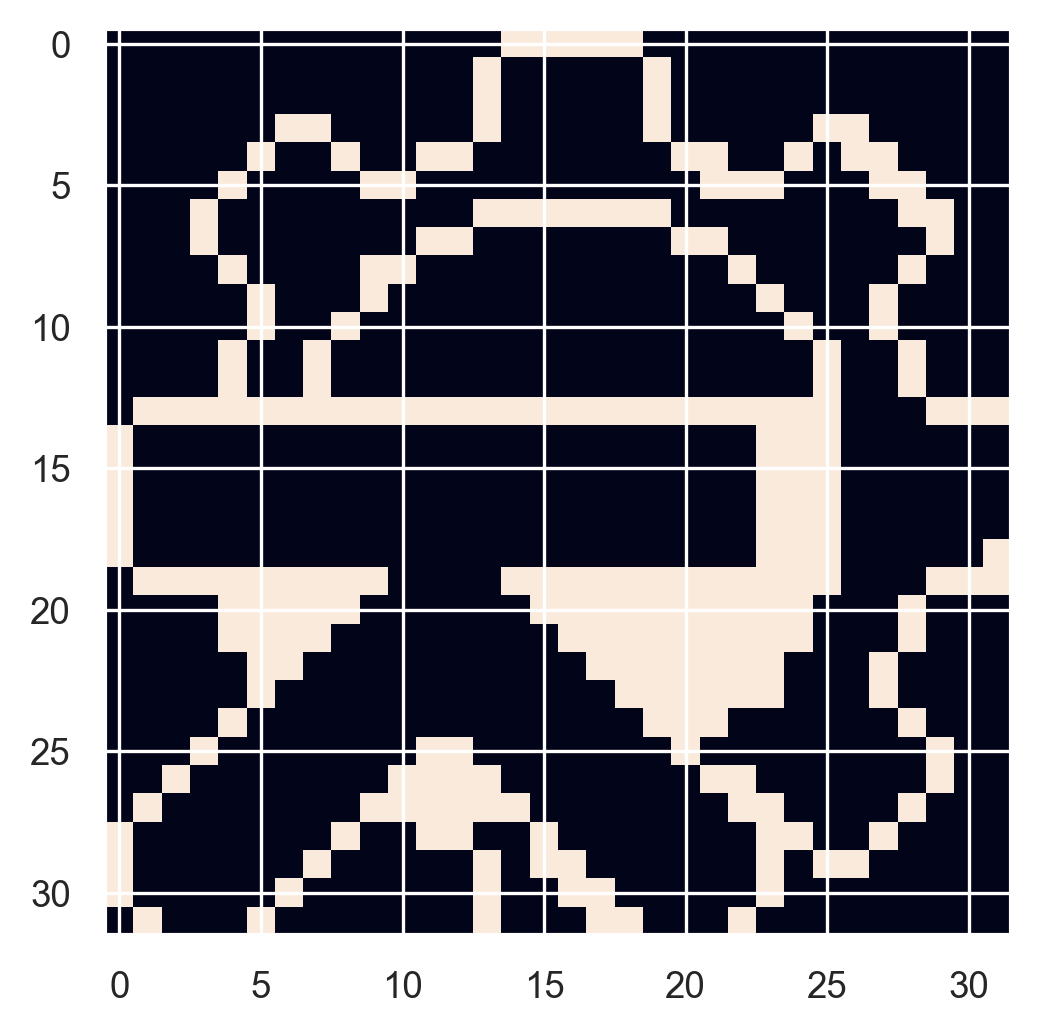

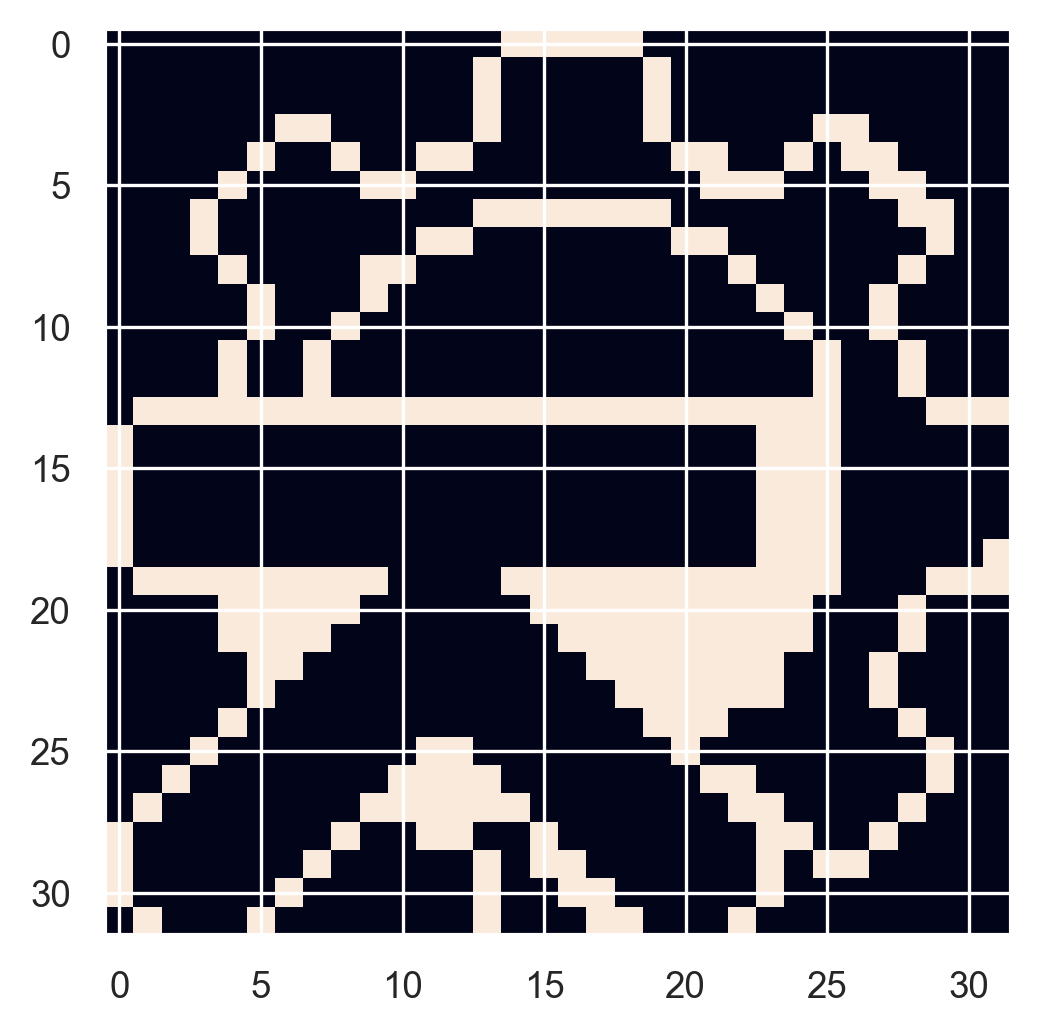

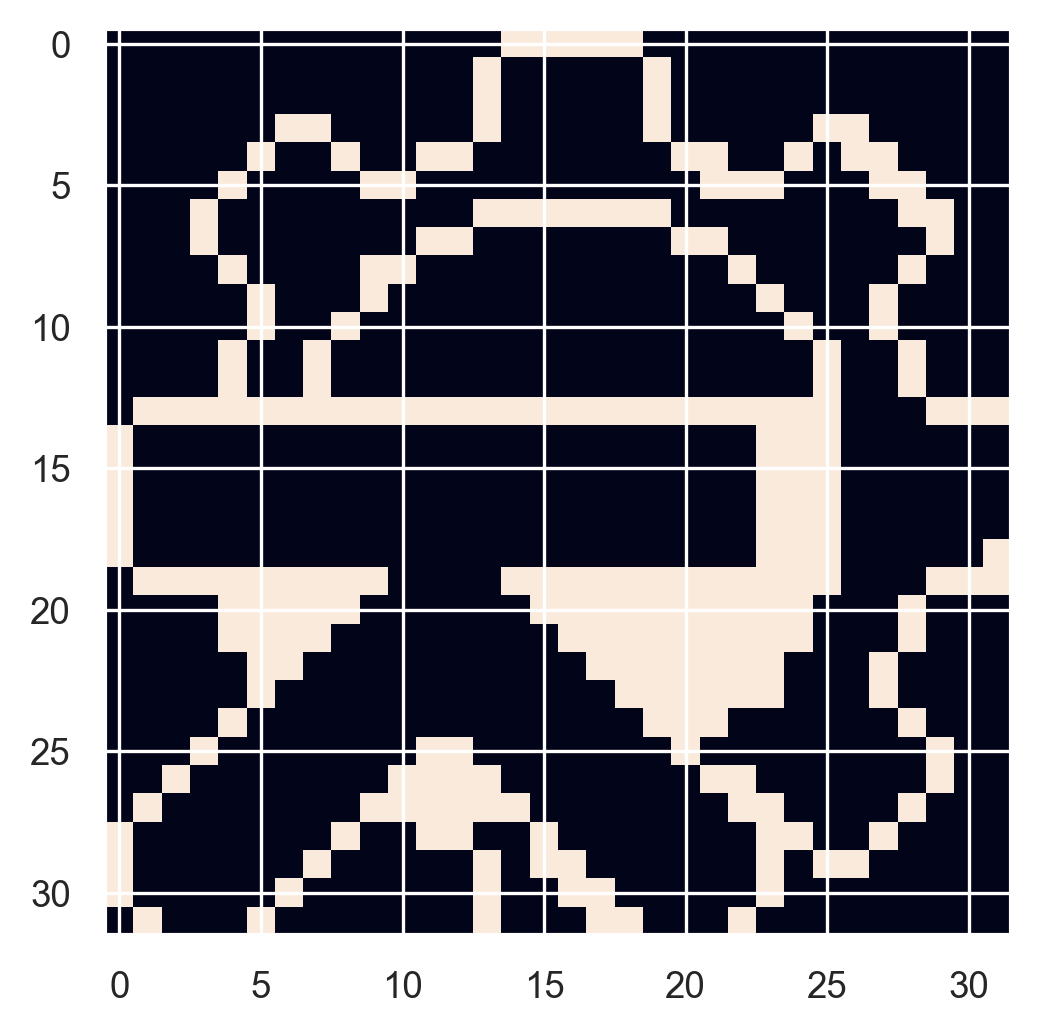

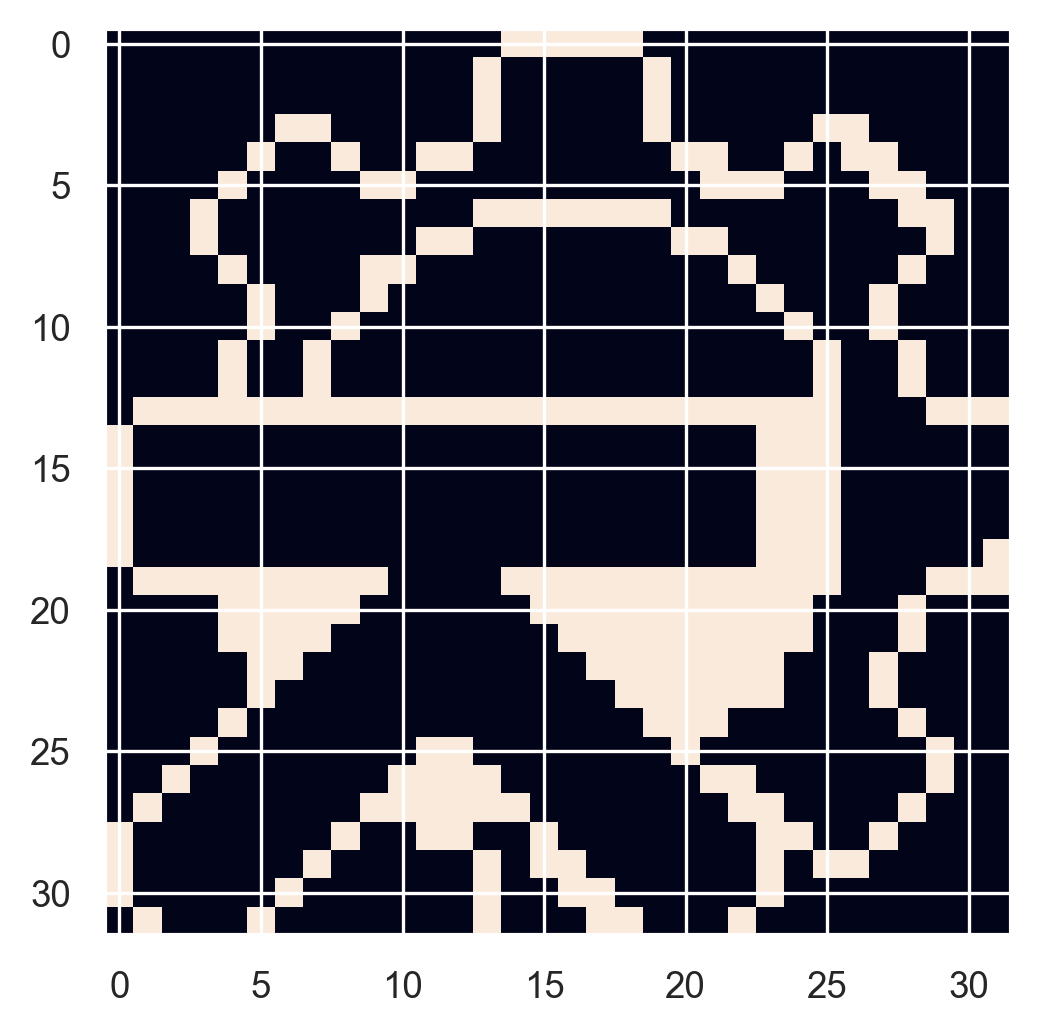

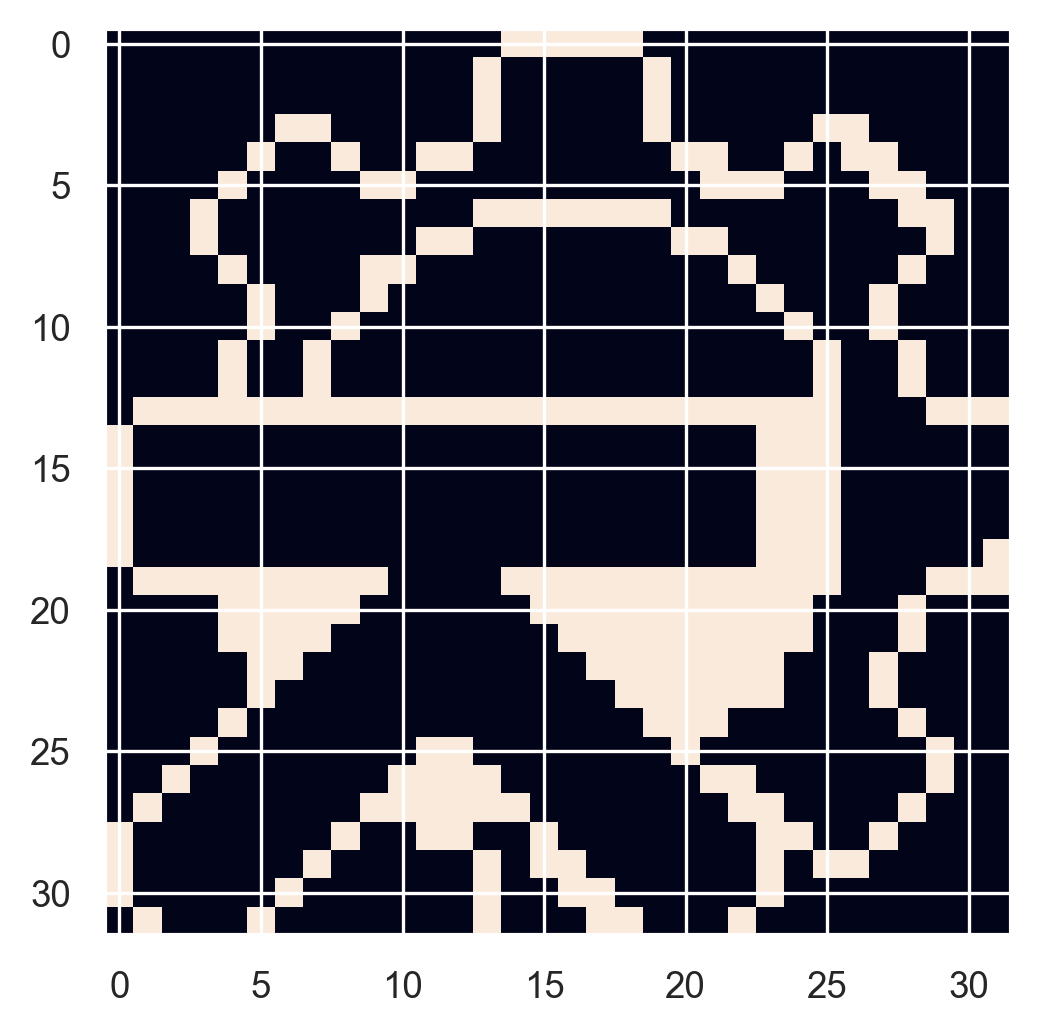

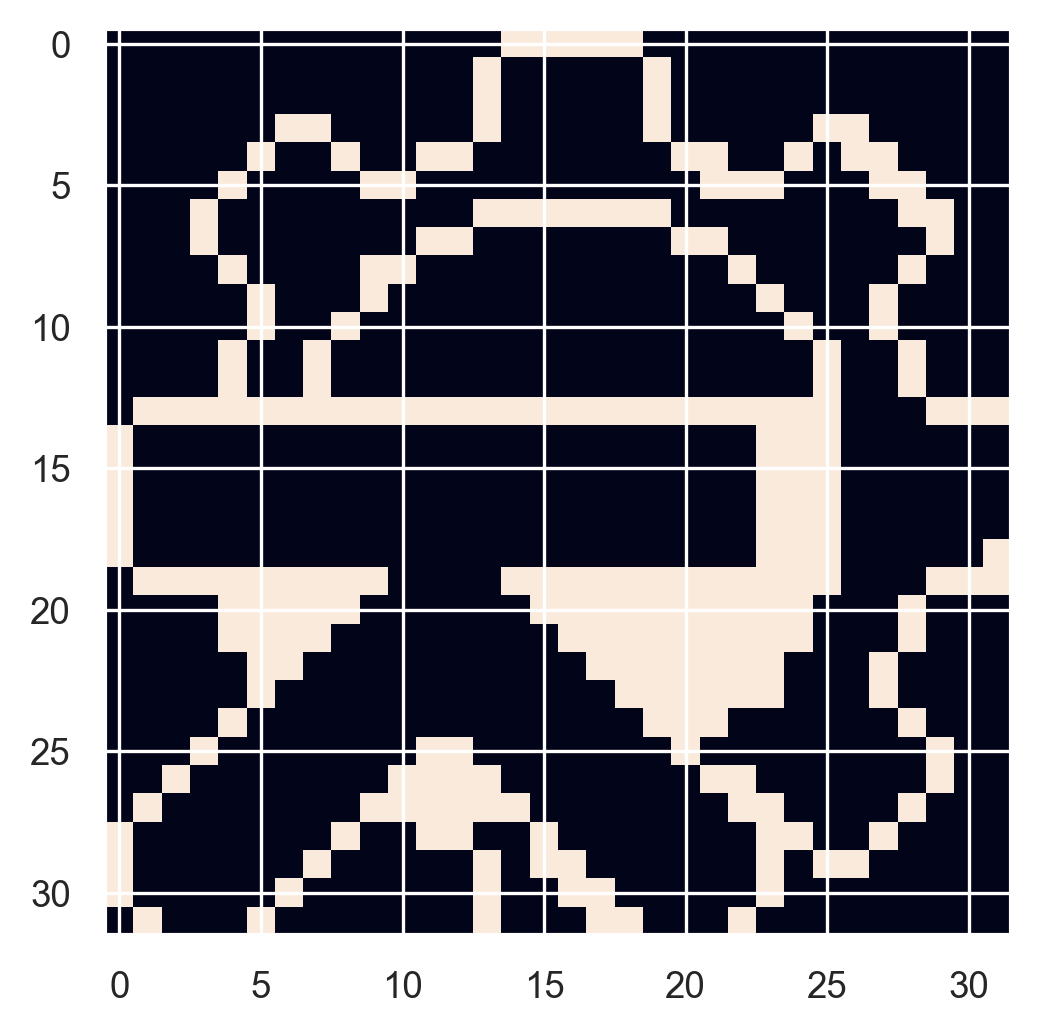

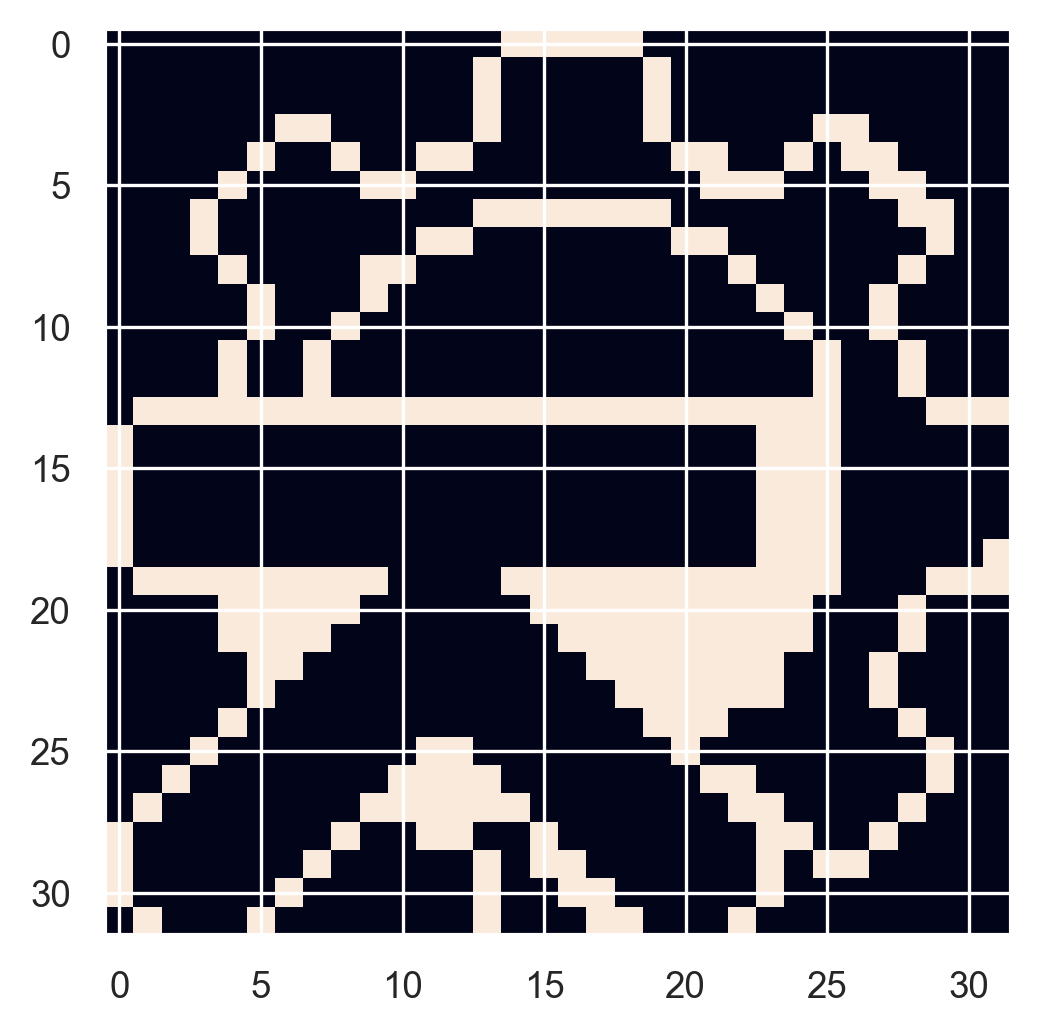

array([[-1., -1., -1., ..., -1., -1., -1.]])

In [4]:
def print_fn(iteration, pattern_index, unit_index, pattern):
    if unit_index % 100 == 0:
        fig, ax = plt.subplots()
        p = pattern.copy().reshape((32, 32))
        ax.imshow(p)
        plt.show()
    
nn.recall(patterns[[10], :], callback=print_fn)

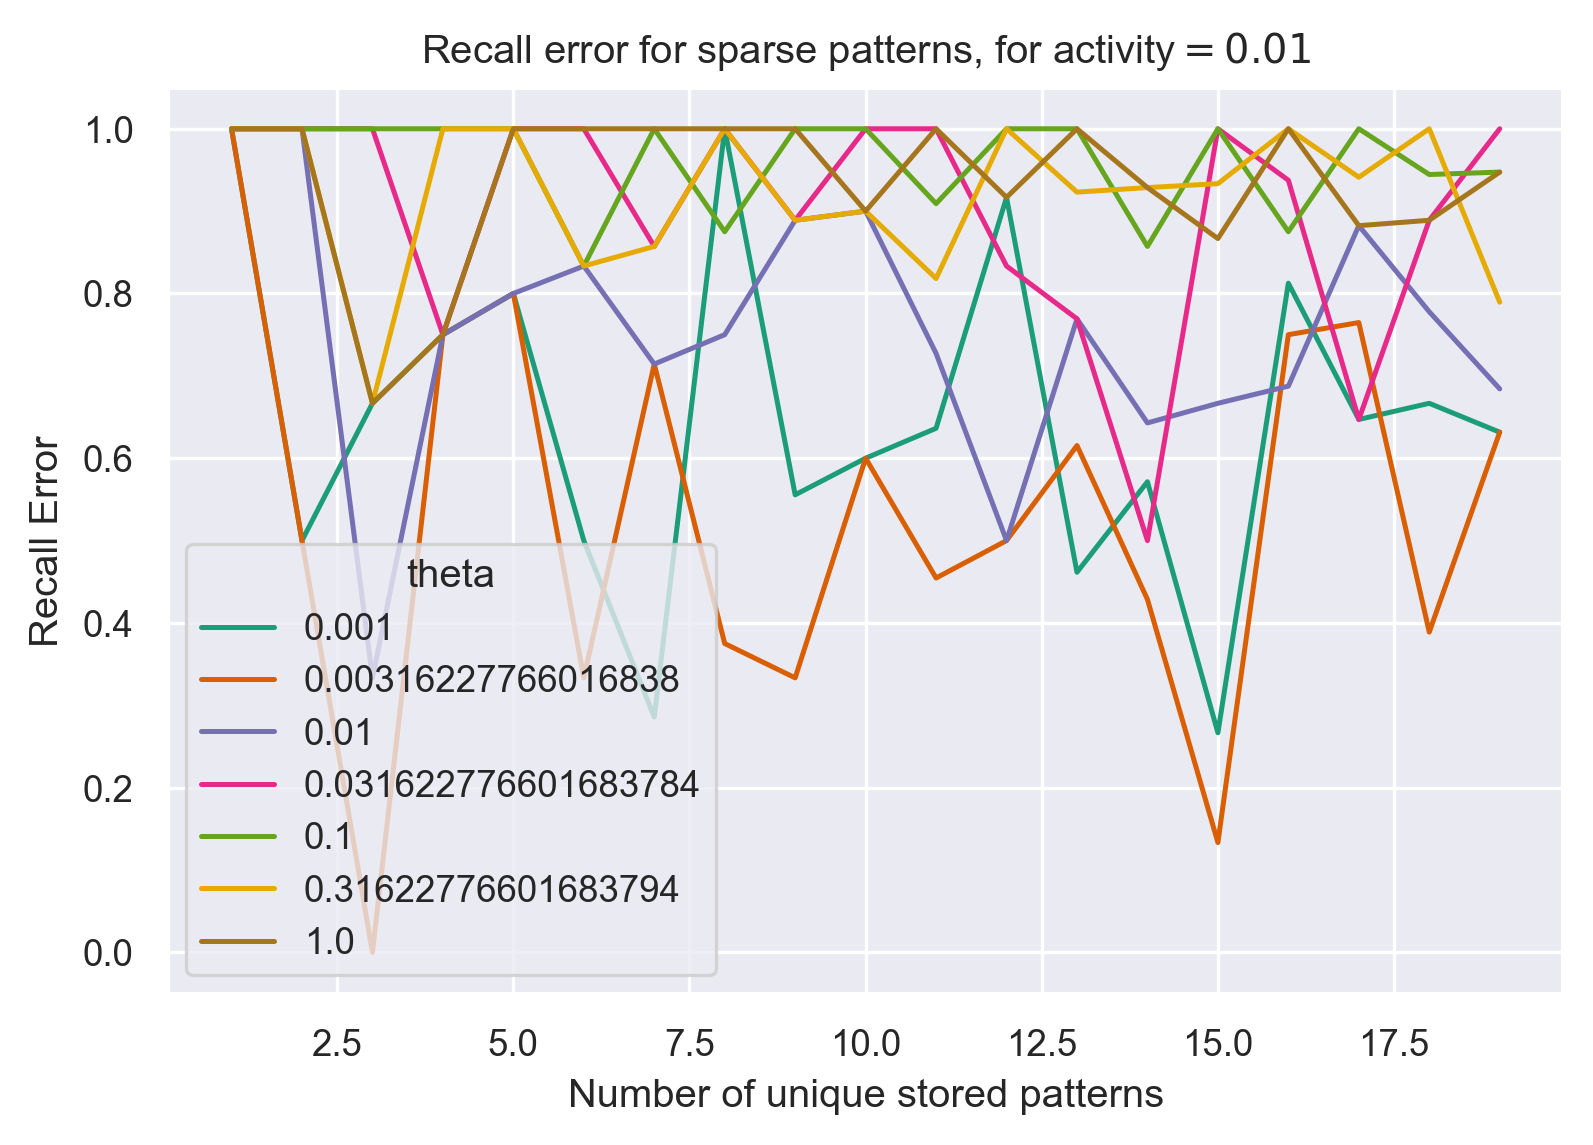

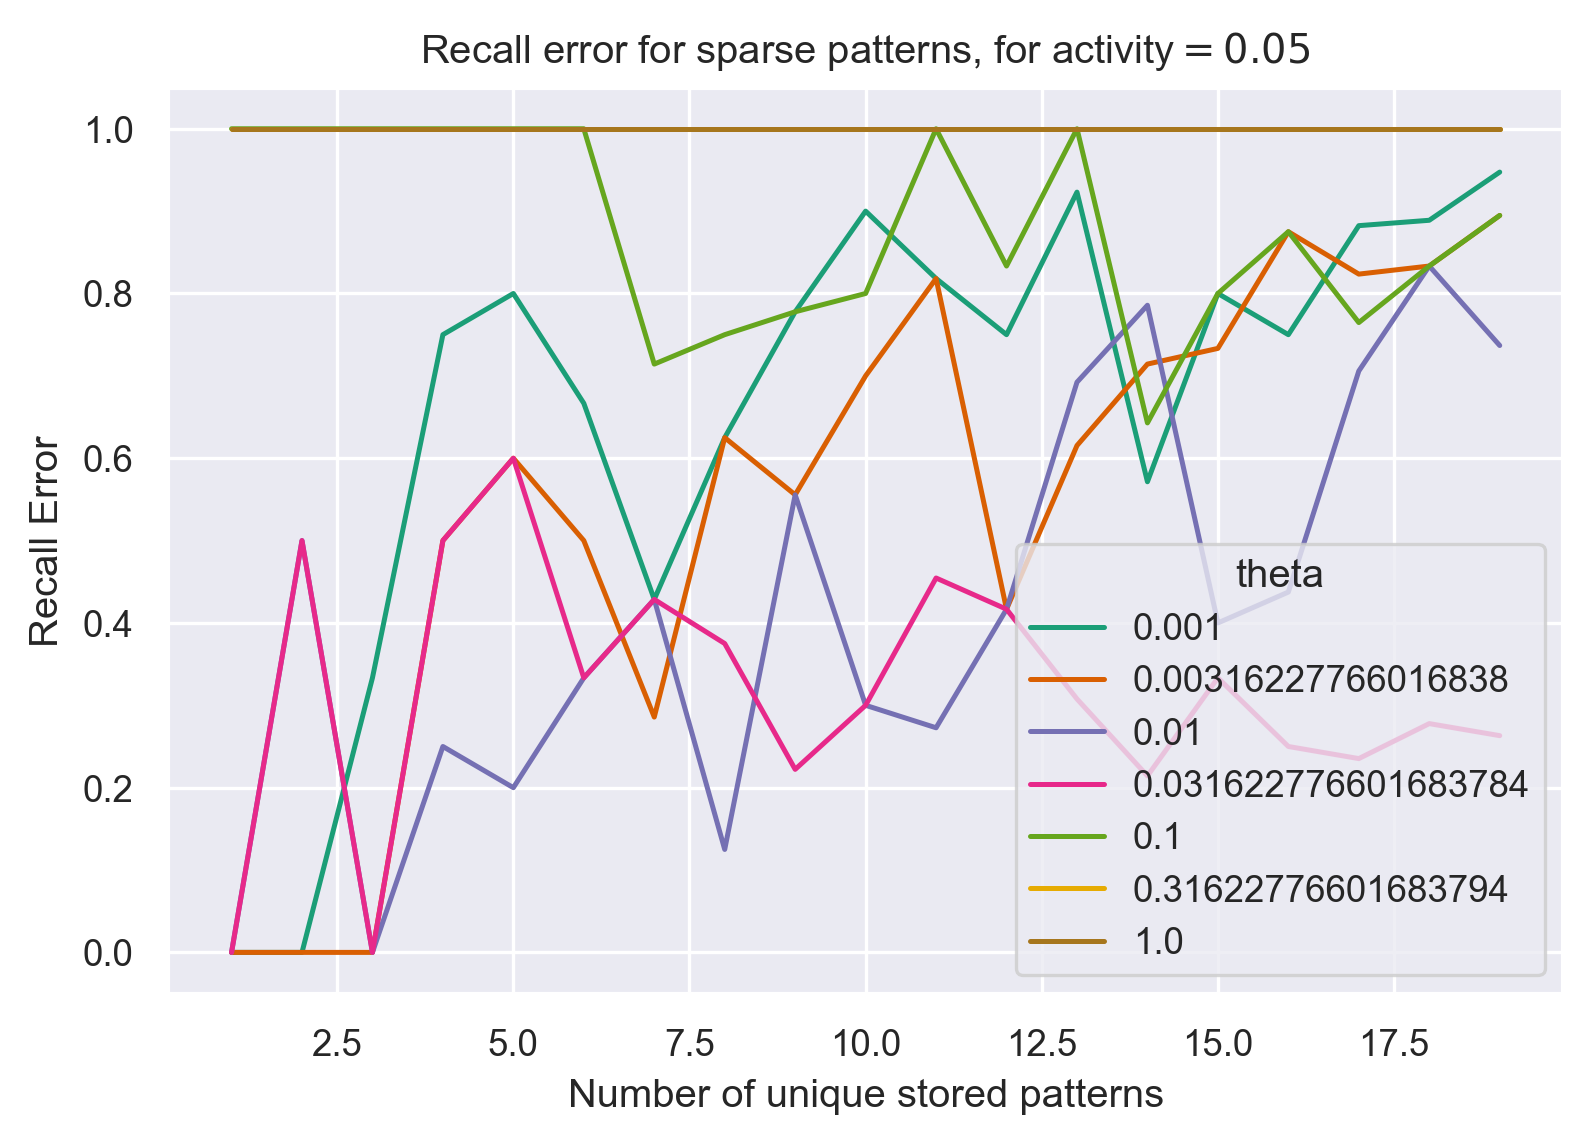

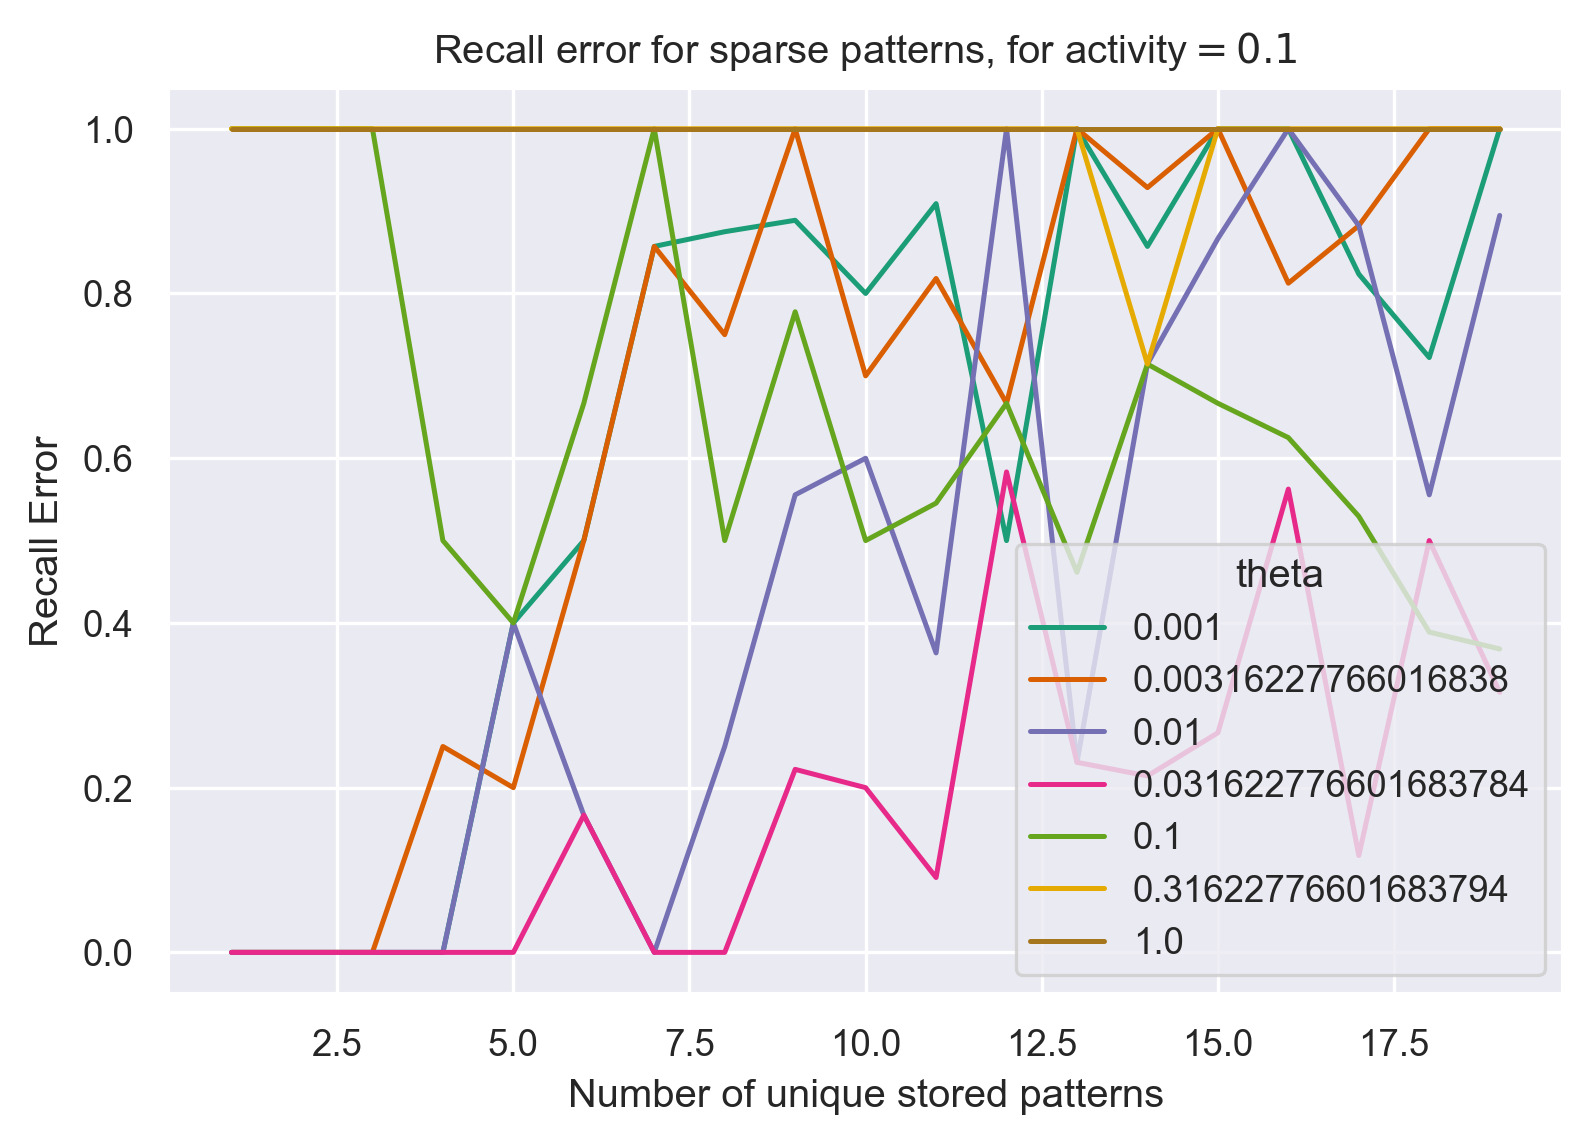

""


In [39]:
def plot_theta_vs_mse(sparse_df: pd.DataFrame):
    activity = sparse_df['activity'].unique()[0]
    
    fig, ax = plt.subplots()
    sns.lineplot(x='n_patterns', y='recall_error', hue='theta', data=sparse_df, ci=None, ax=ax)
    ax.set_xlabel('Number of unique stored patterns')
    ax.set_ylabel('Recall Error')
    ax.set_title(f'Recall error for sparse patterns, for activity$= {activity}$')
    plt.show()
 
sparse_test_data = pd.read_csv('sparse_tests.csv')
sparse_test_data['activity'] = sparse_test_data['activity'].astype('category')
sparse_test_data = sparse_test_data[sparse_test_data['theta'] >= 10e-4]
sparse_test_data['theta'] = sparse_test_data['theta'].astype('category')
sparse_test_data 
sparse_test_data.groupby('activity').apply(plot_theta_vs_mse)